In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm # To colour dots of scatter plots
from math import sqrt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
import sys
sys.path.insert(1, '../utilities/')

from proj1_helpers import *
from datapreprocessing import *
from implementations import *
from patternsmissingvalues import *
from gradient_descent import *
from split_test_train import *
from functions_for_log_regression import *
from plots import *
from visualization_PCA import *
from loss_computations import *
from functions_for_complex_analysis import *

In [3]:
DATA_TRAIN_PATH = '../../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
DATA_TEST_PATH = "../../data/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

# Exploratory Data Analysis

In [4]:
print(y.shape,tX.shape,ids.shape)

(250000,) (250000, 30) (250000,)


## Correlation Matrix:

dict_keys([(4, 6), (4, 12), (4, 26), (4, 27), (4, 28), (6, 12), (6, 26), (6, 27), (6, 28), (9, 29), (12, 26), (12, 27), (12, 28), (23, 24), (23, 25), (24, 25), (26, 27), (26, 28), (27, 28)])


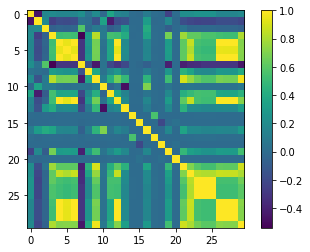

In [5]:
#corrcoef normalizes the values given by the correlation matrix
corr1 = np.corrcoef(tX.T)
f,a = plt.subplots()
heatmap_corr = a.imshow(corr1)
f.colorbar(heatmap_corr, ax=a)
res = np.where(corr1 > 0.95) #arbitrary threshold for strong correlation
listOfCoordinates= list(zip(res[0], res[1]))
listOfCoordinates = [cord for cord in listOfCoordinates if cord[0] != cord[1]] #remove diagonal
listOfCoordinates = {tuple(sorted(t)): t for t in listOfCoordinates}#remove commutative elements
print(listOfCoordinates.keys())
plt.savefig("../plots/correlation_matrix")

We identify strong correlations between the features listed above. However, these results should be interpreted carefully because a lot of the strong correlations observed might be due to the -999 missing values. However, this can still be useful if the missing values aren't distributed randomly in the data

## PCA:

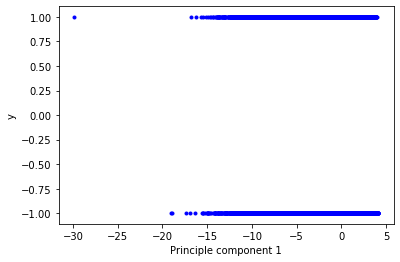

In [6]:
X_pca = pca(tX)
plt.scatter(X_pca[:,0],y, marker=".", color="b")
plt.xlabel('Principle component 1')
plt.ylabel('y')
plt.show()

Plot of the first PCA component against the output, we conclude that the first principal component is not sufficient to separate the predictions.

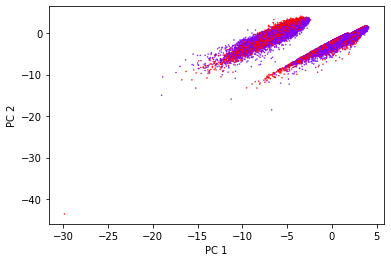

In [7]:
colors = cm.rainbow(y)

plt.scatter(X_pca[:,0],X_pca[:,1], marker=".", color=colors,s=1)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

Plot of the first PCA component against the second PCA component. The dots are color labeled according to their output value y. Unfortunately, we notice that the clusters identified in the plot do not discriminate between the two output categories.

## Missing values :

Missing values are arbitrarily set to -999 distort the variability of certain explanatory variables significantly, which might be problematic when weights are to be determined. As -999 is so far off the usual values of the variables, learning a model with observations containing missing values, the variability of the correctly measured values might be overshadowed by the presence of the faulty ones. One should therefore consider coming up with ways to handle missing values.

### Replacing missing values by mean over column :

The simplest way to deal with missing values is to set each of them to the mean over the explanatory variable without any -999s. However, this comes with a disadvantage as we introduce information, which is critical for the prediction and most likely inaccurate.

In [8]:
tX_missing_val_replaced = set_missing_explanatory_vars_to_mean(tX)

The correlation matrix then becomes:

dict_keys([(9, 21), (9, 29)])


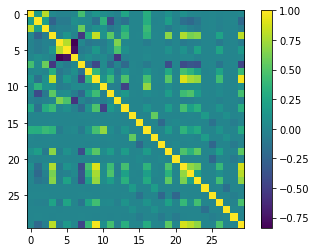

In [9]:
corr2 = np.corrcoef(tX_missing_val_replaced.T)
f,a = plt.subplots()
heatmap_corr = a.imshow(corr2)
f.colorbar(heatmap_corr, ax=a)
res = np.where(corr2 > 0.90) #arbitrary threshold for strong correlation
listOfCoordinates= list(zip(res[0], res[1]))
listOfCoordinates = [cord for cord in listOfCoordinates if cord[0] != cord[1]] #remove diagonal
listOfCoordinates = {tuple(sorted(t)): t for t in listOfCoordinates}#remove commutative elements
print(listOfCoordinates.keys())
plt.savefig("../plots/correlation_matrix_no_missing_values")

One sees that by replacing all the missing values by the mean of the remaining ones, the number of highly correlated values diminishes drastically. Only two pairs of features are very strongly correlated if a threshold of 0.9 is chosen. 

Performing a principle component analysis on the data matrix where -999s were set to the mean over the column and plotting PCA1 vs PCA2, one sees that the two different groups that appeared previously on this plot type were mere artifacts of the arbitrary convention of setting faulty measurement values to -999 :

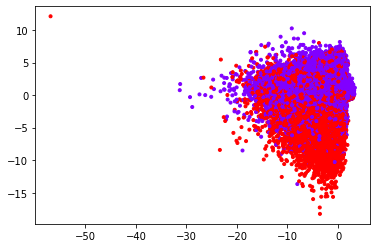

In [10]:
tX_missing_val_replaced_pca = pca(tX_missing_val_replaced)
colors = cm.rainbow(y)
plt.scatter(tX_missing_val_replaced_pca[:,0],tX_missing_val_replaced_pca[:,1], marker=".", color=colors)
plt.show()

Furthermore, already when one considers only the first two principle components one, the signal 's' and background 'b' appear to be separable to some degree.

### Taking into account patterns for the handling of missing values

In the following, it is shown that rather than being arbitrarily distributed in the data matrix, the missing values exhibit a clear pattern. This pattern can be accounted for in order to improve the accuracy of the prediction.

It can easily be shown that the test and the train data matrices have missing values (-999) in the same columns :

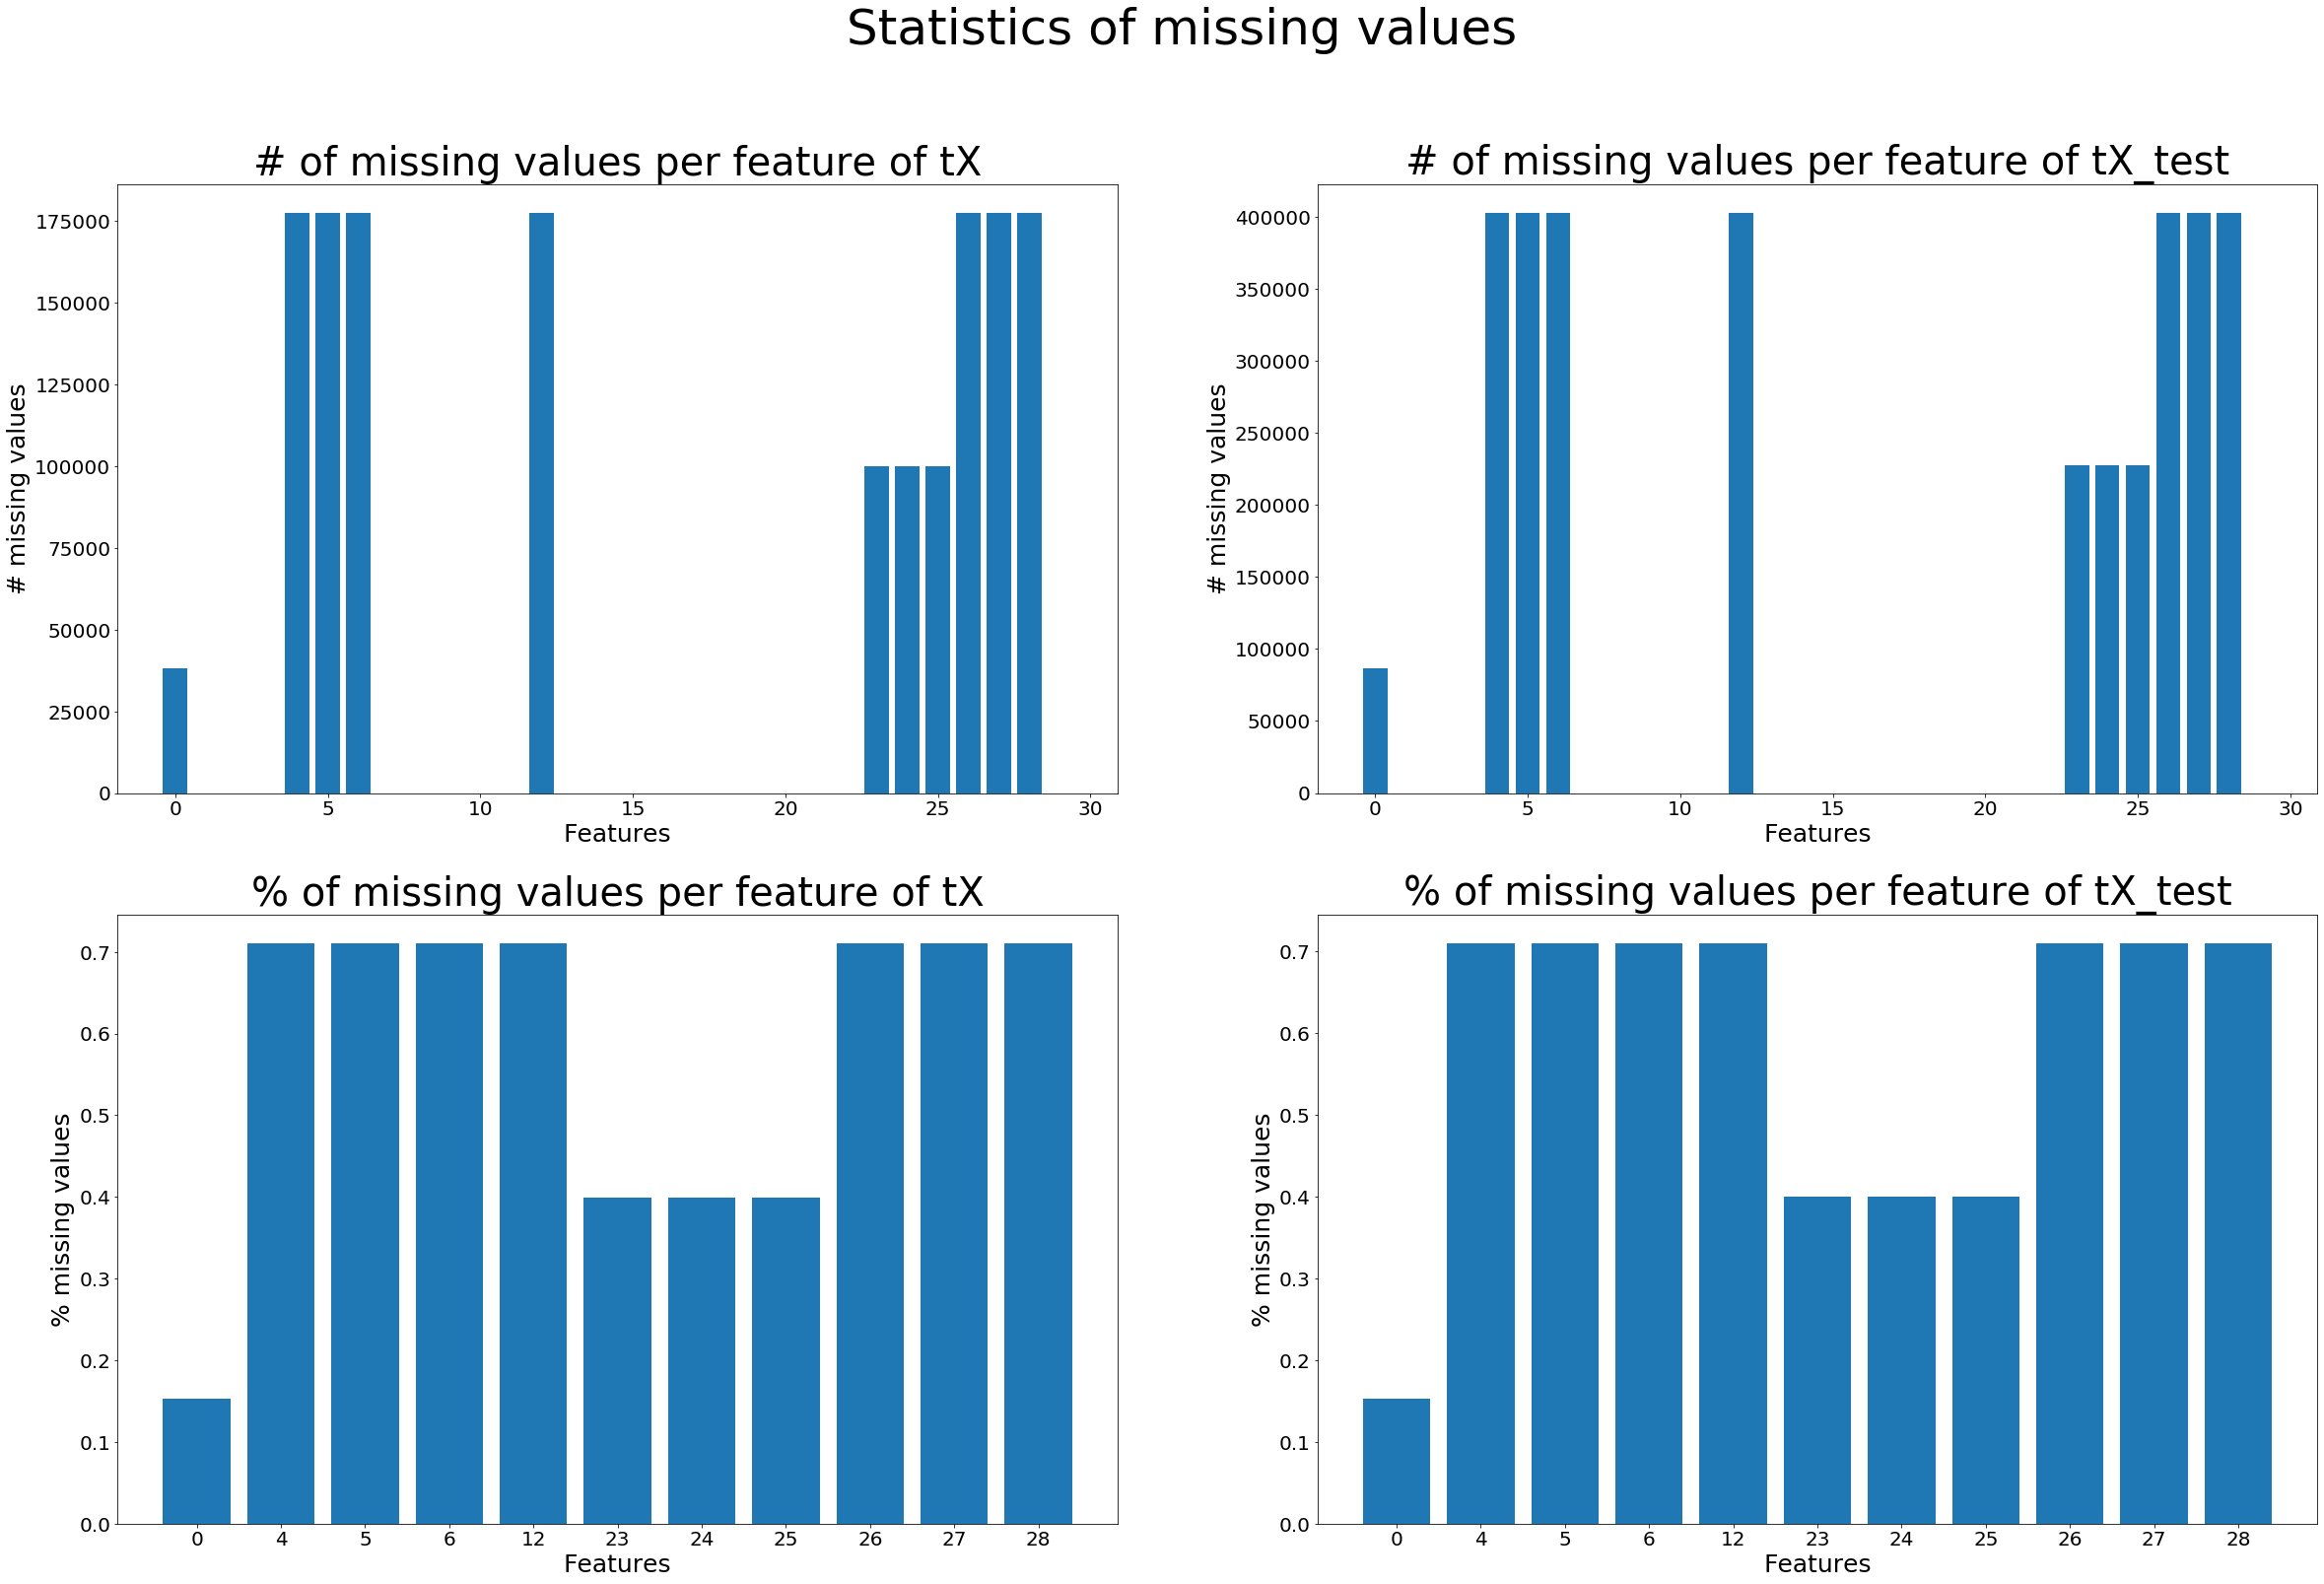

The same features contain missing values in the testing and the training data :  True


In [11]:
# Missing values don't appear to be random. Test that in both test and train data the same columns are full of gaps

tX_mv = sum(tX == -999) # Array with columnwise count of faulty measurements in training data
tX_test_mv = sum(tX_test == -999) # Array with columnwise count of faulty measurements in test data

ratio_mv_tX_cols = tX_mv[tX_mv > 0]/tX.shape[0]
ratio_mv_tX_test_cols = tX_test_mv[tX_test_mv > 0]/tX_test.shape[0]

fig,ax = plt.subplots(2, 2)
fig.suptitle('Statistics of missing values', fontsize=50)

ax[0,0].bar(np.arange(tX.shape[1]),tX_mv)
ax[0,0].set_xlabel('Features',fontsize=25)
ax[0,0].set_ylabel('# missing values',fontsize=25)
ax[0,0].set_title('# of missing values per feature of tX', fontsize=40)
ax[0,0].tick_params(axis='both', which='major', labelsize=20)

ax[0,1].bar(np.arange(tX.shape[1]),tX_test_mv)
ax[0,1].set_xlabel('Features',fontsize=25)
ax[0,1].set_ylabel('# missing values',fontsize=25)
ax[0,1].set_title('# of missing values per feature of tX_test', fontsize=40)
ax[0,1].tick_params(axis='both', which='major', labelsize=20)

ax[1,0].bar(range(len(ratio_mv_tX_cols)),ratio_mv_tX_cols)
ax[1,0].set_xticks(range(len(ratio_mv_tX_cols)))
ax[1,0].set_xticklabels(np.arange(tX.shape[1])[tX_mv > 0])
ax[1,0].set_xlabel('Features',fontsize=25)
ax[1,0].set_ylabel('% missing values',fontsize=25)
ax[1,0].set_title('% of missing values per feature of tX', fontsize=40)
ax[1,0].tick_params(axis='both', which='major', labelsize=20)

ax[1,1].bar(range(len(ratio_mv_tX_test_cols)),ratio_mv_tX_test_cols)
ax[1,1].set_xticks(range(len(ratio_mv_tX_test_cols)))
ax[1,1].set_xticklabels(np.arange(tX_test.shape[1])[tX_mv > 0])
ax[1,1].set_xlabel('Features',fontsize=25)
ax[1,1].set_ylabel('% missing values',fontsize=25)
ax[1,1].set_title('% of missing values per feature of tX_test', fontsize=40)
ax[1,1].tick_params(axis='both', which='major', labelsize=20)

fig.set_figheight(25)
fig.set_figwidth(40)

plt.savefig("../plots/analysis_of_missing_val_per_column")
plt.show()

# Verification that the columns that contain missing values are the same in both the testing and the training data.
# "True" means both training and test data have values missing only in the excact same explanatory variables.
print("The same features contain missing values in the testing and the training data : ",np.array_equal(tX_mv >0,tX_test_mv >0))

Furthermore, the number of occurences are the same in multiple columns, suggesting that there might be patterns in the distribution of absent values.

Indeed, the manipulations below show that only six different combinations of absent explanatory variables appear in the training data set.

In [12]:
binary_mask_tX_mv = np.zeros(tX.shape)
binary_mask_tX_mv[tX == -999] = 1
print("Binary mask of tX, '0' means value is valid, '1' means it is missing :  \n\n", binary_mask_tX_mv.astype(int)) 

Binary mask of tX, '0' means value is valid, '1' means it is missing :  

 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 [1 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [1 0 0 ... 1 1 0]]


One can then easily extract all the different configurations of missing values in the extracted columns. There are only six of them, as shown below.

In [13]:
unique_patterns_mv = np.unique(binary_mask_tX_mv,axis = 0)

# All the different configurations of the missing values. There are only six of them.
print("The different configurations of the missing values in tX : \n\n", unique_patterns_mv.astype(int))
      

The different configurations of the missing values in tX : 

 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
 [0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
 [1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0]]


### Splitting the datas according to the patterns of missing values

In [14]:
tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX) 
# => regroupement of the steps performed above
y_split = split_y_according_to_pattern_of_missing_values(y, ind_row_groups)

tX_split_test, ind_row_groups_test, groups_mv_num_test = split_data_according_to_pattern_of_missing_values(tX_test)
print (" Both training and test data exhibit the exact same pattern of missing values in the explanatory variables : ")
np.array_equal(groups_mv_num,groups_mv_num_test) 

 Both training and test data exhibit the exact same pattern of missing values in the explanatory variables : 


True

A principle component analysis of each subgroup with its distinct pattern of missing values can then be performed.

group 1 of 6, indices of removed outliers : []
group 2 of 6, indices of removed outliers : []
group 3 of 6, indices of removed outliers : [2218]
group 4 of 6, indices of removed outliers : []
group 5 of 6, indices of removed outliers : []
group 6 of 6, indices of removed outliers : [21218]


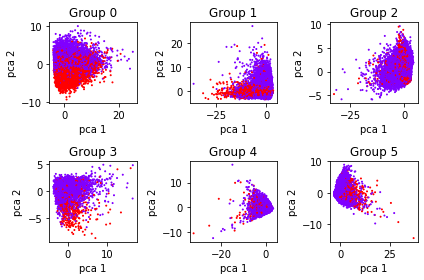

In [15]:
import matplotlib.cm as cm

num_row = 2
num_col = int(np.ceil(len(tX_split)/num_row))
f, axs = plt.subplots(num_row, num_col)


for ind, tX_group in enumerate(tX_split):
    tX_group_pca = pca(tX_group[:,np.std(tX_group,0) > 0]) # The explanatory variables
    """
    # A simple version of the plot where outliers are not removed.
    colors = cm.rainbow(y_split[ind])
    ax.scatter(tX_group_pca[:,0], tX_group_pca[:,1],s=1 , color=colors)
    """
    
    # Identify outliers for improved readibility
    mean_distance_from_centre = np.mean(np.linalg.norm(tX_group_pca[:,[0,1]],axis=1))
    ind_outlier = np.arange(tX_group_pca.shape[0])[np.linalg.norm(tX_group_pca[:,[0,1]],axis=1)>20*mean_distance_from_centre]
    print('group {g} of {ng}, indices of removed outliers : {io}'.format(g = ind+1, ng = len(tX_split), io = ind_outlier))
    
    # Colour points according to classes 'b' ans 's'
    colors = cm.rainbow(np.delete(y_split[ind],ind_outlier))
    
    # Plot pca_1 against pca_2 for each subgroup
    ax = axs[ind // num_col][ind % num_col]
    ax.scatter(np.delete(tX_group_pca[:,0],ind_outlier), np.delete(tX_group_pca[:,1],ind_outlier),s=1 , color=colors)
    ax.set_xlabel("pca 1")
    ax.set_ylabel("pca 2")
    ax.set_title("Group "+str(ind))

plt.tight_layout()
plt.savefig("../plots/pca_1_vs_pca_2_of_pattern_groups")
plt.show()

True detections are labeld red and background purple. The PCA1 vs PCA2 plot suggests that it might be advantageous to perform the weights on each subgroup separately. In the first group for instance, the boson detections are almost separable from the false predictions.

## Distributions of the features (w/o missing values) :

The following plot shows the binned distribution of each feature. Each histogram bar is colored according to the ratio #signal/(#signal+#background) of observations in the corresponding bin. The colors of the bins reflect the proportions of y = 1 to y = -1 inside each bin. Yellow indicates y = 1 and blue indicates y = -1.

In [16]:
nb_bins = 40
plot_distribution_features_color_fraction_signal_binned(tX,y,nb_bins)

../utilities/functions_for_complex_analysis.py:46: RuntimeWarning: invalid value encountered in true_divide
  frac_s = nb_s_bin/(nb_bg_bin+nb_s_bin)
../utilities/plots.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Feature number 22 takes discrete values, it can only be 0. 1. 2. or 3. We also notice the similarity distributions of the features 10, 22 and 30 for which we previously identified strong correlations. Their distribution resembles that of an exponential decay. The colors suggest that some values are strongly correlated with observing a signal or just background. This was exploited in the section "Prediction based on binned signal fraction".

#### Boxplot of features

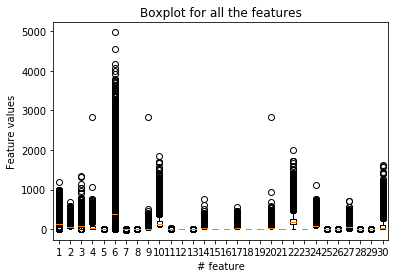

In [17]:
fig2, ax2 = plt.subplots()
ax2.set_title('Boxplot for all the features')
ax2.boxplot(tX_missing_val_replaced)
ax2.set_ylabel("Feature values")
ax2.set_xlabel("# feature")
plt.savefig("../plots/boxplots_of_all_features")
plt.show()

We see the feature number six has a very large variance compared to the others.

# Global data preprocessing :

In [18]:
x, mean_x, std_x = standardize(tX)
tX = adding_offset(x)
xtrain,ytrain,xtest,ytest=split_data(tX,y,0.9)
pX=add_higher_degree_terms(x,5)#equivalent to building poly in multiple dimensions
pX=adding_offset(x)
xtrainpol,ytrainpol,xtestpol,ytestpol=split_data(pX, y, 0.9) #on polynomial version,with ratio = 0.9 and default seed=1

### Interactions between variables

In [19]:
x = np.array([[1,2,3],[4,5,6]])
print("x :\n",x,"\n")
print("add_square_terms(x) : \n",add_square_terms(x),"\n")
print("add_higher_degree_terms(x, 3) : \n",add_higher_degree_terms(x, 3),"\n")
print("add_higher_degree_terms_customized(x, (3,4)) : \n",add_higher_degree_terms_customized(x, (3,4)),"\n")
print("add_interaction_terms(x) : \n",add_interaction_terms(x))

x :
 [[1 2 3]
 [4 5 6]] 

add_square_terms(x) : 
 [[ 1  2  3  1  4  9]
 [ 4  5  6 16 25 36]] 

add_higher_degree_terms(x, 3) : 
 [[  1   2   3   1   4   9   1   8  27]
 [  4   5   6  16  25  36  64 125 216]] 

add_higher_degree_terms_customized(x, (3,4)) : 
 [[   1    2    3    1    8   27    1   16   81]
 [   4    5    6   64  125  216  256  625 1296]] 

add_interaction_terms(x) : 
 [[ 1  2  3  1  2  3  4  6  9]
 [ 4  5  6 16 20 24 25 30 36]]


Here is a preview of the various feature expansions methods that were used later on.

# Standard implementations

## Least squares gradient descent :

In [20]:
initial_w = np.zeros(np.shape(tX)[1])
gamma = 0.05
max_iters = 1000
final_w_gd, final_loss_gd = least_squares_GD(y, tX, initial_w, max_iters, gamma)

Gradient Descent(1000/1000): loss=0.3871765009935876, w0=-0.054869666689634805, w1=0.18545266309126635


## Least squares stochastic gradient descent :

In [21]:
gamma = 0.005
max_iters = 500
final_w_sgd, final_loss_sgd = least_squares_SGD(y, tX, initial_w, max_iters, gamma)

Gradient Descent(500/500): loss=0.43883791575075315, w0=-0.10467424644579575, w1=0.20916591234117912


## Least squares with normal equation  

In [22]:
w_ne,loss_ne= least_squares(y, tX)

Loss=0.3394455984893396, w0=-999.4173451011517, w1=0.031342169911756444


#### on polynomial version of the data set :

In [23]:
w_ne_pol, loss_ne_pol = least_squares(y, pX)

Loss=0.3394455984893396, w0=-999.4173451011517, w1=0.031342169911756444


#### and with split of test and train data :

In [24]:
w_ne_pol_train, loss_ne_pol_train=least_squares(ytrainpol, xtrainpol)
rmse_ne_pol_train=rmse(loss_ne_pol_train)
loss_ne_pol_test= compute_loss_linear(ytestpol, xtestpol, w_ne_pol_train)
rmse_ne_pol_test=rmse(loss_ne_pol_test)
print(" Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(tr=rmse_ne_pol_train, te=rmse_ne_pol_test))

Loss=0.33924422861263215, w0=-1584.1845283059572, w1=0.03149827750621196
 Training RMSE=0.824, Testing RMSE=0.826


## Ridge regression :

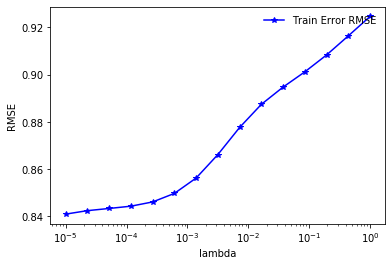

In [25]:
lambdas = np.logspace(-5, 0, 15)
rmse_rr = []
for ind, lambda_ in enumerate(lambdas):
        w_rr,loss_rr = ridge_regression(y, tX, lambda_)
        rmse_rr.append(rmse(loss_rr))

plot_implementation(rmse_rr, lambdas)

#### on polynomial version of the data set :

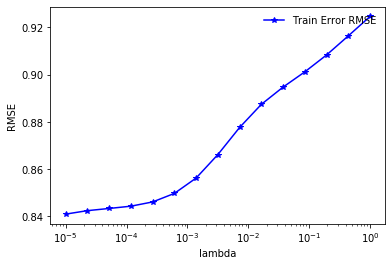

In [26]:
lambdas = np.logspace(-5, 0, 15)
rmse_rr_pol = []
for ind, lambda_ in enumerate(lambdas):
        w_rr_pol,loss_rr_pol = ridge_regression(y, pX, lambda_)
        rmse_rr_pol.append(rmse(loss_rr_pol))

plot_implementation(rmse_rr_pol, lambdas)

Feature expansion doesn't seem to be able to decrease the error in this specific case

#### and with split of test and train data :

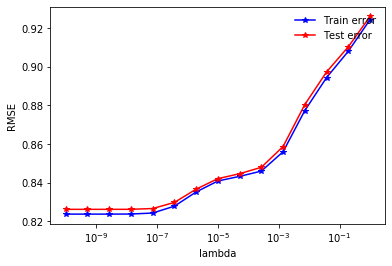

In [27]:
lambdas = np.logspace(-10, 0, 15)
rmse_rr_pol_train = []
rmse_rr_pol_test = []
for ind, lambda_ in enumerate(lambdas):
        w_rr_pol,loss_rr_pol_train = ridge_regression(ytrainpol,xtrainpol , lambda_)
        rmse_rr_pol_train.append(rmse(loss_rr_pol_train))
        rmse_rr_pol_test.append(rmse(compute_loss_linear(ytestpol,xtestpol,w_rr_pol)))
plot_train_test(rmse_rr_pol_train, rmse_rr_pol_test, lambdas)

The plot is normal. We get almost exactly the same error for the train and test set, this is due to the fact that we have a very large set of samples and we select 10% of test for training, with these large numbers, the differences between the test and train sample average out and there isn't any overfitting.

## Logistic regression

### Logistic regression using gradient descent

We have to rescale y to get it between 0 and 1 for the loss function ot work properly. Moreover, this method is very sensitive so we start already with a good approximation of the weights that we get fro the methods used previously.

In [28]:
initial_w = w_ne_pol_train
max_iters = 10
gamma=0.000001
w_lr,loss_lr=logistic_regression(rescale_y(y), tX, initial_w, max_iters,gamma)
a = rmse_logistic(rescale_y(y)-compute_p(w_lr,tX),tX)
print("Root mean square error: ",a)

Root mean square error:  0.42803170951522035


#### With split of train and test data :

In [29]:
max_iters = 100
gamma=0.0000001
w_lr_pol,loss_lr_pol_train = logistic_regression(rescale_y(ytrainpol),xtrainpol,initial_w, max_iters,gamma)
rmse_lr_pol_train = rmse_logistic(rescale_y(ytrainpol)-compute_p(w_lr_pol,xtrainpol),xtrainpol)
rmse_lr_pol_test = rmse_logistic(rescale_y(ytestpol)-compute_p(w_lr_pol,xtestpol),xtestpol)
print("Root mean square error for test: {te:.3f} and train: {tr:.3f} ".format(tr=rmse_lr_pol_train, te=rmse_lr_pol_test))

Root mean square error for test: 0.429 and train: 0.428 


### Logistic regression using Newton

In [30]:
max_iters = 50
gamma = 0.01
w_lrn, loss_lrn=logistic_regression_newton(rescale_y(y),tX,initial_w,max_iters,gamma)
a = rmse_logistic(rescale_y(y)-compute_p(w_lrn,tX),tX)
print("Root mean square error: ",a)

Root mean square error:  0.4190968553662343


We see that Logistic regression using the Newton method performs better than Gradient Descent.

#### on polynomial version of the data set :

In [31]:
w_lrn_pol, loss_lrn=logistic_regression_newton(rescale_y(y),pX,initial_w,max_iters,gamma)
a = rmse_logistic(rescale_y(y)-compute_p(w_lrn_pol,pX),pX)
print("Root mean square error: ",a)

Root mean square error:  0.4190968553662343


### Regularized logistic regression

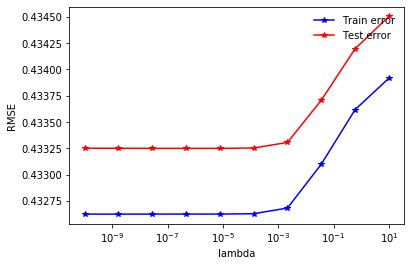

In [33]:
max_iters = 10
gamma = 0.01
lambdas = np.logspace(-10, 1, 10)
rmse_rr_pol_train = []
rmse_rr_pol_test = []
for ind, lambda_ in enumerate(lambdas):
        w_rr_pol,loss_rr_pol_train = reg_logistic_regression(rescale_y(ytrainpol),xtrainpol ,lambda_,initial_w,max_iters,gamma)
        rmse_rr_pol_train.append(rmse_logistic(rescale_y(ytrainpol)-compute_p(w_rr_pol,xtrainpol),xtrainpol))
        rmse_rr_pol_test.append(rmse_logistic(rescale_y(ytestpol)-compute_p(w_rr_pol,xtestpol),xtestpol))
plot_train_test(rmse_rr_pol_train, rmse_rr_pol_test, lambdas)

With an optimal lambda: 

In [34]:
lambdas[np.argmin(rmse_rr_pol_test)]

4.641588833612782e-07

Remark: to be able to compare the train et test losses, we have to calculate both of them using the same loss function, we opted for the rmse loss function as it's value is on the same scale as the output

#### End of the required implementations : we now focus on optimization using combination of pattern splitting, feature expansion, cross validation and logistic regression

In [35]:
# Loading the data again for it has been processed above
DATA_TRAIN_PATH = '../../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
DATA_TEST_PATH = "../../data/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

## Prediction based on binned signal fraction

This section takes up an idea developped in the section 'distribution of features' during the exploratory data analysis. If just the information contained in the colors is displayed, it seem already quite rich:

In [36]:
nb_bins = 30

In [37]:
plot_features_fraction_signal_binned(tX,y,nb_bins)

../utilities/functions_for_complex_analysis.py:46: RuntimeWarning: invalid value encountered in true_divide
  frac_s = nb_s_bin/(nb_bg_bin+nb_s_bin)


Based on the (somewhat implausible) assumption that the features' values are independent from each other, one can make a naive prediction of the y-value. For each feature one can take the ratio of number of signal detection over the total number of observations in each bin as an estimate for a 'pseudo likelihood'. The result is a matrix which allows the classification of a new data set. For any new value, one can just look up what the combined likelihood of all its features amounts to. But there are obvious disadvantages:

- Not all bins contain enough samples for us to be confident that the estimated 'pseudo likelihood' is accurate. Some bins don't even contain a single element. Based on the plot one could probably guess in many cases estimates are accurate and what missing values should be. A solution could be to fit a curve through the points. Here, for reasons of simplicity, the missing 'pseudo likelihoods' were arbitrarily set to 1/2.
- A new data set is likely to contain features with values smaller than the minimum or larger than the maximum in the training samples. The 'pseudo likelihood' of them is simply taken to be the 'pseudo likelihood' of the bin corresponding to the minimum and the maximum in the training set.

Some features contain -999s that were excluded in the plot above. A solution would be to place them into a separate bin. Here they were not included in the analysis at all. However, if for some features no likelihood is attributed, the product of the remaining (supposedly independent) is expected to be different in groups with different patterns of missing values. Therefore the prediction of a y-value must be separated by those groups.
The sum of the 'pseudo log likelihoods' is merely a number. For each group a threshold must be found that optimally separates signal from background based on the 'pseudo log likelihood' score of a sample. To find these thresholds, the 'pseudo likelihood' method is applied on the training set. The optimal threshold is taken to be the one maximizing the Matthews correlation coefficient.

In [38]:
thresholds_likelihood_groups = find_threshold_pseudo_likelihood_method_groups(tX,y,nb_bins)
with np.printoptions(precision=3, suppress=False):
    print("The groups' optimal thresholds are :\n\n",thresholds_likelihood_groups)

../utilities/functions_for_complex_analysis.py:122: RuntimeWarning: divide by zero encountered in log
  y_pseudo_likelihood_pred_groups_test.append(np.nan_to_num(np.sum(np.log(pseudo_likelihoods_groups_test[ind_group]),axis=1)))


The groups' optimal thresholds are :

 [-28.747 -24.107 -22.581 -27.33  -23.512 -22.2  ]


In [39]:
pseudo_likelihoods_binned,shared_bins,tX_cols_no_missing_val = calculate_signal_fraction_features_binned(tX,y,nb_bins)
y_pred_test_binary,y_pred_test = predicition_pseudo_likelihood_method_groups(tX_test,pseudo_likelihoods_binned,shared_bins,thresholds_likelihood_groups)
print("The prediction based on the 'pseudo likelihood' method gives :\n\n - a vector of predictions :\n", y_pred_test_binary)
with np.printoptions(precision=3, suppress=False):
    print("\n - And a 'pseudo log likelihood' vector :\n",y_pred_test)

The prediction based on the 'pseudo likelihood' method gives :

 - a vector of predictions :
 [-1. -1.  1. ...  1.  1. -1.]

 - And a 'pseudo log likelihood' vector :
 [-24.915 -25.97  -22.167 ... -21.501 -23.781 -24.633]


Although this 'naive' prediction with a very limited number of parameters to optimize is not all too bad, it clearly has its limits. The values of the different features are in general not independent. One would need to take the interactions between feature into account. However, it will become very unlikely to fill any of the multidimenional blocks with enough observations to get a good estimate of the likelihood. If one droped then the binning, the approach would naturally generalize to the k-nearest-neighbors algorithm.

# Best version : 6 Patterns of missing values, interactions between variables and logistic regession

## Tuning hyperparameters

Previously, the need for different treatment of each subgroup with its specific pattern of missing values when it comes to feature engineering became apparent. To justify and improve the empirically gained intuition for feature engineering, we preceed by tuning the hyperparameters for each subgroup in order to be able to compare different models. For reasons of simplicity and computational limitations we restrict ourselves to adding polynomial terms of each explanatory variables up to a certain degree to our data. Other interactions between different explanatory variables remain unaccounted for. Taking into account models where certain polynomial terms are left out would lead to a combinatorial explosion. Since a ridge term was included in the logistic regression, the weights corresponding to the terms with little predictive power, determined based on the data, are expected be to close to zero anyhow.

In [40]:
from proj1_helpers import *
DATA_TRAIN_PATH = "../../data/train.csv"
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

tX_split, ind_row_groups, groups_mv_num = split_data_according_to_pattern_of_missing_values(tX) 

For possible values of the ridge term lambda and the maximal degree up to which polynomial terms of the explanatory variables are added to the data, the data gets split multiple times into a training and a testing set. The optimal weights are determined by penalized logistic regression using the Newton-Raphson method and the error of the prediction for both training and testing predictions are obtained.

In [41]:
seeds = range(5)
max_iters = 10
threshold = 10**(-5)
lambdas = np.logspace(-4, 0, 30)
gamma = 1
split_ratios = [0.9]
degree_max = 10
degrees = range(1,degree_max+1)

In [ ]:
rmse_tr, rmse_te, abse_tr, abse_te = train_test_split_logistic_regression_feature_engineering_ridge_groups_demo(tX, y, degrees, split_ratios, seeds, max_iters, threshold, lambdas, gamma)

#we now save the results in a numpy file                
np.save('../results_of_lengthy_computations/errors_tuning_parameters_penalized_logistic_regression_basic_feature_expansion',np.array([rmse_tr, rmse_te, abse_tr, abse_te]))

Remark: the following computation to tune the hyperparameter is very costly so we savec the resultsin a numpy file. So it is not necessary to run the next cell to get the results.

...and can be recovered without going through the computations by excecuting the following line :

In [42]:
rmse_tr, rmse_te, abse_tr, abse_te = np.load('../results_of_lengthy_computations/errors_tuning_parameters_penalized_logistic_regression_basic_feature_expansion.npy')

In [43]:
ind_lambda_min_mean_rmse_te = np.argmin(np.mean(rmse_te,axis = 2),axis = 3)[:,0]

In [44]:
ind_lambda_min_median_rmse_te = np.argmin(np.median(rmse_te,axis = 2),axis = 3)[:,0]

As there are many outliers where the weights didn't converge well and the variance is otherwise in most groups fairly low, taking the lambda minimizing the median of the error for each value of the maximal degree of polynomial terms added might be more appropriate.

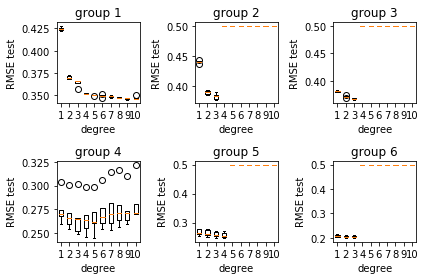

In [45]:
num_col = 3
num_row = int(np.ceil(rmse_te.shape[0]/num_col))

for ind_split_ratio in range(len(split_ratios)):
    f, axs = plt.subplots(num_row, num_col)
    ind_lambda_min_median_rmse_te = np.argmin(np.median(rmse_te[:,ind_split_ratio,:,:,:],axis = 1),axis = 2)

    for ind_group in range(rmse_te.shape[0]):
        box_plot_data = rmse_te[ind_group,ind_split_ratio,:,np.arange(len(degrees)),ind_lambda_min_median_rmse_te[ind_group]]        
        ax = axs[ind_group // num_col][ind_group % num_col]
        ax.boxplot(box_plot_data.T)
        ax.set_title("group "+str(ind_group+1))
        ax.set_xticklabels(np.around(ax.get_xticks(),2))
        ax.set_xlabel("degree")
        ax.set_ylabel("RMSE test")

    plt.tight_layout()
    plt.savefig("../plots/boxplot_error_groups_penalized_logistic_regression_basic_feature_engineering_median_split_ratio_" + str(split_ratios[ind_split_ratio]).replace('.','_'))
    plt.show()

For each subgroup the degree up to which adding polynomial terms of the explanatory minimizes the RMSE can then be determined. Note that the result is robust insofar as taking the lambda that minimizes the mean or median of the RMSE does not matter for the choice of the groups' degrees. The values of the optimal lambdas however is sensitive to that distinction.

In [46]:
ind_split_ratio = 0
ind_lambda_min_mean_rmse_te = np.argmin(np.mean(rmse_te[:,ind_split_ratio,:,:,:],axis = 1),axis = 2)
ind_degrees_mean_star =np.argmin(np.mean(rmse_te[np.meshgrid(range(len(degrees)),range(len(ind_row_groups)))[1].flatten(),ind_split_ratio,:,np.meshgrid(range(len(degrees)),range(len(ind_row_groups)))[0].ravel(),ind_lambda_min_mean_rmse_te.flatten()],axis = 1).reshape([6,10]),axis=1)
degrees_mean_star = ind_degrees_mean_star + 1

ind_lambdas_mean_star = ind_lambda_min_mean_rmse_te[np.arange(ind_lambda_min_mean_rmse_te.shape[0]),ind_degrees_mean_star]

with np.printoptions(precision=3, suppress=False):
    print("The groups' mean testing RMSE for is minimal \n - for lambdas : ",lambdas[ind_lambdas_mean_star]," \n - and degrees : ",degrees_mean_star)

The groups' mean testing RMSE for is minimal 
 - for lambdas :  [1.000e-04 2.043e-01 1.374e-04 4.520e-03 1.000e+00 1.000e-04]  
 - and degrees :  [9 3 3 4 4 3]


In [47]:
ind_split_ratio = 0
ind_lambda_min_median_rmse_te = np.argmin(np.median(rmse_te[:,ind_split_ratio,:,:,:],axis = 1),axis = 2)
ind_degrees_median_star = np.argmin(np.mean(rmse_te[np.meshgrid(range(len(degrees)),range(len(ind_row_groups)))[1].ravel(),ind_split_ratio,:,np.meshgrid(range(len(degrees)),range(len(ind_row_groups)))[0].ravel(),ind_lambda_min_median_rmse_te.ravel()],axis = 1).reshape([6,10]),axis=1)
degrees_median_star = ind_degrees_median_star + 1
ind_lambdas_median_star = ind_lambda_min_median_rmse_te[np.arange(ind_lambda_min_median_rmse_te.shape[0]),ind_degrees_median_star]

with np.printoptions(precision=3, suppress=False):
    print("The groups' median testing RMSE for is minimal \n - for lambdas : ",lambdas[ind_lambdas_median_star]," \n - and degrees : ",degrees_median_star)


The groups' median testing RMSE for is minimal 
 - for lambdas :  [4.520e-03 2.043e-01 1.374e-04 9.237e-04 1.000e-04 1.000e-04]  
 - and degrees :  [9 3 3 4 4 3]


Except for group four (first column, second row in the boxplots above), each group seems to have an apparent optimal degree up to which polynomial terms should be added. As optimizing the degrees added and the ridge term simultaneously requires a lot of computational power, it is not possible to go through many rounds of splitting, testing and training. Thus, instead of simply extracting each group's lambda in addition to the optimal degree from the data generated above, a k-fold cross validation was performed subsequently. 

In [48]:
seed = 50
max_iters = 20
threshold = 10**(-8)
lambdas = np.logspace(-5, 0, 50)
gamma = 1
k_fold = 20

In [81]:
rmse_tr = np.zeros([len(ind_row_groups),k_fold,len(lambdas)])
rmse_te = np.zeros([len(ind_row_groups),k_fold,len(lambdas)])
abse_tr = np.zeros([len(ind_row_groups),k_fold,len(lambdas)])
abse_te = np.zeros([len(ind_row_groups),k_fold,len(lambdas)])


for ind_group, ind_row_group in enumerate(ind_row_groups):
    print('group (' + str(ind_group + 1) + '/' + str(len(groups_mv_num)) + ')') 
    k_indices = build_k_indices(rescale_y(y[ind_row_group]), k_fold, seed)
    for k in range(k_fold):
        rmse_tr[ind_group,k,:],rmse_te[ind_group,k,:],abse_tr[ind_group,k,:],abse_te[ind_group,k,:] = cross_validation_logistic_regression_feature_engineering_ridge(tX[ind_row_group], rescale_y(y[ind_row_group]), degrees_median_star[ind_group], k_indices, k, max_iters, threshold, lambdas, gamma)

np.save('../results_of_lengthy_computations/errors_tuning_lambda_penalized_logistic_regression_basic_feature_expansion',np.array([rmse_tr, rmse_te, abse_tr, abse_te]))

group (1/6)
underflow encountered in multiply
degree=9, k=0, lambda= 1.000e-05, Training RMSE=0.343, Testing RMSE=0.343, Training loss=24412.791, Testing loss=1366.748, Training # Missclassification =10793.000, Testing # Missclassification=568.000
underflow encountered in multiply
degree=9, k=0, lambda= 1.265e-05, Training RMSE=0.343, Testing RMSE=0.343, Training loss=24412.869, Testing loss=1365.714, Training # Missclassification =10794.000, Testing # Missclassification=567.000
underflow encountered in multiply
degree=9, k=0, lambda= 1.600e-05, Training RMSE=0.343, Testing RMSE=0.343, Training loss=24412.968, Testing loss=1364.255, Training # Missclassification =10794.000, Testing # Missclassification=567.000
underflow encountered in multiply
degree=9, k=0, lambda= 2.024e-05, Training RMSE=0.343, Testing RMSE=0.343, Training loss=24415.834, Testing loss=1307.147, Training # Missclassification =10800.000, Testing # Missclassification=565.000
underflow encountered in multiply
degree=9, 

underflow encountered in multiply
degree=9, k=0, lambda= 3.728e-02, Training RMSE=0.344, Testing RMSE=0.343, Training loss=24432.421, Testing loss=1323.622, Training # Missclassification =10812.000, Testing # Missclassification=567.000
underflow encountered in multiply
degree=9, k=0, lambda= 4.715e-02, Training RMSE=0.344, Testing RMSE=0.343, Training loss=24436.531, Testing loss=1301.353, Training # Missclassification =10818.000, Testing # Missclassification=568.000
underflow encountered in multiply
degree=9, k=0, lambda= 5.964e-02, Training RMSE=0.344, Testing RMSE=0.343, Training loss=24436.328, Testing loss=1299.221, Training # Missclassification =10818.000, Testing # Missclassification=567.000
underflow encountered in multiply
degree=9, k=0, lambda= 7.543e-02, Training RMSE=0.344, Testing RMSE=0.343, Training loss=24436.852, Testing loss=1324.376, Training # Missclassification =10809.000, Testing # Missclassification=567.000
underflow encountered in multiply
degree=9, k=0, lambda=

underflow encountered in multiply
degree=9, k=1, lambda= 1.389e-03, Training RMSE=0.343, Testing RMSE=0.340, Training loss=24417.436, Testing loss=inf, Training # Missclassification =10806.000, Testing # Missclassification=565.000
underflow encountered in multiply
degree=9, k=1, lambda= 1.758e-03, Training RMSE=0.344, Testing RMSE=0.340, Training loss=24417.698, Testing loss=inf, Training # Missclassification =10810.000, Testing # Missclassification=565.000
underflow encountered in multiply
degree=9, k=1, lambda= 2.223e-03, Training RMSE=0.344, Testing RMSE=0.340, Training loss=24417.999, Testing loss=inf, Training # Missclassification =10808.000, Testing # Missclassification=565.000
underflow encountered in multiply
degree=9, k=1, lambda= 2.812e-03, Training RMSE=0.344, Testing RMSE=0.340, Training loss=24418.399, Testing loss=inf, Training # Missclassification =10810.000, Testing # Missclassification=566.000
underflow encountered in multiply
degree=9, k=1, lambda= 3.556e-03, Training

underflow encountered in multiply
degree=9, k=2, lambda= 5.179e-05, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24351.992, Testing loss=1344.378, Training # Missclassification =10735.000, Testing # Missclassification=608.000
underflow encountered in multiply
degree=9, k=2, lambda= 6.551e-05, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24352.466, Testing loss=1344.306, Training # Missclassification =10741.000, Testing # Missclassification=609.000
underflow encountered in multiply
degree=9, k=2, lambda= 8.286e-05, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24352.984, Testing loss=1344.260, Training # Missclassification =10738.000, Testing # Missclassification=611.000
underflow encountered in multiply
degree=9, k=2, lambda= 1.048e-04, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24353.537, Testing loss=1344.226, Training # Missclassification =10738.000, Testing # Missclassification=611.000
underflow encountered in multiply
degree=9, k=2, lambda=

underflow encountered in multiply
degree=9, k=2, lambda= 1.931e-01, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24386.729, Testing loss=1345.111, Training # Missclassification =10763.000, Testing # Missclassification=615.000
underflow encountered in multiply
degree=9, k=2, lambda= 2.442e-01, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24389.729, Testing loss=1345.132, Training # Missclassification =10761.000, Testing # Missclassification=615.000
underflow encountered in multiply
degree=9, k=2, lambda= 3.089e-01, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24388.917, Testing loss=1343.815, Training # Missclassification =10737.000, Testing # Missclassification=614.000
underflow encountered in multiply
degree=9, k=2, lambda= 3.907e-01, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24393.080, Testing loss=1344.355, Training # Missclassification =10741.000, Testing # Missclassification=616.000
underflow encountered in multiply
degree=9, k=2, lambda=

underflow encountered in multiply
degree=9, k=3, lambda= 5.690e-03, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24491.995, Testing loss=1273.316, Training # Missclassification =10846.000, Testing # Missclassification=556.000
underflow encountered in multiply
degree=9, k=3, lambda= 7.197e-03, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24492.712, Testing loss=1273.508, Training # Missclassification =10848.000, Testing # Missclassification=556.000
underflow encountered in multiply
degree=9, k=3, lambda= 9.103e-03, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24493.506, Testing loss=1273.709, Training # Missclassification =10854.000, Testing # Missclassification=557.000
underflow encountered in multiply
degree=9, k=3, lambda= 1.151e-02, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24494.348, Testing loss=1273.890, Training # Missclassification =10855.000, Testing # Missclassification=554.000
underflow encountered in multiply
degree=9, k=3, lambda=

underflow encountered in multiply
degree=9, k=4, lambda= 1.677e-04, Training RMSE=0.344, Testing RMSE=0.337, Training loss=24439.418, Testing loss=1259.113, Training # Missclassification =10797.000, Testing # Missclassification=536.000
underflow encountered in multiply
degree=9, k=4, lambda= 2.121e-04, Training RMSE=0.344, Testing RMSE=0.337, Training loss=24439.610, Testing loss=1259.277, Training # Missclassification =10798.000, Testing # Missclassification=536.000
underflow encountered in multiply
degree=9, k=4, lambda= 2.683e-04, Training RMSE=0.344, Testing RMSE=0.337, Training loss=24439.785, Testing loss=1259.361, Training # Missclassification =10796.000, Testing # Missclassification=536.000
underflow encountered in multiply
degree=9, k=4, lambda= 3.393e-04, Training RMSE=0.344, Testing RMSE=0.337, Training loss=24439.949, Testing loss=1259.363, Training # Missclassification =10798.000, Testing # Missclassification=536.000
underflow encountered in multiply
degree=9, k=4, lambda=

underflow encountered in multiply
degree=9, k=4, lambda= 6.251e-01, Training RMSE=0.344, Testing RMSE=0.338, Training loss=24492.435, Testing loss=1259.538, Training # Missclassification =10846.000, Testing # Missclassification=541.000
underflow encountered in multiply
degree=9, k=4, lambda= 7.906e-01, Training RMSE=0.344, Testing RMSE=0.338, Training loss=24498.646, Testing loss=1261.191, Training # Missclassification =10835.000, Testing # Missclassification=542.000
underflow encountered in multiply
degree=9, k=4, lambda= 1.000e+00, Training RMSE=0.344, Testing RMSE=0.338, Training loss=24505.290, Testing loss=1261.814, Training # Missclassification =10827.000, Testing # Missclassification=543.000
underflow encountered in multiply
degree=9, k=5, lambda= 1.000e-05, Training RMSE=0.343, Testing RMSE=0.345, Training loss=24373.055, Testing loss=1312.035, Training # Missclassification =10789.000, Testing # Missclassification=567.000
underflow encountered in multiply
degree=9, k=5, lambda=

underflow encountered in multiply
degree=9, k=5, lambda= 1.842e-02, Training RMSE=0.343, Testing RMSE=0.345, Training loss=24385.864, Testing loss=1312.956, Training # Missclassification =10788.000, Testing # Missclassification=573.000
underflow encountered in multiply
degree=9, k=5, lambda= 2.330e-02, Training RMSE=0.343, Testing RMSE=0.346, Training loss=24390.145, Testing loss=1357.574, Training # Missclassification =10797.000, Testing # Missclassification=571.000
underflow encountered in multiply
degree=9, k=5, lambda= 2.947e-02, Training RMSE=0.343, Testing RMSE=0.346, Training loss=24393.605, Testing loss=1354.087, Training # Missclassification =10804.000, Testing # Missclassification=571.000
underflow encountered in multiply
degree=9, k=5, lambda= 3.728e-02, Training RMSE=0.343, Testing RMSE=0.345, Training loss=24390.564, Testing loss=1312.750, Training # Missclassification =10788.000, Testing # Missclassification=570.000
underflow encountered in multiply
degree=9, k=5, lambda=

underflow encountered in multiply
degree=9, k=6, lambda= 5.429e-04, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24382.211, Testing loss=1311.115, Training # Missclassification =10793.000, Testing # Missclassification=560.000
underflow encountered in multiply
degree=9, k=6, lambda= 6.866e-04, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24382.532, Testing loss=1311.092, Training # Missclassification =10793.000, Testing # Missclassification=560.000
underflow encountered in multiply
degree=9, k=6, lambda= 8.685e-04, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24382.837, Testing loss=1311.064, Training # Missclassification =10791.000, Testing # Missclassification=560.000
underflow encountered in multiply
degree=9, k=6, lambda= 1.099e-03, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24383.151, Testing loss=1311.032, Training # Missclassification =10795.000, Testing # Missclassification=560.000
underflow encountered in multiply
degree=9, k=6, lambda=

underflow encountered in multiply
degree=9, k=7, lambda= 1.600e-05, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24368.747, Testing loss=1317.142, Training # Missclassification =10791.000, Testing # Missclassification=590.000
underflow encountered in multiply
degree=9, k=7, lambda= 2.024e-05, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24370.064, Testing loss=1316.767, Training # Missclassification =10788.000, Testing # Missclassification=588.000
underflow encountered in multiply
degree=9, k=7, lambda= 2.560e-05, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24369.054, Testing loss=1317.210, Training # Missclassification =10794.000, Testing # Missclassification=589.000
underflow encountered in multiply
degree=9, k=7, lambda= 3.237e-05, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24369.269, Testing loss=1317.252, Training # Missclassification =10796.000, Testing # Missclassification=589.000
underflow encountered in multiply
degree=9, k=7, lambda=

underflow encountered in multiply
degree=9, k=7, lambda= 5.964e-02, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24389.217, Testing loss=1318.965, Training # Missclassification =10798.000, Testing # Missclassification=582.000
underflow encountered in multiply
degree=9, k=7, lambda= 7.543e-02, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24390.086, Testing loss=1319.273, Training # Missclassification =10804.000, Testing # Missclassification=585.000
underflow encountered in multiply
degree=9, k=7, lambda= 9.541e-02, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24393.324, Testing loss=1318.959, Training # Missclassification =10806.000, Testing # Missclassification=582.000
underflow encountered in multiply
degree=9, k=7, lambda= 1.207e-01, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24393.193, Testing loss=1319.614, Training # Missclassification =10810.000, Testing # Missclassification=583.000
underflow encountered in multiply
degree=9, k=7, lambda=

underflow encountered in multiply
degree=9, k=8, lambda= 1.758e-03, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24339.126, Testing loss=inf, Training # Missclassification =10774.000, Testing # Missclassification=599.000
underflow encountered in multiply
degree=9, k=8, lambda= 2.223e-03, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24339.429, Testing loss=inf, Training # Missclassification =10777.000, Testing # Missclassification=599.000
underflow encountered in multiply
degree=9, k=8, lambda= 2.812e-03, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24339.799, Testing loss=inf, Training # Missclassification =10778.000, Testing # Missclassification=599.000
underflow encountered in multiply
degree=9, k=8, lambda= 3.556e-03, Training RMSE=0.343, Testing RMSE=0.353, Training loss=24340.256, Testing loss=inf, Training # Missclassification =10780.000, Testing # Missclassification=599.000
underflow encountered in multiply
degree=9, k=8, lambda= 4.498e-03, Training

underflow encountered in multiply
degree=9, k=9, lambda= 6.551e-05, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24377.191, Testing loss=1314.462, Training # Missclassification =10767.000, Testing # Missclassification=583.000
underflow encountered in multiply
degree=9, k=9, lambda= 8.286e-05, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24377.713, Testing loss=1314.434, Training # Missclassification =10773.000, Testing # Missclassification=583.000
underflow encountered in multiply
degree=9, k=9, lambda= 1.048e-04, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24378.256, Testing loss=1314.413, Training # Missclassification =10776.000, Testing # Missclassification=582.000
underflow encountered in multiply
degree=9, k=9, lambda= 1.326e-04, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24375.050, Testing loss=1314.738, Training # Missclassification =10781.000, Testing # Missclassification=582.000
underflow encountered in multiply
degree=9, k=9, lambda=

underflow encountered in multiply
degree=9, k=9, lambda= 2.442e-01, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24406.561, Testing loss=1313.123, Training # Missclassification =10799.000, Testing # Missclassification=586.000
underflow encountered in multiply
degree=9, k=9, lambda= 3.089e-01, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24411.829, Testing loss=1313.124, Training # Missclassification =10802.000, Testing # Missclassification=587.000
underflow encountered in multiply
degree=9, k=9, lambda= 3.907e-01, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24415.845, Testing loss=1313.335, Training # Missclassification =10795.000, Testing # Missclassification=590.000
underflow encountered in multiply
degree=9, k=9, lambda= 4.942e-01, Training RMSE=0.343, Testing RMSE=0.349, Training loss=24425.472, Testing loss=1313.142, Training # Missclassification =10794.000, Testing # Missclassification=586.000
underflow encountered in multiply
degree=9, k=9, lambda=

underflow encountered in multiply
degree=9, k=10, lambda= 9.103e-03, Training RMSE=0.344, Testing RMSE=0.342, Training loss=24432.061, Testing loss=1316.034, Training # Missclassification =10785.000, Testing # Missclassification=582.000
underflow encountered in multiply
degree=9, k=10, lambda= 1.151e-02, Training RMSE=0.344, Testing RMSE=0.342, Training loss=24433.234, Testing loss=1315.874, Training # Missclassification =10788.000, Testing # Missclassification=583.000
underflow encountered in multiply
degree=9, k=10, lambda= 1.456e-02, Training RMSE=0.344, Testing RMSE=0.342, Training loss=24434.153, Testing loss=1315.949, Training # Missclassification =10785.000, Testing # Missclassification=582.000
underflow encountered in multiply
degree=9, k=10, lambda= 1.842e-02, Training RMSE=0.344, Testing RMSE=0.342, Training loss=24435.862, Testing loss=1315.536, Training # Missclassification =10784.000, Testing # Missclassification=582.000
underflow encountered in multiply
degree=9, k=10, la

underflow encountered in multiply
degree=9, k=11, lambda= 2.683e-04, Training RMSE=0.343, Testing RMSE=0.344, Training loss=24398.339, Testing loss=1484.275, Training # Missclassification =10810.000, Testing # Missclassification=576.000
underflow encountered in multiply
degree=9, k=11, lambda= 3.393e-04, Training RMSE=0.343, Testing RMSE=0.344, Training loss=24398.690, Testing loss=1483.759, Training # Missclassification =10809.000, Testing # Missclassification=575.000
underflow encountered in multiply
degree=9, k=11, lambda= 4.292e-04, Training RMSE=0.343, Testing RMSE=0.344, Training loss=24399.011, Testing loss=1483.234, Training # Missclassification =10806.000, Testing # Missclassification=575.000
underflow encountered in multiply
degree=9, k=11, lambda= 5.429e-04, Training RMSE=0.343, Testing RMSE=0.344, Training loss=24399.301, Testing loss=1482.696, Training # Missclassification =10807.000, Testing # Missclassification=574.000
underflow encountered in multiply
degree=9, k=11, la

underflow encountered in multiply
degree=9, k=11, lambda= 1.000e+00, Training RMSE=0.344, Testing RMSE=0.345, Training loss=24460.111, Testing loss=1316.910, Training # Missclassification =10837.000, Testing # Missclassification=575.000
underflow encountered in multiply
degree=9, k=12, lambda= 1.000e-05, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24350.550, Testing loss=1396.332, Training # Missclassification =10762.000, Testing # Missclassification=584.000
underflow encountered in multiply
degree=9, k=12, lambda= 1.265e-05, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24355.891, Testing loss=1352.215, Training # Missclassification =10766.000, Testing # Missclassification=587.000
underflow encountered in multiply
degree=9, k=12, lambda= 1.600e-05, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24350.729, Testing loss=1396.079, Training # Missclassification =10761.000, Testing # Missclassification=584.000
underflow encountered in multiply
degree=9, k=12, la

underflow encountered in multiply
degree=9, k=12, lambda= 2.947e-02, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24370.056, Testing loss=1366.947, Training # Missclassification =10781.000, Testing # Missclassification=594.000
underflow encountered in multiply
degree=9, k=12, lambda= 3.728e-02, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24371.305, Testing loss=1366.887, Training # Missclassification =10783.000, Testing # Missclassification=594.000
underflow encountered in multiply
degree=9, k=12, lambda= 4.715e-02, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24369.457, Testing loss=1390.176, Training # Missclassification =10790.000, Testing # Missclassification=593.000
underflow encountered in multiply
degree=9, k=12, lambda= 5.964e-02, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24376.544, Testing loss=1350.609, Training # Missclassification =10790.000, Testing # Missclassification=597.000
underflow encountered in multiply
degree=9, k=12, la

underflow encountered in multiply
degree=9, k=13, lambda= 8.685e-04, Training RMSE=0.343, Testing RMSE=0.346, Training loss=24397.321, Testing loss=inf, Training # Missclassification =10789.000, Testing # Missclassification=581.000
underflow encountered in multiply
degree=9, k=13, lambda= 1.099e-03, Training RMSE=0.343, Testing RMSE=0.346, Training loss=24397.533, Testing loss=inf, Training # Missclassification =10791.000, Testing # Missclassification=582.000
underflow encountered in multiply
degree=9, k=13, lambda= 1.389e-03, Training RMSE=0.343, Testing RMSE=0.346, Training loss=24397.754, Testing loss=inf, Training # Missclassification =10789.000, Testing # Missclassification=582.000
underflow encountered in multiply
degree=9, k=13, lambda= 1.758e-03, Training RMSE=0.343, Testing RMSE=0.346, Training loss=24397.999, Testing loss=inf, Training # Missclassification =10790.000, Testing # Missclassification=582.000
underflow encountered in multiply
degree=9, k=13, lambda= 2.223e-03, Tra

underflow encountered in multiply
degree=9, k=14, lambda= 3.237e-05, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24422.555, Testing loss=1264.956, Training # Missclassification =10804.000, Testing # Missclassification=564.000
underflow encountered in multiply
degree=9, k=14, lambda= 4.095e-05, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24422.866, Testing loss=1264.948, Training # Missclassification =10810.000, Testing # Missclassification=563.000
underflow encountered in multiply
degree=9, k=14, lambda= 5.179e-05, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24424.905, Testing loss=1265.079, Training # Missclassification =10814.000, Testing # Missclassification=568.000
underflow encountered in multiply
degree=9, k=14, lambda= 6.551e-05, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24423.612, Testing loss=1264.959, Training # Missclassification =10815.000, Testing # Missclassification=563.000
underflow encountered in multiply
degree=9, k=14, la

underflow encountered in multiply
degree=9, k=14, lambda= 1.207e-01, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24445.259, Testing loss=1266.934, Training # Missclassification =10825.000, Testing # Missclassification=562.000
degree=9, k=14, lambda= 1.526e-01, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24447.224, Testing loss=1267.130, Training # Missclassification =10828.000, Testing # Missclassification=564.000
degree=9, k=14, lambda= 1.931e-01, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24449.772, Testing loss=1267.339, Training # Missclassification =10838.000, Testing # Missclassification=564.000
degree=9, k=14, lambda= 2.442e-01, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24452.959, Testing loss=1267.590, Training # Missclassification =10852.000, Testing # Missclassification=565.000
degree=9, k=14, lambda= 3.089e-01, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24456.902, Testing loss=1267.890, Training # Missclassification 

underflow encountered in multiply
degree=9, k=15, lambda= 4.498e-03, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24434.429, Testing loss=inf, Training # Missclassification =10821.000, Testing # Missclassification=551.000
underflow encountered in multiply
degree=9, k=15, lambda= 5.690e-03, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24433.932, Testing loss=9857.950, Training # Missclassification =10833.000, Testing # Missclassification=548.000
underflow encountered in multiply
degree=9, k=15, lambda= 7.197e-03, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24434.494, Testing loss=inf, Training # Missclassification =10833.000, Testing # Missclassification=549.000
underflow encountered in multiply
degree=9, k=15, lambda= 9.103e-03, Training RMSE=0.344, Testing RMSE=0.341, Training loss=24435.444, Testing loss=inf, Training # Missclassification =10836.000, Testing # Missclassification=550.000
underflow encountered in multiply
degree=9, k=15, lambda= 1.151e-02

underflow encountered in multiply
degree=9, k=16, lambda= 1.326e-04, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24369.971, Testing loss=2155.800, Training # Missclassification =10793.000, Testing # Missclassification=587.000
underflow encountered in multiply
degree=9, k=16, lambda= 1.677e-04, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24370.344, Testing loss=2155.561, Training # Missclassification =10785.000, Testing # Missclassification=586.000
underflow encountered in multiply
degree=9, k=16, lambda= 2.121e-04, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24370.703, Testing loss=2155.299, Training # Missclassification =10780.000, Testing # Missclassification=586.000
underflow encountered in multiply
degree=9, k=16, lambda= 2.683e-04, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24371.042, Testing loss=2155.013, Training # Missclassification =10773.000, Testing # Missclassification=587.000
underflow encountered in multiply
degree=9, k=16, la

underflow encountered in multiply
degree=9, k=16, lambda= 4.942e-01, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24416.515, Testing loss=1928.080, Training # Missclassification =10786.000, Testing # Missclassification=587.000
underflow encountered in multiply
degree=9, k=16, lambda= 6.251e-01, Training RMSE=0.344, Testing RMSE=0.351, Training loss=24427.325, Testing loss=1541.855, Training # Missclassification =10775.000, Testing # Missclassification=584.000
underflow encountered in multiply
degree=9, k=16, lambda= 7.906e-01, Training RMSE=0.343, Testing RMSE=0.351, Training loss=24429.590, Testing loss=1902.061, Training # Missclassification =10790.000, Testing # Missclassification=587.000
underflow encountered in multiply
degree=9, k=16, lambda= 1.000e+00, Training RMSE=0.344, Testing RMSE=0.351, Training loss=24436.672, Testing loss=1889.288, Training # Missclassification =10779.000, Testing # Missclassification=587.000
underflow encountered in multiply
degree=9, k=17, la

underflow encountered in multiply
degree=9, k=17, lambda= 1.456e-02, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24379.116, Testing loss=1319.723, Training # Missclassification =10773.000, Testing # Missclassification=583.000
underflow encountered in multiply
degree=9, k=17, lambda= 1.842e-02, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24380.286, Testing loss=1319.825, Training # Missclassification =10766.000, Testing # Missclassification=583.000
underflow encountered in multiply
degree=9, k=17, lambda= 2.330e-02, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24381.809, Testing loss=1320.057, Training # Missclassification =10769.000, Testing # Missclassification=583.000
underflow encountered in multiply
degree=9, k=17, lambda= 2.947e-02, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24383.021, Testing loss=1320.146, Training # Missclassification =10771.000, Testing # Missclassification=583.000
underflow encountered in multiply
degree=9, k=17, la

underflow encountered in multiply
degree=9, k=18, lambda= 4.292e-04, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24383.974, Testing loss=1311.822, Training # Missclassification =10779.000, Testing # Missclassification=571.000
underflow encountered in multiply
degree=9, k=18, lambda= 5.429e-04, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24385.495, Testing loss=1311.658, Training # Missclassification =10770.000, Testing # Missclassification=572.000
underflow encountered in multiply
degree=9, k=18, lambda= 6.866e-04, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24385.808, Testing loss=1311.641, Training # Missclassification =10770.000, Testing # Missclassification=572.000
underflow encountered in multiply
degree=9, k=18, lambda= 8.685e-04, Training RMSE=0.343, Testing RMSE=0.347, Training loss=24384.883, Testing loss=1311.762, Training # Missclassification =10773.000, Testing # Missclassification=570.000
underflow encountered in multiply
degree=9, k=18, la

underflow encountered in multiply
degree=9, k=19, lambda= 1.265e-05, Training RMSE=0.343, Testing RMSE=0.343, Training loss=24413.768, Testing loss=1584.777, Training # Missclassification =10808.000, Testing # Missclassification=586.000
underflow encountered in multiply
degree=9, k=19, lambda= 1.600e-05, Training RMSE=0.343, Testing RMSE=0.343, Training loss=24413.849, Testing loss=1585.379, Training # Missclassification =10806.000, Testing # Missclassification=586.000
underflow encountered in multiply
degree=9, k=19, lambda= 2.024e-05, Training RMSE=0.343, Testing RMSE=0.343, Training loss=24396.251, Testing loss=1499.766, Training # Missclassification =10786.000, Testing # Missclassification=582.000
underflow encountered in multiply
degree=9, k=19, lambda= 2.560e-05, Training RMSE=0.343, Testing RMSE=0.343, Training loss=24396.436, Testing loss=1499.970, Training # Missclassification =10786.000, Testing # Missclassification=583.000
underflow encountered in multiply
degree=9, k=19, la

underflow encountered in multiply
degree=9, k=19, lambda= 4.715e-02, Training RMSE=0.344, Testing RMSE=0.343, Training loss=24418.718, Testing loss=1464.274, Training # Missclassification =10805.000, Testing # Missclassification=584.000
underflow encountered in multiply
degree=9, k=19, lambda= 5.964e-02, Training RMSE=0.344, Testing RMSE=0.343, Training loss=24423.611, Testing loss=1372.328, Training # Missclassification =10806.000, Testing # Missclassification=590.000
underflow encountered in multiply
degree=9, k=19, lambda= 7.543e-02, Training RMSE=0.344, Testing RMSE=0.343, Training loss=24427.226, Testing loss=1398.480, Training # Missclassification =10808.000, Testing # Missclassification=590.000
underflow encountered in multiply
degree=9, k=19, lambda= 9.541e-02, Training RMSE=0.344, Testing RMSE=0.343, Training loss=24433.318, Testing loss=1530.601, Training # Missclassification =10815.000, Testing # Missclassification=588.000
underflow encountered in multiply
degree=9, k=19, la

underflow encountered in multiply
degree=3, k=0, lambda= 1.389e-03, Training RMSE=0.383, Testing RMSE=0.387, Training loss=30726.230, Testing loss=1660.525, Training # Missclassification =14068.000, Testing # Missclassification=772.000
underflow encountered in multiply
degree=3, k=0, lambda= 1.758e-03, Training RMSE=0.383, Testing RMSE=0.387, Training loss=30726.345, Testing loss=1660.507, Training # Missclassification =14073.000, Testing # Missclassification=772.000
underflow encountered in multiply
degree=3, k=0, lambda= 2.223e-03, Training RMSE=0.383, Testing RMSE=0.387, Training loss=30726.457, Testing loss=1660.489, Training # Missclassification =14075.000, Testing # Missclassification=772.000
underflow encountered in multiply
degree=3, k=0, lambda= 2.812e-03, Training RMSE=0.383, Testing RMSE=0.387, Training loss=30726.569, Testing loss=1660.471, Training # Missclassification =14072.000, Testing # Missclassification=772.000
underflow encountered in multiply
degree=3, k=0, lambda=

underflow encountered in multiply
degree=3, k=1, lambda= 4.095e-05, Training RMSE=0.384, Testing RMSE=0.379, Training loss=30814.598, Testing loss=1587.320, Training # Missclassification =14143.000, Testing # Missclassification=730.000
underflow encountered in multiply
degree=3, k=1, lambda= 5.179e-05, Training RMSE=0.384, Testing RMSE=0.379, Training loss=30814.601, Testing loss=1587.319, Training # Missclassification =14143.000, Testing # Missclassification=728.000
underflow encountered in multiply
degree=3, k=1, lambda= 6.551e-05, Training RMSE=0.384, Testing RMSE=0.379, Training loss=30814.606, Testing loss=1587.318, Training # Missclassification =14145.000, Testing # Missclassification=728.000
underflow encountered in multiply
degree=3, k=1, lambda= 8.286e-05, Training RMSE=0.384, Testing RMSE=0.379, Training loss=30814.612, Testing loss=1587.317, Training # Missclassification =14146.000, Testing # Missclassification=728.000
underflow encountered in multiply
degree=3, k=1, lambda=

underflow encountered in multiply
degree=3, k=1, lambda= 1.526e-01, Training RMSE=0.384, Testing RMSE=0.380, Training loss=30824.883, Testing loss=1592.156, Training # Missclassification =14151.000, Testing # Missclassification=724.000
underflow encountered in multiply
degree=3, k=1, lambda= 1.931e-01, Training RMSE=0.384, Testing RMSE=0.380, Training loss=30828.930, Testing loss=1593.307, Training # Missclassification =14130.000, Testing # Missclassification=723.000
underflow encountered in multiply
degree=3, k=1, lambda= 2.442e-01, Training RMSE=0.384, Testing RMSE=0.380, Training loss=30834.744, Testing loss=1594.669, Training # Missclassification =14115.000, Testing # Missclassification=724.000
underflow encountered in multiply
degree=3, k=1, lambda= 3.089e-01, Training RMSE=0.384, Testing RMSE=0.380, Training loss=30843.018, Testing loss=1596.255, Training # Missclassification =14126.000, Testing # Missclassification=722.000
underflow encountered in multiply
degree=3, k=1, lambda=

degree=3, k=2, lambda= 1.456e-02, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30760.458, Testing loss=1660.745, Training # Missclassification =14148.000, Testing # Missclassification=747.000
degree=3, k=2, lambda= 1.842e-02, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30760.779, Testing loss=1660.824, Training # Missclassification =14147.000, Testing # Missclassification=747.000
degree=3, k=2, lambda= 2.330e-02, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30761.186, Testing loss=1660.927, Training # Missclassification =14143.000, Testing # Missclassification=747.000
degree=3, k=2, lambda= 2.947e-02, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30761.709, Testing loss=1661.059, Training # Missclassification =14145.000, Testing # Missclassification=747.000
degree=3, k=2, lambda= 3.728e-02, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30762.383, Testing loss=1661.225, Training # Missclassification =14149.000, Testing # Missclassificatio

reached threshold
degree=3, k=3, lambda= 1.099e-03, Training RMSE=0.381, Testing RMSE=0.381, Training loss=30651.864, Testing loss=1762.062, Training # Missclassification =13950.000, Testing # Missclassification=734.000
reached threshold
degree=3, k=3, lambda= 1.389e-03, Training RMSE=0.381, Testing RMSE=0.381, Training loss=30651.872, Testing loss=1762.079, Training # Missclassification =13949.000, Testing # Missclassification=735.000
reached threshold
degree=3, k=3, lambda= 1.758e-03, Training RMSE=0.381, Testing RMSE=0.381, Training loss=30651.881, Testing loss=1762.100, Training # Missclassification =13947.000, Testing # Missclassification=735.000
reached threshold
degree=3, k=3, lambda= 2.223e-03, Training RMSE=0.381, Testing RMSE=0.381, Training loss=30651.890, Testing loss=1762.125, Training # Missclassification =13948.000, Testing # Missclassification=735.000
reached threshold
degree=3, k=3, lambda= 2.812e-03, Training RMSE=0.381, Testing RMSE=0.381, Training loss=30651.900, Te

underflow encountered in multiply
degree=3, k=4, lambda= 5.179e-05, Training RMSE=0.384, Testing RMSE=0.377, Training loss=30844.137, Testing loss=1554.277, Training # Missclassification =14184.000, Testing # Missclassification=720.000
underflow encountered in multiply
degree=3, k=4, lambda= 6.551e-05, Training RMSE=0.384, Testing RMSE=0.377, Training loss=30844.140, Testing loss=1554.277, Training # Missclassification =14182.000, Testing # Missclassification=720.000
underflow encountered in multiply
degree=3, k=4, lambda= 8.286e-05, Training RMSE=0.384, Testing RMSE=0.377, Training loss=30844.146, Testing loss=1554.277, Training # Missclassification =14183.000, Testing # Missclassification=720.000
underflow encountered in multiply
degree=3, k=4, lambda= 1.048e-04, Training RMSE=0.384, Testing RMSE=0.377, Training loss=30844.151, Testing loss=1554.277, Training # Missclassification =14184.000, Testing # Missclassification=720.000
underflow encountered in multiply
degree=3, k=4, lambda=

underflow encountered in multiply
degree=3, k=4, lambda= 1.931e-01, Training RMSE=0.384, Testing RMSE=0.378, Training loss=30857.562, Testing loss=1555.666, Training # Missclassification =14185.000, Testing # Missclassification=718.000
underflow encountered in multiply
degree=3, k=4, lambda= 2.442e-01, Training RMSE=0.384, Testing RMSE=0.378, Training loss=30863.335, Testing loss=1556.109, Training # Missclassification =14169.000, Testing # Missclassification=718.000
underflow encountered in multiply
degree=3, k=4, lambda= 3.089e-01, Training RMSE=0.384, Testing RMSE=0.378, Training loss=30871.697, Testing loss=1556.697, Training # Missclassification =14154.000, Testing # Missclassification=714.000
underflow encountered in multiply
degree=3, k=4, lambda= 3.907e-01, Training RMSE=0.384, Testing RMSE=0.378, Training loss=30883.675, Testing loss=1557.474, Training # Missclassification =14160.000, Testing # Missclassification=712.000
underflow encountered in multiply
degree=3, k=4, lambda=

underflow encountered in multiply
degree=3, k=5, lambda= 7.197e-03, Training RMSE=0.384, Testing RMSE=0.386, Training loss=30790.329, Testing loss=1610.569, Training # Missclassification =14161.000, Testing # Missclassification=763.000
underflow encountered in multiply
degree=3, k=5, lambda= 9.103e-03, Training RMSE=0.384, Testing RMSE=0.386, Training loss=30790.428, Testing loss=1610.569, Training # Missclassification =14162.000, Testing # Missclassification=763.000
underflow encountered in multiply
degree=3, k=5, lambda= 1.151e-02, Training RMSE=0.384, Testing RMSE=0.386, Training loss=30790.543, Testing loss=1610.568, Training # Missclassification =14162.000, Testing # Missclassification=763.000
underflow encountered in multiply
degree=3, k=5, lambda= 1.456e-02, Training RMSE=0.384, Testing RMSE=0.386, Training loss=30790.684, Testing loss=1610.565, Training # Missclassification =14164.000, Testing # Missclassification=764.000
underflow encountered in multiply
degree=3, k=5, lambda=

underflow encountered in multiply
degree=3, k=6, lambda= 2.683e-04, Training RMSE=0.384, Testing RMSE=0.386, Training loss=30784.211, Testing loss=1622.815, Training # Missclassification =14171.000, Testing # Missclassification=740.000
underflow encountered in multiply
degree=3, k=6, lambda= 3.393e-04, Training RMSE=0.384, Testing RMSE=0.386, Training loss=30784.226, Testing loss=1622.819, Training # Missclassification =14170.000, Testing # Missclassification=740.000
underflow encountered in multiply
degree=3, k=6, lambda= 4.292e-04, Training RMSE=0.384, Testing RMSE=0.386, Training loss=30784.243, Testing loss=1622.825, Training # Missclassification =14171.000, Testing # Missclassification=740.000
underflow encountered in multiply
degree=3, k=6, lambda= 5.429e-04, Training RMSE=0.384, Testing RMSE=0.386, Training loss=30784.264, Testing loss=1622.831, Training # Missclassification =14169.000, Testing # Missclassification=740.000
underflow encountered in multiply
degree=3, k=6, lambda=

degree=3, k=6, lambda= 1.000e+00, Training RMSE=0.384, Testing RMSE=0.387, Training loss=30881.671, Testing loss=1643.056, Training # Missclassification =14065.000, Testing # Missclassification=744.000
underflow encountered in multiply
degree=3, k=7, lambda= 1.000e-05, Training RMSE=0.383, Testing RMSE=0.379, Training loss=30755.759, Testing loss=1627.520, Training # Missclassification =14073.000, Testing # Missclassification=706.000
underflow encountered in multiply
degree=3, k=7, lambda= 1.265e-05, Training RMSE=0.383, Testing RMSE=0.379, Training loss=30755.799, Testing loss=1627.520, Training # Missclassification =14073.000, Testing # Missclassification=706.000
underflow encountered in multiply
degree=3, k=7, lambda= 1.600e-05, Training RMSE=0.383, Testing RMSE=0.379, Training loss=30755.832, Testing loss=1627.520, Training # Missclassification =14073.000, Testing # Missclassification=706.000
underflow encountered in multiply
degree=3, k=7, lambda= 2.024e-05, Training RMSE=0.383, T

underflow encountered in multiply
degree=3, k=7, lambda= 2.947e-02, Training RMSE=0.383, Testing RMSE=0.379, Training loss=30754.135, Testing loss=1626.882, Training # Missclassification =14069.000, Testing # Missclassification=703.000
underflow encountered in multiply
degree=3, k=7, lambda= 3.728e-02, Training RMSE=0.383, Testing RMSE=0.379, Training loss=30754.056, Testing loss=1626.711, Training # Missclassification =14074.000, Testing # Missclassification=702.000
underflow encountered in multiply
degree=3, k=7, lambda= 4.715e-02, Training RMSE=0.383, Testing RMSE=0.379, Training loss=30754.075, Testing loss=1626.503, Training # Missclassification =14067.000, Testing # Missclassification=701.000
underflow encountered in multiply
degree=3, k=7, lambda= 5.964e-02, Training RMSE=0.383, Testing RMSE=0.379, Training loss=30754.294, Testing loss=1626.253, Training # Missclassification =14066.000, Testing # Missclassification=702.000
underflow encountered in multiply
degree=3, k=7, lambda=

underflow encountered in multiply
degree=3, k=8, lambda= 1.099e-03, Training RMSE=0.383, Testing RMSE=0.386, Training loss=30782.663, Testing loss=1613.288, Training # Missclassification =14124.000, Testing # Missclassification=776.000
underflow encountered in multiply
degree=3, k=8, lambda= 1.389e-03, Training RMSE=0.383, Testing RMSE=0.386, Training loss=30782.705, Testing loss=1613.292, Training # Missclassification =14124.000, Testing # Missclassification=776.000
underflow encountered in multiply
degree=3, k=8, lambda= 1.758e-03, Training RMSE=0.383, Testing RMSE=0.386, Training loss=30782.746, Testing loss=1613.297, Training # Missclassification =14124.000, Testing # Missclassification=776.000
underflow encountered in multiply
degree=3, k=8, lambda= 2.223e-03, Training RMSE=0.383, Testing RMSE=0.386, Training loss=30782.792, Testing loss=1613.301, Training # Missclassification =14124.000, Testing # Missclassification=776.000
underflow encountered in multiply
degree=3, k=8, lambda=

underflow encountered in multiply
degree=3, k=9, lambda= 4.095e-05, Training RMSE=0.383, Testing RMSE=0.388, Training loss=30737.419, Testing loss=1679.026, Training # Missclassification =14105.000, Testing # Missclassification=772.000
underflow encountered in multiply
degree=3, k=9, lambda= 5.179e-05, Training RMSE=0.383, Testing RMSE=0.388, Training loss=30737.417, Testing loss=1679.026, Training # Missclassification =14105.000, Testing # Missclassification=772.000
underflow encountered in multiply
degree=3, k=9, lambda= 6.551e-05, Training RMSE=0.383, Testing RMSE=0.388, Training loss=30737.416, Testing loss=1679.026, Training # Missclassification =14105.000, Testing # Missclassification=772.000
underflow encountered in multiply
degree=3, k=9, lambda= 8.286e-05, Training RMSE=0.383, Testing RMSE=0.388, Training loss=30737.418, Testing loss=1679.027, Training # Missclassification =14106.000, Testing # Missclassification=772.000
underflow encountered in multiply
degree=3, k=9, lambda=

underflow encountered in multiply
degree=3, k=9, lambda= 1.526e-01, Training RMSE=0.383, Testing RMSE=0.388, Training loss=30746.875, Testing loss=1676.908, Training # Missclassification =14090.000, Testing # Missclassification=771.000
underflow encountered in multiply
degree=3, k=9, lambda= 1.931e-01, Training RMSE=0.383, Testing RMSE=0.388, Training loss=30751.317, Testing loss=1677.273, Training # Missclassification =14089.000, Testing # Missclassification=770.000
underflow encountered in multiply
degree=3, k=9, lambda= 2.442e-01, Training RMSE=0.383, Testing RMSE=0.388, Training loss=30758.046, Testing loss=1678.543, Training # Missclassification =14087.000, Testing # Missclassification=769.000
underflow encountered in multiply
degree=3, k=9, lambda= 3.089e-01, Training RMSE=0.384, Testing RMSE=0.388, Training loss=30768.075, Testing loss=1681.266, Training # Missclassification =14064.000, Testing # Missclassification=768.000
underflow encountered in multiply
degree=3, k=9, lambda=

underflow encountered in multiply
degree=3, k=10, lambda= 4.498e-03, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30828.264, Testing loss=1576.794, Training # Missclassification =14125.000, Testing # Missclassification=747.000
underflow encountered in multiply
degree=3, k=10, lambda= 5.690e-03, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30828.329, Testing loss=1576.796, Training # Missclassification =14125.000, Testing # Missclassification=747.000
underflow encountered in multiply
degree=3, k=10, lambda= 7.197e-03, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30828.398, Testing loss=1576.800, Training # Missclassification =14127.000, Testing # Missclassification=747.000
underflow encountered in multiply
degree=3, k=10, lambda= 9.103e-03, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30828.471, Testing loss=1576.805, Training # Missclassification =14130.000, Testing # Missclassification=747.000
underflow encountered in multiply
degree=3, k=10, la

reached threshold
degree=3, k=11, lambda= 1.677e-04, Training RMSE=0.382, Testing RMSE=0.381, Training loss=30747.172, Testing loss=1643.387, Training # Missclassification =14016.000, Testing # Missclassification=720.000
reached threshold
degree=3, k=11, lambda= 2.121e-04, Training RMSE=0.382, Testing RMSE=0.381, Training loss=30747.175, Testing loss=1643.381, Training # Missclassification =14017.000, Testing # Missclassification=720.000
reached threshold
degree=3, k=11, lambda= 2.683e-04, Training RMSE=0.382, Testing RMSE=0.381, Training loss=30747.180, Testing loss=1643.374, Training # Missclassification =14016.000, Testing # Missclassification=721.000
reached threshold
degree=3, k=11, lambda= 3.393e-04, Training RMSE=0.382, Testing RMSE=0.381, Training loss=30747.186, Testing loss=1643.366, Training # Missclassification =14017.000, Testing # Missclassification=721.000
reached threshold
degree=3, k=11, lambda= 4.292e-04, Training RMSE=0.382, Testing RMSE=0.381, Training loss=30747.19

underflow encountered in multiply
degree=3, k=12, lambda= 1.000e-05, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30788.685, Testing loss=1613.772, Training # Missclassification =14146.000, Testing # Missclassification=753.000
underflow encountered in multiply
degree=3, k=12, lambda= 1.265e-05, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30788.686, Testing loss=1613.771, Training # Missclassification =14147.000, Testing # Missclassification=753.000
underflow encountered in multiply
degree=3, k=12, lambda= 1.600e-05, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30788.689, Testing loss=1613.769, Training # Missclassification =14146.000, Testing # Missclassification=753.000
underflow encountered in multiply
degree=3, k=12, lambda= 2.024e-05, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30788.692, Testing loss=1613.766, Training # Missclassification =14146.000, Testing # Missclassification=753.000
underflow encountered in multiply
degree=3, k=12, la

underflow encountered in multiply
degree=3, k=12, lambda= 3.728e-02, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30792.160, Testing loss=1613.255, Training # Missclassification =14152.000, Testing # Missclassification=750.000
underflow encountered in multiply
degree=3, k=12, lambda= 4.715e-02, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30792.944, Testing loss=1613.212, Training # Missclassification =14154.000, Testing # Missclassification=750.000
underflow encountered in multiply
degree=3, k=12, lambda= 5.964e-02, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30794.020, Testing loss=1613.162, Training # Missclassification =14156.000, Testing # Missclassification=750.000
underflow encountered in multiply
degree=3, k=12, lambda= 7.543e-02, Training RMSE=0.384, Testing RMSE=0.383, Training loss=30795.518, Testing loss=1613.110, Training # Missclassification =14150.000, Testing # Missclassification=748.000
underflow encountered in multiply
degree=3, k=12, la

reached threshold
degree=3, k=13, lambda= 1.389e-03, Training RMSE=0.382, Testing RMSE=0.384, Training loss=30684.582, Testing loss=1696.343, Training # Missclassification =14027.000, Testing # Missclassification=724.000
reached threshold
degree=3, k=13, lambda= 1.758e-03, Training RMSE=0.382, Testing RMSE=0.384, Training loss=30684.604, Testing loss=1696.332, Training # Missclassification =14026.000, Testing # Missclassification=724.000
reached threshold
degree=3, k=13, lambda= 2.223e-03, Training RMSE=0.382, Testing RMSE=0.384, Training loss=30684.628, Testing loss=1696.320, Training # Missclassification =14028.000, Testing # Missclassification=724.000
reached threshold
degree=3, k=13, lambda= 2.812e-03, Training RMSE=0.382, Testing RMSE=0.384, Training loss=30684.651, Testing loss=1696.308, Training # Missclassification =14030.000, Testing # Missclassification=724.000
reached threshold
degree=3, k=13, lambda= 3.556e-03, Training RMSE=0.382, Testing RMSE=0.384, Training loss=30684.67

underflow encountered in multiply
degree=3, k=14, lambda= 5.179e-05, Training RMSE=0.382, Testing RMSE=0.380, Training loss=30745.199, Testing loss=1641.488, Training # Missclassification =13993.000, Testing # Missclassification=725.000
underflow encountered in multiply
degree=3, k=14, lambda= 6.551e-05, Training RMSE=0.382, Testing RMSE=0.380, Training loss=30744.847, Testing loss=1641.437, Training # Missclassification =13995.000, Testing # Missclassification=725.000
underflow encountered in multiply
degree=3, k=14, lambda= 8.286e-05, Training RMSE=0.382, Testing RMSE=0.380, Training loss=30744.081, Testing loss=1641.325, Training # Missclassification =13996.000, Testing # Missclassification=725.000
underflow encountered in multiply
degree=3, k=14, lambda= 1.048e-04, Training RMSE=0.382, Testing RMSE=0.380, Training loss=30743.387, Testing loss=1641.223, Training # Missclassification =13996.000, Testing # Missclassification=724.000
underflow encountered in multiply
degree=3, k=14, la

underflow encountered in multiply
degree=3, k=14, lambda= 1.931e-01, Training RMSE=0.384, Testing RMSE=0.382, Training loss=30772.813, Testing loss=1634.012, Training # Missclassification =14104.000, Testing # Missclassification=733.000
underflow encountered in multiply
degree=3, k=14, lambda= 2.442e-01, Training RMSE=0.384, Testing RMSE=0.382, Training loss=30780.203, Testing loss=1634.855, Training # Missclassification =14107.000, Testing # Missclassification=733.000
underflow encountered in multiply
degree=3, k=14, lambda= 3.089e-01, Training RMSE=0.384, Testing RMSE=0.382, Training loss=30790.520, Testing loss=1635.980, Training # Missclassification =14100.000, Testing # Missclassification=737.000
underflow encountered in multiply
degree=3, k=14, lambda= 3.907e-01, Training RMSE=0.384, Testing RMSE=0.382, Training loss=30804.613, Testing loss=1637.434, Training # Missclassification =14096.000, Testing # Missclassification=737.000
underflow encountered in multiply
degree=3, k=14, la

underflow encountered in multiply
degree=3, k=15, lambda= 5.690e-03, Training RMSE=0.383, Testing RMSE=0.389, Training loss=30750.266, Testing loss=1646.980, Training # Missclassification =14118.000, Testing # Missclassification=784.000
underflow encountered in multiply
degree=3, k=15, lambda= 7.197e-03, Training RMSE=0.383, Testing RMSE=0.389, Training loss=30750.274, Testing loss=1646.976, Training # Missclassification =14115.000, Testing # Missclassification=784.000
underflow encountered in multiply
degree=3, k=15, lambda= 9.103e-03, Training RMSE=0.383, Testing RMSE=0.389, Training loss=30750.301, Testing loss=1646.971, Training # Missclassification =14113.000, Testing # Missclassification=786.000
underflow encountered in multiply
degree=3, k=15, lambda= 1.151e-02, Training RMSE=0.383, Testing RMSE=0.389, Training loss=30750.344, Testing loss=1646.964, Training # Missclassification =14111.000, Testing # Missclassification=786.000
underflow encountered in multiply
degree=3, k=15, la

reached threshold
degree=3, k=16, lambda= 2.121e-04, Training RMSE=0.382, Testing RMSE=0.384, Training loss=30760.558, Testing loss=1598.426, Training # Missclassification =14044.000, Testing # Missclassification=739.000
reached threshold
degree=3, k=16, lambda= 2.683e-04, Training RMSE=0.382, Testing RMSE=0.384, Training loss=30760.558, Testing loss=1598.429, Training # Missclassification =14044.000, Testing # Missclassification=739.000
reached threshold
degree=3, k=16, lambda= 3.393e-04, Training RMSE=0.382, Testing RMSE=0.384, Training loss=30760.560, Testing loss=1598.433, Training # Missclassification =14045.000, Testing # Missclassification=739.000
reached threshold
degree=3, k=16, lambda= 4.292e-04, Training RMSE=0.382, Testing RMSE=0.384, Training loss=30760.561, Testing loss=1598.437, Training # Missclassification =14043.000, Testing # Missclassification=739.000
reached threshold
degree=3, k=16, lambda= 5.429e-04, Training RMSE=0.382, Testing RMSE=0.384, Training loss=30760.56

underflow encountered in multiply
degree=3, k=16, lambda= 7.906e-01, Training RMSE=0.385, Testing RMSE=0.387, Training loss=30900.223, Testing loss=1609.019, Training # Missclassification =14154.000, Testing # Missclassification=735.000
degree=3, k=16, lambda= 1.000e+00, Training RMSE=0.384, Testing RMSE=0.386, Training loss=30905.546, Testing loss=1602.582, Training # Missclassification =14074.000, Testing # Missclassification=739.000
underflow encountered in multiply
degree=3, k=17, lambda= 1.000e-05, Training RMSE=0.383, Testing RMSE=0.390, Training loss=30703.343, Testing loss=1688.883, Training # Missclassification =14111.000, Testing # Missclassification=770.000
underflow encountered in multiply
degree=3, k=17, lambda= 1.265e-05, Training RMSE=0.383, Testing RMSE=0.390, Training loss=30703.333, Testing loss=1688.884, Training # Missclassification =14111.000, Testing # Missclassification=770.000
underflow encountered in multiply
degree=3, k=17, lambda= 1.600e-05, Training RMSE=0.3

underflow encountered in multiply
degree=3, k=17, lambda= 2.330e-02, Training RMSE=0.383, Testing RMSE=0.390, Training loss=30704.591, Testing loss=1688.670, Training # Missclassification =14128.000, Testing # Missclassification=771.000
underflow encountered in multiply
degree=3, k=17, lambda= 2.947e-02, Training RMSE=0.383, Testing RMSE=0.390, Training loss=30704.723, Testing loss=1688.625, Training # Missclassification =14128.000, Testing # Missclassification=771.000
underflow encountered in multiply
degree=3, k=17, lambda= 3.728e-02, Training RMSE=0.383, Testing RMSE=0.390, Training loss=30704.929, Testing loss=1688.567, Training # Missclassification =14128.000, Testing # Missclassification=771.000
underflow encountered in multiply
degree=3, k=17, lambda= 4.715e-02, Training RMSE=0.383, Testing RMSE=0.390, Training loss=30705.252, Testing loss=1688.493, Training # Missclassification =14125.000, Testing # Missclassification=771.000
underflow encountered in multiply
degree=3, k=17, la

underflow encountered in multiply
degree=3, k=18, lambda= 6.866e-04, Training RMSE=0.382, Testing RMSE=0.386, Training loss=30774.461, Testing loss=1615.839, Training # Missclassification =14043.000, Testing # Missclassification=752.000
underflow encountered in multiply
degree=3, k=18, lambda= 8.685e-04, Training RMSE=0.382, Testing RMSE=0.386, Training loss=30774.520, Testing loss=1615.844, Training # Missclassification =14044.000, Testing # Missclassification=752.000
underflow encountered in multiply
degree=3, k=18, lambda= 1.099e-03, Training RMSE=0.382, Testing RMSE=0.386, Training loss=30774.586, Testing loss=1615.850, Training # Missclassification =14043.000, Testing # Missclassification=752.000
underflow encountered in multiply
degree=3, k=18, lambda= 1.389e-03, Training RMSE=0.382, Testing RMSE=0.386, Training loss=30774.666, Testing loss=1615.855, Training # Missclassification =14043.000, Testing # Missclassification=752.000
underflow encountered in multiply
degree=3, k=18, la

underflow encountered in multiply
degree=3, k=19, lambda= 2.024e-05, Training RMSE=0.383, Testing RMSE=0.374, Training loss=30789.588, Testing loss=1585.395, Training # Missclassification =14079.000, Testing # Missclassification=682.000
underflow encountered in multiply
degree=3, k=19, lambda= 2.560e-05, Training RMSE=0.383, Testing RMSE=0.374, Training loss=30789.553, Testing loss=1585.391, Training # Missclassification =14078.000, Testing # Missclassification=682.000
underflow encountered in multiply
degree=3, k=19, lambda= 3.237e-05, Training RMSE=0.383, Testing RMSE=0.374, Training loss=30789.536, Testing loss=1585.390, Training # Missclassification =14078.000, Testing # Missclassification=683.000
underflow encountered in multiply
degree=3, k=19, lambda= 4.095e-05, Training RMSE=0.383, Testing RMSE=0.374, Training loss=30789.498, Testing loss=1585.385, Training # Missclassification =14078.000, Testing # Missclassification=683.000
underflow encountered in multiply
degree=3, k=19, la

underflow encountered in multiply
degree=3, k=19, lambda= 7.543e-02, Training RMSE=0.383, Testing RMSE=0.375, Training loss=30785.074, Testing loss=1585.240, Training # Missclassification =14071.000, Testing # Missclassification=686.000
underflow encountered in multiply
degree=3, k=19, lambda= 9.541e-02, Training RMSE=0.383, Testing RMSE=0.375, Training loss=30802.236, Testing loss=1586.595, Training # Missclassification =14086.000, Testing # Missclassification=686.000
underflow encountered in multiply
degree=3, k=19, lambda= 1.207e-01, Training RMSE=0.384, Testing RMSE=0.376, Training loss=30822.577, Testing loss=1578.655, Training # Missclassification =14197.000, Testing # Missclassification=699.000
underflow encountered in multiply
degree=3, k=19, lambda= 1.526e-01, Training RMSE=0.384, Testing RMSE=0.376, Training loss=30827.120, Testing loss=1578.763, Training # Missclassification =14188.000, Testing # Missclassification=701.000
underflow encountered in multiply
degree=3, k=19, la

underflow encountered in multiply
degree=3, k=0, lambda= 2.223e-03, Training RMSE=0.368, Testing RMSE=0.360, Training loss=29778.500, Testing loss=1523.923, Training # Missclassification =13622.000, Testing # Missclassification=673.000
underflow encountered in multiply
degree=3, k=0, lambda= 2.812e-03, Training RMSE=0.368, Testing RMSE=0.360, Training loss=29778.180, Testing loss=1523.886, Training # Missclassification =13617.000, Testing # Missclassification=673.000
underflow encountered in multiply
degree=3, k=0, lambda= 3.556e-03, Training RMSE=0.368, Testing RMSE=0.360, Training loss=29777.508, Testing loss=1524.179, Training # Missclassification =13613.000, Testing # Missclassification=673.000
underflow encountered in multiply
degree=3, k=0, lambda= 4.498e-03, Training RMSE=0.368, Testing RMSE=0.360, Training loss=29777.109, Testing loss=1524.360, Training # Missclassification =13611.000, Testing # Missclassification=673.000
underflow encountered in multiply
degree=3, k=0, lambda=

underflow encountered in multiply
degree=3, k=1, lambda= 6.551e-05, Training RMSE=0.368, Testing RMSE=0.361, Training loss=29789.135, Testing loss=1518.213, Training # Missclassification =13663.000, Testing # Missclassification=676.000
underflow encountered in multiply
degree=3, k=1, lambda= 8.286e-05, Training RMSE=0.368, Testing RMSE=0.361, Training loss=29789.224, Testing loss=1518.193, Training # Missclassification =13666.000, Testing # Missclassification=676.000
underflow encountered in multiply
degree=3, k=1, lambda= 1.048e-04, Training RMSE=0.368, Testing RMSE=0.361, Training loss=29789.198, Testing loss=1518.181, Training # Missclassification =13667.000, Testing # Missclassification=676.000
underflow encountered in multiply
degree=3, k=1, lambda= 1.326e-04, Training RMSE=0.368, Testing RMSE=0.361, Training loss=29789.296, Testing loss=1518.156, Training # Missclassification =13667.000, Testing # Missclassification=676.000
underflow encountered in multiply
degree=3, k=1, lambda=

degree=3, k=1, lambda= 2.442e-01, Training RMSE=0.368, Testing RMSE=0.361, Training loss=29792.258, Testing loss=1516.968, Training # Missclassification =13662.000, Testing # Missclassification=676.000
degree=3, k=1, lambda= 3.089e-01, Training RMSE=0.370, Testing RMSE=0.362, Training loss=30031.826, Testing loss=1530.465, Training # Missclassification =13751.000, Testing # Missclassification=687.000
underflow encountered in multiply
degree=3, k=1, lambda= 3.907e-01, Training RMSE=0.368, Testing RMSE=0.361, Training loss=29794.038, Testing loss=1516.756, Training # Missclassification =13668.000, Testing # Missclassification=674.000
underflow encountered in multiply
degree=3, k=1, lambda= 4.942e-01, Training RMSE=0.368, Testing RMSE=0.361, Training loss=29794.850, Testing loss=1516.673, Training # Missclassification =13658.000, Testing # Missclassification=674.000
underflow encountered in multiply
degree=3, k=1, lambda= 6.251e-01, Training RMSE=0.368, Testing RMSE=0.361, Training loss=2

underflow encountered in multiply
degree=3, k=2, lambda= 9.103e-03, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29741.618, Testing loss=1582.125, Training # Missclassification =13592.000, Testing # Missclassification=715.000
underflow encountered in multiply
degree=3, k=2, lambda= 1.151e-02, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29741.651, Testing loss=1582.110, Training # Missclassification =13589.000, Testing # Missclassification=715.000
underflow encountered in multiply
degree=3, k=2, lambda= 1.456e-02, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29741.720, Testing loss=1582.093, Training # Missclassification =13590.000, Testing # Missclassification=715.000
underflow encountered in multiply
degree=3, k=2, lambda= 1.842e-02, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29741.216, Testing loss=1582.088, Training # Missclassification =13589.000, Testing # Missclassification=715.000
underflow encountered in multiply
degree=3, k=2, lambda=

underflow encountered in multiply
degree=3, k=3, lambda= 2.683e-04, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29759.976, Testing loss=1556.274, Training # Missclassification =13629.000, Testing # Missclassification=703.000
underflow encountered in multiply
degree=3, k=3, lambda= 3.393e-04, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29759.974, Testing loss=1556.278, Training # Missclassification =13629.000, Testing # Missclassification=703.000
underflow encountered in multiply
degree=3, k=3, lambda= 4.292e-04, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29759.996, Testing loss=1556.287, Training # Missclassification =13628.000, Testing # Missclassification=703.000
underflow encountered in multiply
degree=3, k=3, lambda= 5.429e-04, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29759.986, Testing loss=1556.291, Training # Missclassification =13628.000, Testing # Missclassification=703.000
underflow encountered in multiply
degree=3, k=3, lambda=

underflow encountered in multiply
degree=3, k=3, lambda= 1.000e+00, Training RMSE=0.369, Testing RMSE=0.370, Training loss=29962.754, Testing loss=1575.382, Training # Missclassification =13734.000, Testing # Missclassification=705.000
underflow encountered in multiply
degree=3, k=4, lambda= 1.000e-05, Training RMSE=0.368, Testing RMSE=0.366, Training loss=29753.691, Testing loss=1537.124, Training # Missclassification =13593.000, Testing # Missclassification=742.000
underflow encountered in multiply
degree=3, k=4, lambda= 1.265e-05, Training RMSE=0.368, Testing RMSE=0.367, Training loss=29753.947, Testing loss=1537.199, Training # Missclassification =13592.000, Testing # Missclassification=742.000
underflow encountered in multiply
degree=3, k=4, lambda= 1.600e-05, Training RMSE=0.368, Testing RMSE=0.366, Training loss=29752.510, Testing loss=1537.056, Training # Missclassification =13596.000, Testing # Missclassification=742.000
underflow encountered in multiply
degree=3, k=4, lambda=

underflow encountered in multiply
degree=3, k=4, lambda= 2.947e-02, Training RMSE=0.368, Testing RMSE=0.367, Training loss=29753.759, Testing loss=1538.083, Training # Missclassification =13588.000, Testing # Missclassification=741.000
underflow encountered in multiply
degree=3, k=4, lambda= 3.728e-02, Training RMSE=0.368, Testing RMSE=0.367, Training loss=29756.310, Testing loss=1538.682, Training # Missclassification =13588.000, Testing # Missclassification=742.000
underflow encountered in multiply
degree=3, k=4, lambda= 4.715e-02, Training RMSE=0.368, Testing RMSE=0.367, Training loss=29756.307, Testing loss=1537.227, Training # Missclassification =13588.000, Testing # Missclassification=741.000
underflow encountered in multiply
degree=3, k=4, lambda= 5.964e-02, Training RMSE=0.368, Testing RMSE=0.367, Training loss=29758.645, Testing loss=1539.147, Training # Missclassification =13588.000, Testing # Missclassification=743.000
underflow encountered in multiply
degree=3, k=4, lambda=

underflow encountered in multiply
degree=3, k=5, lambda= 1.099e-03, Training RMSE=0.369, Testing RMSE=0.368, Training loss=30121.708, Testing loss=1571.079, Training # Missclassification =13694.000, Testing # Missclassification=728.000
underflow encountered in multiply
degree=3, k=5, lambda= 1.389e-03, Training RMSE=0.369, Testing RMSE=0.368, Training loss=30121.630, Testing loss=1571.081, Training # Missclassification =13693.000, Testing # Missclassification=727.000
underflow encountered in multiply
degree=3, k=5, lambda= 1.758e-03, Training RMSE=0.369, Testing RMSE=0.368, Training loss=30121.500, Testing loss=1571.085, Training # Missclassification =13694.000, Testing # Missclassification=726.000
underflow encountered in multiply
degree=3, k=5, lambda= 2.223e-03, Training RMSE=0.369, Testing RMSE=0.368, Training loss=30121.464, Testing loss=1571.060, Training # Missclassification =13693.000, Testing # Missclassification=726.000
underflow encountered in multiply
degree=3, k=5, lambda=

underflow encountered in multiply
degree=3, k=6, lambda= 3.237e-05, Training RMSE=0.369, Testing RMSE=0.374, Training loss=30085.171, Testing loss=1607.107, Training # Missclassification =13699.000, Testing # Missclassification=740.000
underflow encountered in multiply
degree=3, k=6, lambda= 4.095e-05, Training RMSE=0.369, Testing RMSE=0.374, Training loss=30085.774, Testing loss=1607.134, Training # Missclassification =13701.000, Testing # Missclassification=740.000
underflow encountered in multiply
degree=3, k=6, lambda= 5.179e-05, Training RMSE=0.369, Testing RMSE=0.374, Training loss=30085.206, Testing loss=1607.115, Training # Missclassification =13700.000, Testing # Missclassification=740.000
underflow encountered in multiply
degree=3, k=6, lambda= 6.551e-05, Training RMSE=0.369, Testing RMSE=0.374, Training loss=30085.436, Testing loss=1607.129, Training # Missclassification =13701.000, Testing # Missclassification=740.000
underflow encountered in multiply
degree=3, k=6, lambda=

underflow encountered in multiply
degree=3, k=6, lambda= 1.207e-01, Training RMSE=0.369, Testing RMSE=0.374, Training loss=30082.107, Testing loss=1607.195, Training # Missclassification =13693.000, Testing # Missclassification=740.000
underflow encountered in multiply
degree=3, k=6, lambda= 1.526e-01, Training RMSE=0.369, Testing RMSE=0.374, Training loss=30080.705, Testing loss=1607.118, Training # Missclassification =13694.000, Testing # Missclassification=738.000
underflow encountered in multiply
degree=3, k=6, lambda= 1.931e-01, Training RMSE=0.369, Testing RMSE=0.374, Training loss=30079.166, Testing loss=1607.025, Training # Missclassification =13696.000, Testing # Missclassification=738.000
underflow encountered in multiply
degree=3, k=6, lambda= 2.442e-01, Training RMSE=0.369, Testing RMSE=0.374, Training loss=30077.419, Testing loss=1606.915, Training # Missclassification =13695.000, Testing # Missclassification=739.000
underflow encountered in multiply
degree=3, k=6, lambda=

underflow encountered in multiply
degree=3, k=7, lambda= 3.556e-03, Training RMSE=0.367, Testing RMSE=0.368, Training loss=29747.702, Testing loss=202095.017, Training # Missclassification =13580.000, Testing # Missclassification=720.000
underflow encountered in multiply
degree=3, k=7, lambda= 4.498e-03, Training RMSE=0.367, Testing RMSE=0.368, Training loss=29747.736, Testing loss=202067.522, Training # Missclassification =13580.000, Testing # Missclassification=720.000
underflow encountered in multiply
degree=3, k=7, lambda= 5.690e-03, Training RMSE=0.367, Testing RMSE=0.368, Training loss=29747.732, Testing loss=202052.289, Training # Missclassification =13580.000, Testing # Missclassification=720.000
underflow encountered in multiply
degree=3, k=7, lambda= 7.197e-03, Training RMSE=0.367, Testing RMSE=0.368, Training loss=29747.682, Testing loss=202050.574, Training # Missclassification =13579.000, Testing # Missclassification=720.000
underflow encountered in multiply
degree=3, k=7,

underflow encountered in multiply
degree=3, k=8, lambda= 1.048e-04, Training RMSE=0.368, Testing RMSE=0.365, Training loss=29958.994, Testing loss=1536.142, Training # Missclassification =13660.000, Testing # Missclassification=694.000
underflow encountered in multiply
degree=3, k=8, lambda= 1.326e-04, Training RMSE=0.368, Testing RMSE=0.365, Training loss=29956.045, Testing loss=1536.086, Training # Missclassification =13659.000, Testing # Missclassification=694.000
underflow encountered in multiply
degree=3, k=8, lambda= 1.677e-04, Training RMSE=0.368, Testing RMSE=0.365, Training loss=29955.796, Testing loss=1536.058, Training # Missclassification =13654.000, Testing # Missclassification=694.000
underflow encountered in multiply
degree=3, k=8, lambda= 2.121e-04, Training RMSE=0.368, Testing RMSE=0.365, Training loss=29955.609, Testing loss=1536.049, Training # Missclassification =13653.000, Testing # Missclassification=694.000
underflow encountered in multiply
degree=3, k=8, lambda=

underflow encountered in multiply
degree=3, k=8, lambda= 3.907e-01, Training RMSE=0.368, Testing RMSE=0.365, Training loss=29903.592, Testing loss=1535.725, Training # Missclassification =13659.000, Testing # Missclassification=697.000
underflow encountered in multiply
degree=3, k=8, lambda= 4.942e-01, Training RMSE=0.368, Testing RMSE=0.365, Training loss=29895.559, Testing loss=1535.462, Training # Missclassification =13656.000, Testing # Missclassification=699.000
underflow encountered in multiply
degree=3, k=8, lambda= 6.251e-01, Training RMSE=0.368, Testing RMSE=0.365, Training loss=29886.724, Testing loss=1535.381, Training # Missclassification =13650.000, Testing # Missclassification=700.000
underflow encountered in multiply
degree=3, k=8, lambda= 7.906e-01, Training RMSE=0.368, Testing RMSE=0.365, Training loss=30154.588, Testing loss=1558.323, Training # Missclassification =13650.000, Testing # Missclassification=700.000
underflow encountered in multiply
degree=3, k=8, lambda=

underflow encountered in multiply
degree=3, k=9, lambda= 1.151e-02, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29773.476, Testing loss=1589.008, Training # Missclassification =13589.000, Testing # Missclassification=735.000
underflow encountered in multiply
degree=3, k=9, lambda= 1.456e-02, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29773.436, Testing loss=1589.012, Training # Missclassification =13588.000, Testing # Missclassification=735.000
underflow encountered in multiply
degree=3, k=9, lambda= 1.842e-02, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29773.303, Testing loss=1589.011, Training # Missclassification =13587.000, Testing # Missclassification=735.000
underflow encountered in multiply
degree=3, k=9, lambda= 2.330e-02, Training RMSE=0.368, Testing RMSE=0.368, Training loss=29773.150, Testing loss=1589.006, Training # Missclassification =13586.000, Testing # Missclassification=735.000
underflow encountered in multiply
degree=3, k=9, lambda=

underflow encountered in multiply
degree=3, k=10, lambda= 3.393e-04, Training RMSE=0.369, Testing RMSE=0.373, Training loss=30203.214, Testing loss=1664.635, Training # Missclassification =13711.000, Testing # Missclassification=737.000
underflow encountered in multiply
degree=3, k=10, lambda= 4.292e-04, Training RMSE=0.369, Testing RMSE=0.373, Training loss=30213.667, Testing loss=1665.001, Training # Missclassification =13717.000, Testing # Missclassification=737.000
underflow encountered in multiply
degree=3, k=10, lambda= 5.429e-04, Training RMSE=0.369, Testing RMSE=0.373, Training loss=30203.387, Testing loss=1664.559, Training # Missclassification =13710.000, Testing # Missclassification=737.000
underflow encountered in multiply
degree=3, k=10, lambda= 6.866e-04, Training RMSE=0.369, Testing RMSE=0.373, Training loss=30203.420, Testing loss=1664.508, Training # Missclassification =13708.000, Testing # Missclassification=737.000
underflow encountered in multiply
degree=3, k=10, la

underflow encountered in multiply
degree=3, k=11, lambda= 1.000e-05, Training RMSE=0.367, Testing RMSE=0.374, Training loss=29720.833, Testing loss=1614.023, Training # Missclassification =13584.000, Testing # Missclassification=750.000
underflow encountered in multiply
degree=3, k=11, lambda= 1.265e-05, Training RMSE=0.367, Testing RMSE=0.374, Training loss=29720.764, Testing loss=1614.015, Training # Missclassification =13583.000, Testing # Missclassification=750.000
underflow encountered in multiply
degree=3, k=11, lambda= 1.600e-05, Training RMSE=0.367, Testing RMSE=0.374, Training loss=29720.863, Testing loss=1614.000, Training # Missclassification =13584.000, Testing # Missclassification=750.000
underflow encountered in multiply
degree=3, k=11, lambda= 2.024e-05, Training RMSE=0.367, Testing RMSE=0.374, Training loss=29720.752, Testing loss=1614.041, Training # Missclassification =13583.000, Testing # Missclassification=750.000
underflow encountered in multiply
degree=3, k=11, la

underflow encountered in multiply
degree=3, k=11, lambda= 3.728e-02, Training RMSE=0.367, Testing RMSE=0.374, Training loss=29721.992, Testing loss=1613.687, Training # Missclassification =13566.000, Testing # Missclassification=747.000
underflow encountered in multiply
degree=3, k=11, lambda= 4.715e-02, Training RMSE=0.367, Testing RMSE=0.374, Training loss=29721.357, Testing loss=1613.696, Training # Missclassification =13563.000, Testing # Missclassification=747.000
underflow encountered in multiply
degree=3, k=11, lambda= 5.964e-02, Training RMSE=0.367, Testing RMSE=0.374, Training loss=29721.138, Testing loss=1613.694, Training # Missclassification =13563.000, Testing # Missclassification=747.000
underflow encountered in multiply
degree=3, k=11, lambda= 7.543e-02, Training RMSE=0.367, Testing RMSE=0.374, Training loss=29720.353, Testing loss=1613.705, Training # Missclassification =13565.000, Testing # Missclassification=746.000
underflow encountered in multiply
degree=3, k=11, la

underflow encountered in multiply
degree=3, k=12, lambda= 1.099e-03, Training RMSE=0.367, Testing RMSE=0.371, Training loss=29708.137, Testing loss=1589.411, Training # Missclassification =13601.000, Testing # Missclassification=721.000
underflow encountered in multiply
degree=3, k=12, lambda= 1.389e-03, Training RMSE=0.367, Testing RMSE=0.371, Training loss=29708.288, Testing loss=1589.430, Training # Missclassification =13601.000, Testing # Missclassification=721.000
underflow encountered in multiply
degree=3, k=12, lambda= 1.758e-03, Training RMSE=0.367, Testing RMSE=0.371, Training loss=29708.365, Testing loss=1589.447, Training # Missclassification =13599.000, Testing # Missclassification=721.000
underflow encountered in multiply
degree=3, k=12, lambda= 2.223e-03, Training RMSE=0.367, Testing RMSE=0.371, Training loss=29708.483, Testing loss=1589.466, Training # Missclassification =13600.000, Testing # Missclassification=721.000
underflow encountered in multiply
degree=3, k=12, la

underflow encountered in multiply
degree=3, k=13, lambda= 3.237e-05, Training RMSE=0.368, Testing RMSE=0.366, Training loss=29767.578, Testing loss=1541.915, Training # Missclassification =13620.000, Testing # Missclassification=707.000
underflow encountered in multiply
degree=3, k=13, lambda= 4.095e-05, Training RMSE=0.368, Testing RMSE=0.366, Training loss=29767.621, Testing loss=1541.912, Training # Missclassification =13620.000, Testing # Missclassification=707.000
underflow encountered in multiply
degree=3, k=13, lambda= 5.179e-05, Training RMSE=0.368, Testing RMSE=0.366, Training loss=29767.657, Testing loss=1541.912, Training # Missclassification =13621.000, Testing # Missclassification=707.000
underflow encountered in multiply
degree=3, k=13, lambda= 6.551e-05, Training RMSE=0.368, Testing RMSE=0.366, Training loss=29767.470, Testing loss=1541.903, Training # Missclassification =13620.000, Testing # Missclassification=707.000
underflow encountered in multiply
degree=3, k=13, la

degree=3, k=13, lambda= 1.207e-01, Training RMSE=0.368, Testing RMSE=0.366, Training loss=29779.509, Testing loss=1541.885, Training # Missclassification =13619.000, Testing # Missclassification=704.000
underflow encountered in multiply
degree=3, k=13, lambda= 1.526e-01, Training RMSE=0.369, Testing RMSE=0.368, Training loss=30016.012, Testing loss=1550.096, Training # Missclassification =13715.000, Testing # Missclassification=713.000
underflow encountered in multiply
degree=3, k=13, lambda= 1.931e-01, Training RMSE=0.368, Testing RMSE=0.366, Training loss=29769.728, Testing loss=1541.879, Training # Missclassification =13613.000, Testing # Missclassification=705.000
underflow encountered in multiply
degree=3, k=13, lambda= 2.442e-01, Training RMSE=0.368, Testing RMSE=0.366, Training loss=29906.199, Testing loss=1541.705, Training # Missclassification =13614.000, Testing # Missclassification=705.000
degree=3, k=13, lambda= 3.089e-01, Training RMSE=0.368, Testing RMSE=0.366, Training l

underflow encountered in multiply
degree=3, k=14, lambda= 3.556e-03, Training RMSE=0.368, Testing RMSE=0.364, Training loss=29732.400, Testing loss=1571.493, Training # Missclassification =13612.000, Testing # Missclassification=690.000
underflow encountered in multiply
degree=3, k=14, lambda= 4.498e-03, Training RMSE=0.368, Testing RMSE=0.364, Training loss=29732.276, Testing loss=1571.484, Training # Missclassification =13609.000, Testing # Missclassification=690.000
underflow encountered in multiply
degree=3, k=14, lambda= 5.690e-03, Training RMSE=0.368, Testing RMSE=0.364, Training loss=29732.763, Testing loss=1571.383, Training # Missclassification =13610.000, Testing # Missclassification=689.000
underflow encountered in multiply
degree=3, k=14, lambda= 7.197e-03, Training RMSE=0.368, Testing RMSE=0.364, Training loss=29733.034, Testing loss=1571.322, Training # Missclassification =13610.000, Testing # Missclassification=689.000
underflow encountered in multiply
degree=3, k=14, la

underflow encountered in multiply
degree=3, k=15, lambda= 1.048e-04, Training RMSE=0.366, Testing RMSE=0.367, Training loss=29657.421, Testing loss=1589.221, Training # Missclassification =13518.000, Testing # Missclassification=723.000
underflow encountered in multiply
degree=3, k=15, lambda= 1.326e-04, Training RMSE=0.366, Testing RMSE=0.367, Training loss=29657.345, Testing loss=1589.204, Training # Missclassification =13520.000, Testing # Missclassification=723.000
underflow encountered in multiply
degree=3, k=15, lambda= 1.677e-04, Training RMSE=0.366, Testing RMSE=0.367, Training loss=29657.458, Testing loss=1589.236, Training # Missclassification =13521.000, Testing # Missclassification=723.000
underflow encountered in multiply
degree=3, k=15, lambda= 2.121e-04, Training RMSE=0.366, Testing RMSE=0.367, Training loss=29657.546, Testing loss=1589.300, Training # Missclassification =13520.000, Testing # Missclassification=723.000
underflow encountered in multiply
degree=3, k=15, la

underflow encountered in multiply
degree=3, k=15, lambda= 3.907e-01, Training RMSE=0.367, Testing RMSE=0.368, Training loss=29735.106, Testing loss=1601.561, Training # Missclassification =13549.000, Testing # Missclassification=724.000
underflow encountered in multiply
degree=3, k=15, lambda= 4.942e-01, Training RMSE=0.372, Testing RMSE=0.375, Training loss=30381.443, Testing loss=1636.172, Training # Missclassification =13944.000, Testing # Missclassification=741.000
underflow encountered in multiply
degree=3, k=15, lambda= 6.251e-01, Training RMSE=0.367, Testing RMSE=0.368, Training loss=29685.621, Testing loss=1584.050, Training # Missclassification =13556.000, Testing # Missclassification=722.000
degree=3, k=15, lambda= 7.906e-01, Training RMSE=0.367, Testing RMSE=0.369, Training loss=29911.037, Testing loss=1601.389, Training # Missclassification =13573.000, Testing # Missclassification=724.000
degree=3, k=15, lambda= 1.000e+00, Training RMSE=0.366, Testing RMSE=0.368, Training l

underflow encountered in multiply
degree=3, k=16, lambda= 1.151e-02, Training RMSE=0.367, Testing RMSE=0.375, Training loss=29741.767, Testing loss=1606.004, Training # Missclassification =13571.000, Testing # Missclassification=752.000
underflow encountered in multiply
degree=3, k=16, lambda= 1.456e-02, Training RMSE=0.367, Testing RMSE=0.375, Training loss=29741.412, Testing loss=1605.986, Training # Missclassification =13572.000, Testing # Missclassification=752.000
underflow encountered in multiply
degree=3, k=16, lambda= 1.842e-02, Training RMSE=0.367, Testing RMSE=0.375, Training loss=29742.003, Testing loss=1606.002, Training # Missclassification =13570.000, Testing # Missclassification=752.000
underflow encountered in multiply
degree=3, k=16, lambda= 2.330e-02, Training RMSE=0.367, Testing RMSE=0.375, Training loss=29741.806, Testing loss=1606.012, Training # Missclassification =13569.000, Testing # Missclassification=752.000
underflow encountered in multiply
degree=3, k=16, la

underflow encountered in multiply
degree=3, k=17, lambda= 3.393e-04, Training RMSE=0.367, Testing RMSE=0.381, Training loss=29656.920, Testing loss=1673.074, Training # Missclassification =13543.000, Testing # Missclassification=779.000
underflow encountered in multiply
degree=3, k=17, lambda= 4.292e-04, Training RMSE=0.367, Testing RMSE=0.381, Training loss=29657.229, Testing loss=1673.067, Training # Missclassification =13541.000, Testing # Missclassification=779.000
underflow encountered in multiply
degree=3, k=17, lambda= 5.429e-04, Training RMSE=0.367, Testing RMSE=0.381, Training loss=29657.284, Testing loss=1673.059, Training # Missclassification =13541.000, Testing # Missclassification=779.000
underflow encountered in multiply
degree=3, k=17, lambda= 6.866e-04, Training RMSE=0.367, Testing RMSE=0.381, Training loss=29657.447, Testing loss=1673.059, Training # Missclassification =13542.000, Testing # Missclassification=779.000
underflow encountered in multiply
degree=3, k=17, la

underflow encountered in multiply
degree=3, k=18, lambda= 1.000e-05, Training RMSE=0.368, Testing RMSE=0.359, Training loss=29896.998, Testing loss=1500.763, Training # Missclassification =13636.000, Testing # Missclassification=695.000
underflow encountered in multiply
degree=3, k=18, lambda= 1.265e-05, Training RMSE=0.368, Testing RMSE=0.359, Training loss=29896.979, Testing loss=1500.763, Training # Missclassification =13637.000, Testing # Missclassification=695.000
underflow encountered in multiply
degree=3, k=18, lambda= 1.600e-05, Training RMSE=0.368, Testing RMSE=0.359, Training loss=29896.774, Testing loss=1500.767, Training # Missclassification =13636.000, Testing # Missclassification=695.000
underflow encountered in multiply
degree=3, k=18, lambda= 2.024e-05, Training RMSE=0.368, Testing RMSE=0.359, Training loss=29897.537, Testing loss=1500.749, Training # Missclassification =13634.000, Testing # Missclassification=695.000
underflow encountered in multiply
degree=3, k=18, la

underflow encountered in multiply
degree=3, k=18, lambda= 3.728e-02, Training RMSE=0.368, Testing RMSE=0.359, Training loss=29893.255, Testing loss=1500.702, Training # Missclassification =13635.000, Testing # Missclassification=696.000
underflow encountered in multiply
degree=3, k=18, lambda= 4.715e-02, Training RMSE=0.368, Testing RMSE=0.359, Training loss=29893.456, Testing loss=1500.543, Training # Missclassification =13632.000, Testing # Missclassification=696.000
underflow encountered in multiply
degree=3, k=18, lambda= 5.964e-02, Training RMSE=0.368, Testing RMSE=0.359, Training loss=29892.939, Testing loss=1500.479, Training # Missclassification =13634.000, Testing # Missclassification=695.000
underflow encountered in multiply
degree=3, k=18, lambda= 7.543e-02, Training RMSE=0.368, Testing RMSE=0.359, Training loss=29890.433, Testing loss=1500.455, Training # Missclassification =13630.000, Testing # Missclassification=695.000
underflow encountered in multiply
degree=3, k=18, la

underflow encountered in multiply
degree=3, k=19, lambda= 1.099e-03, Training RMSE=0.368, Testing RMSE=0.364, Training loss=29790.100, Testing loss=1560.768, Training # Missclassification =13646.000, Testing # Missclassification=686.000
underflow encountered in multiply
degree=3, k=19, lambda= 1.389e-03, Training RMSE=0.368, Testing RMSE=0.364, Training loss=29790.733, Testing loss=1560.797, Training # Missclassification =13647.000, Testing # Missclassification=686.000
underflow encountered in multiply
degree=3, k=19, lambda= 1.758e-03, Training RMSE=0.368, Testing RMSE=0.364, Training loss=29790.614, Testing loss=1560.810, Training # Missclassification =13648.000, Testing # Missclassification=687.000
underflow encountered in multiply
degree=3, k=19, lambda= 2.223e-03, Training RMSE=0.368, Testing RMSE=0.364, Training loss=29790.041, Testing loss=1560.792, Training # Missclassification =13644.000, Testing # Missclassification=687.000
underflow encountered in multiply
degree=3, k=19, la

underflow encountered in multiply
degree=4, k=0, lambda= 5.179e-05, Training RMSE=0.245, Testing RMSE=0.275, Training loss=895.328, Testing loss=56.048, Training # Missclassification =321.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=0, lambda= 6.551e-05, Training RMSE=0.245, Testing RMSE=0.275, Training loss=895.328, Testing loss=56.048, Training # Missclassification =321.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=0, lambda= 8.286e-05, Training RMSE=0.245, Testing RMSE=0.275, Training loss=895.328, Testing loss=56.048, Training # Missclassification =321.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=0, lambda= 1.048e-04, Training RMSE=0.245, Testing RMSE=0.275, Training loss=895.329, Testing loss=56.048, Training # Missclassification =321.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=0, lambda= 1.326e-04, Training RMSE=0.

underflow encountered in multiply
degree=4, k=0, lambda= 3.089e-01, Training RMSE=0.245, Testing RMSE=0.276, Training loss=897.226, Testing loss=55.638, Training # Missclassification =315.000, Testing # Missclassification=22.000
underflow encountered in multiply
degree=4, k=0, lambda= 3.907e-01, Training RMSE=0.245, Testing RMSE=0.276, Training loss=897.488, Testing loss=55.606, Training # Missclassification =315.000, Testing # Missclassification=22.000
underflow encountered in multiply
degree=4, k=0, lambda= 4.942e-01, Training RMSE=0.245, Testing RMSE=0.276, Training loss=897.784, Testing loss=55.573, Training # Missclassification =315.000, Testing # Missclassification=22.000
underflow encountered in multiply
degree=4, k=0, lambda= 6.251e-01, Training RMSE=0.245, Testing RMSE=0.276, Training loss=898.133, Testing loss=55.541, Training # Missclassification =317.000, Testing # Missclassification=22.000
underflow encountered in multiply
degree=4, k=0, lambda= 7.906e-01, Training RMSE=0.

underflow encountered in multiply
degree=4, k=1, lambda= 1.842e-02, Training RMSE=0.244, Testing RMSE=0.293, Training loss=885.521, Testing loss=67.091, Training # Missclassification =324.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=1, lambda= 2.330e-02, Training RMSE=0.244, Testing RMSE=0.293, Training loss=885.582, Testing loss=67.062, Training # Missclassification =324.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=1, lambda= 2.947e-02, Training RMSE=0.244, Testing RMSE=0.292, Training loss=885.661, Testing loss=67.030, Training # Missclassification =323.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=1, lambda= 3.728e-02, Training RMSE=0.244, Testing RMSE=0.292, Training loss=885.764, Testing loss=66.998, Training # Missclassification =321.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=1, lambda= 4.715e-02, Training RMSE=0.

underflow encountered in multiply
degree=4, k=2, lambda= 1.389e-03, Training RMSE=0.248, Testing RMSE=0.217, Training loss=914.343, Testing loss=35.836, Training # Missclassification =327.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=2, lambda= 1.758e-03, Training RMSE=0.248, Testing RMSE=0.217, Training loss=914.352, Testing loss=35.821, Training # Missclassification =327.000, Testing # Missclassification=17.000
degree=4, k=2, lambda= 2.223e-03, Training RMSE=0.248, Testing RMSE=0.217, Training loss=914.362, Testing loss=35.808, Training # Missclassification =327.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=2, lambda= 2.812e-03, Training RMSE=0.248, Testing RMSE=0.217, Training loss=914.370, Testing loss=35.797, Training # Missclassification =327.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=2, lambda= 3.556e-03, Training RMSE=0.248, Testing RMSE=0.217, Training 

underflow encountered in multiply
degree=4, k=3, lambda= 1.048e-04, Training RMSE=0.245, Testing RMSE=0.260, Training loss=893.862, Testing loss=58.445, Training # Missclassification =326.000, Testing # Missclassification=20.000
degree=4, k=3, lambda= 1.326e-04, Training RMSE=0.245, Testing RMSE=0.260, Training loss=893.864, Testing loss=58.443, Training # Missclassification =325.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=3, lambda= 1.677e-04, Training RMSE=0.245, Testing RMSE=0.260, Training loss=893.866, Testing loss=58.440, Training # Missclassification =324.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=3, lambda= 2.121e-04, Training RMSE=0.245, Testing RMSE=0.260, Training loss=893.868, Testing loss=58.438, Training # Missclassification =324.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=3, lambda= 2.683e-04, Training RMSE=0.245, Testing RMSE=0.260, Training 

underflow encountered in multiply
degree=4, k=3, lambda= 7.906e-01, Training RMSE=0.244, Testing RMSE=0.261, Training loss=892.376, Testing loss=60.749, Training # Missclassification =320.000, Testing # Missclassification=19.000
underflow encountered in multiply
degree=4, k=3, lambda= 1.000e+00, Training RMSE=0.244, Testing RMSE=0.261, Training loss=892.045, Testing loss=60.847, Training # Missclassification =319.000, Testing # Missclassification=19.000
underflow encountered in multiply
degree=4, k=4, lambda= 1.000e-05, Training RMSE=0.245, Testing RMSE=0.279, Training loss=891.483, Testing loss=65.161, Training # Missclassification =321.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=4, lambda= 1.265e-05, Training RMSE=0.245, Testing RMSE=0.279, Training loss=891.485, Testing loss=65.155, Training # Missclassification =321.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=4, lambda= 1.600e-05, Training RMSE=0.

underflow encountered in multiply
degree=4, k=4, lambda= 3.728e-02, Training RMSE=0.245, Testing RMSE=0.278, Training loss=891.808, Testing loss=65.163, Training # Missclassification =318.000, Testing # Missclassification=19.000
underflow encountered in multiply
degree=4, k=4, lambda= 4.715e-02, Training RMSE=0.245, Testing RMSE=0.278, Training loss=891.891, Testing loss=65.177, Training # Missclassification =318.000, Testing # Missclassification=19.000
underflow encountered in multiply
degree=4, k=4, lambda= 5.964e-02, Training RMSE=0.245, Testing RMSE=0.278, Training loss=891.994, Testing loss=65.187, Training # Missclassification =320.000, Testing # Missclassification=19.000
underflow encountered in multiply
degree=4, k=4, lambda= 7.543e-02, Training RMSE=0.245, Testing RMSE=0.278, Training loss=892.118, Testing loss=65.190, Training # Missclassification =320.000, Testing # Missclassification=19.000
underflow encountered in multiply
degree=4, k=4, lambda= 9.541e-02, Training RMSE=0.

underflow encountered in multiply
degree=4, k=5, lambda= 2.812e-03, Training RMSE=0.246, Testing RMSE=0.233, Training loss=897.798, Testing loss=44.173, Training # Missclassification =329.000, Testing # Missclassification=14.000
underflow encountered in multiply
degree=4, k=5, lambda= 3.556e-03, Training RMSE=0.246, Testing RMSE=0.233, Training loss=897.807, Testing loss=44.169, Training # Missclassification =329.000, Testing # Missclassification=14.000
underflow encountered in multiply
degree=4, k=5, lambda= 4.498e-03, Training RMSE=0.246, Testing RMSE=0.233, Training loss=897.814, Testing loss=44.167, Training # Missclassification =329.000, Testing # Missclassification=14.000
underflow encountered in multiply
degree=4, k=5, lambda= 5.690e-03, Training RMSE=0.246, Testing RMSE=0.233, Training loss=897.818, Testing loss=44.169, Training # Missclassification =329.000, Testing # Missclassification=14.000
underflow encountered in multiply
degree=4, k=5, lambda= 7.197e-03, Training RMSE=0.

underflow encountered in multiply
degree=4, k=6, lambda= 2.121e-04, Training RMSE=0.246, Testing RMSE=0.257, Training loss=895.751, Testing loss=55.532, Training # Missclassification =326.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=6, lambda= 2.683e-04, Training RMSE=0.246, Testing RMSE=0.257, Training loss=895.755, Testing loss=55.531, Training # Missclassification =326.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=6, lambda= 3.393e-04, Training RMSE=0.246, Testing RMSE=0.257, Training loss=895.760, Testing loss=55.529, Training # Missclassification =326.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=6, lambda= 4.292e-04, Training RMSE=0.246, Testing RMSE=0.257, Training loss=895.764, Testing loss=55.527, Training # Missclassification =325.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=6, lambda= 5.429e-04, Training RMSE=0.

degree=4, k=6, lambda= 1.000e+00, Training RMSE=0.244, Testing RMSE=0.256, Training loss=886.011, Testing loss=56.449, Training # Missclassification =324.000, Testing # Missclassification=18.000
degree=4, k=7, lambda= 1.000e-05, Training RMSE=0.244, Testing RMSE=0.294, Training loss=889.245, Testing loss=68.562, Training # Missclassification =325.000, Testing # Missclassification=24.000
degree=4, k=7, lambda= 1.265e-05, Training RMSE=0.244, Testing RMSE=0.294, Training loss=889.245, Testing loss=68.560, Training # Missclassification =325.000, Testing # Missclassification=24.000
degree=4, k=7, lambda= 1.600e-05, Training RMSE=0.244, Testing RMSE=0.294, Training loss=889.245, Testing loss=68.558, Training # Missclassification =325.000, Testing # Missclassification=24.000
degree=4, k=7, lambda= 2.024e-05, Training RMSE=0.244, Testing RMSE=0.294, Training loss=889.246, Testing loss=68.555, Training # Missclassification =325.000, Testing # Missclassification=24.000
degree=4, k=7, lambda= 2.

underflow encountered in multiply
degree=4, k=7, lambda= 1.526e-01, Training RMSE=0.243, Testing RMSE=0.296, Training loss=889.888, Testing loss=69.552, Training # Missclassification =323.000, Testing # Missclassification=24.000
degree=4, k=7, lambda= 1.931e-01, Training RMSE=0.242, Testing RMSE=0.296, Training loss=878.085, Testing loss=76.084, Training # Missclassification =324.000, Testing # Missclassification=22.000
underflow encountered in multiply
degree=4, k=7, lambda= 2.442e-01, Training RMSE=0.243, Testing RMSE=0.297, Training loss=886.494, Testing loss=73.506, Training # Missclassification =324.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=7, lambda= 3.089e-01, Training RMSE=0.243, Testing RMSE=0.297, Training loss=886.196, Testing loss=73.528, Training # Missclassification =323.000, Testing # Missclassification=23.000
degree=4, k=7, lambda= 3.907e-01, Training RMSE=0.242, Testing RMSE=0.296, Training loss=878.431, Testing loss=78.468,

underflow encountered in multiply
degree=4, k=8, lambda= 9.103e-03, Training RMSE=0.246, Testing RMSE=0.262, Training loss=900.797, Testing loss=51.936, Training # Missclassification =322.000, Testing # Missclassification=16.000
underflow encountered in multiply
degree=4, k=8, lambda= 1.151e-02, Training RMSE=0.246, Testing RMSE=0.262, Training loss=900.820, Testing loss=51.910, Training # Missclassification =321.000, Testing # Missclassification=16.000
underflow encountered in multiply
degree=4, k=8, lambda= 1.456e-02, Training RMSE=0.246, Testing RMSE=0.262, Training loss=900.851, Testing loss=51.881, Training # Missclassification =321.000, Testing # Missclassification=16.000
underflow encountered in multiply
degree=4, k=8, lambda= 1.842e-02, Training RMSE=0.246, Testing RMSE=0.262, Training loss=900.893, Testing loss=51.846, Training # Missclassification =321.000, Testing # Missclassification=16.000
underflow encountered in multiply
degree=4, k=8, lambda= 2.330e-02, Training RMSE=0.

degree=4, k=9, lambda= 5.429e-04, Training RMSE=0.244, Testing RMSE=0.266, Training loss=883.423, Testing loss=564.509, Training # Missclassification =324.000, Testing # Missclassification=21.000
underflow encountered in multiply
degree=4, k=9, lambda= 6.866e-04, Training RMSE=0.244, Testing RMSE=0.266, Training loss=885.161, Testing loss=559.269, Training # Missclassification =326.000, Testing # Missclassification=20.000
degree=4, k=9, lambda= 8.685e-04, Training RMSE=0.244, Testing RMSE=0.266, Training loss=883.426, Testing loss=563.639, Training # Missclassification =324.000, Testing # Missclassification=21.000
underflow encountered in multiply
degree=4, k=9, lambda= 1.099e-03, Training RMSE=0.244, Testing RMSE=0.267, Training loss=885.792, Testing loss=560.955, Training # Missclassification =327.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=9, lambda= 1.389e-03, Training RMSE=0.244, Testing RMSE=0.267, Training loss=885.912, Testing loss=552

underflow encountered in multiply
degree=4, k=10, lambda= 3.237e-05, Training RMSE=0.246, Testing RMSE=0.256, Training loss=901.308, Testing loss=49.393, Training # Missclassification =328.000, Testing # Missclassification=16.000
degree=4, k=10, lambda= 4.095e-05, Training RMSE=0.246, Testing RMSE=0.256, Training loss=901.309, Testing loss=49.390, Training # Missclassification =328.000, Testing # Missclassification=16.000
degree=4, k=10, lambda= 5.179e-05, Training RMSE=0.246, Testing RMSE=0.256, Training loss=901.310, Testing loss=49.387, Training # Missclassification =328.000, Testing # Missclassification=16.000
degree=4, k=10, lambda= 6.551e-05, Training RMSE=0.246, Testing RMSE=0.256, Training loss=901.311, Testing loss=49.384, Training # Missclassification =328.000, Testing # Missclassification=16.000
degree=4, k=10, lambda= 8.286e-05, Training RMSE=0.246, Testing RMSE=0.256, Training loss=901.312, Testing loss=49.380, Training # Missclassification =328.000, Testing # Missclassifi

underflow encountered in multiply
degree=4, k=10, lambda= 4.942e-01, Training RMSE=0.245, Testing RMSE=0.257, Training loss=902.638, Testing loss=49.854, Training # Missclassification =322.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=10, lambda= 6.251e-01, Training RMSE=0.244, Testing RMSE=0.255, Training loss=895.062, Testing loss=49.282, Training # Missclassification =320.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=10, lambda= 7.906e-01, Training RMSE=0.245, Testing RMSE=0.257, Training loss=900.773, Testing loss=49.647, Training # Missclassification =322.000, Testing # Missclassification=18.000
underflow encountered in multiply
degree=4, k=10, lambda= 1.000e+00, Training RMSE=0.245, Testing RMSE=0.257, Training loss=900.812, Testing loss=49.677, Training # Missclassification =321.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=11, lambda= 1.000e-05, Training RM

underflow encountered in multiply
degree=4, k=11, lambda= 2.947e-02, Training RMSE=0.247, Testing RMSE=0.231, Training loss=906.413, Testing loss=44.655, Training # Missclassification =334.000, Testing # Missclassification=15.000
underflow encountered in multiply
degree=4, k=11, lambda= 3.728e-02, Training RMSE=0.247, Testing RMSE=0.231, Training loss=906.478, Testing loss=44.667, Training # Missclassification =335.000, Testing # Missclassification=15.000
underflow encountered in multiply
degree=4, k=11, lambda= 4.715e-02, Training RMSE=0.247, Testing RMSE=0.231, Training loss=906.562, Testing loss=44.681, Training # Missclassification =336.000, Testing # Missclassification=15.000
underflow encountered in multiply
degree=4, k=11, lambda= 5.964e-02, Training RMSE=0.247, Testing RMSE=0.231, Training loss=906.666, Testing loss=44.699, Training # Missclassification =336.000, Testing # Missclassification=15.000
underflow encountered in multiply
degree=4, k=11, lambda= 7.543e-02, Training RM

underflow encountered in multiply
degree=4, k=12, lambda= 1.099e-03, Training RMSE=0.245, Testing RMSE=0.237, Training loss=897.231, Testing loss=51.586, Training # Missclassification =321.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=12, lambda= 1.389e-03, Training RMSE=0.245, Testing RMSE=0.237, Training loss=897.227, Testing loss=51.571, Training # Missclassification =321.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=12, lambda= 1.758e-03, Training RMSE=0.245, Testing RMSE=0.237, Training loss=897.223, Testing loss=51.556, Training # Missclassification =321.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=12, lambda= 2.223e-03, Training RMSE=0.245, Testing RMSE=0.237, Training loss=897.218, Testing loss=51.541, Training # Missclassification =320.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=12, lambda= 2.812e-03, Training RM

underflow encountered in multiply
degree=4, k=13, lambda= 6.551e-05, Training RMSE=0.246, Testing RMSE=0.253, Training loss=899.041, Testing loss=53.051, Training # Missclassification =325.000, Testing # Missclassification=18.000
underflow encountered in multiply
degree=4, k=13, lambda= 8.286e-05, Training RMSE=0.246, Testing RMSE=0.253, Training loss=899.041, Testing loss=53.049, Training # Missclassification =325.000, Testing # Missclassification=18.000
underflow encountered in multiply
degree=4, k=13, lambda= 1.048e-04, Training RMSE=0.246, Testing RMSE=0.253, Training loss=899.042, Testing loss=53.047, Training # Missclassification =325.000, Testing # Missclassification=18.000
underflow encountered in multiply
degree=4, k=13, lambda= 1.326e-04, Training RMSE=0.246, Testing RMSE=0.253, Training loss=899.043, Testing loss=53.044, Training # Missclassification =325.000, Testing # Missclassification=18.000
underflow encountered in multiply
degree=4, k=13, lambda= 1.677e-04, Training RM

underflow encountered in multiply
degree=4, k=13, lambda= 3.907e-01, Training RMSE=0.245, Testing RMSE=0.249, Training loss=891.271, Testing loss=52.110, Training # Missclassification =324.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=13, lambda= 4.942e-01, Training RMSE=0.245, Testing RMSE=0.248, Training loss=893.303, Testing loss=51.592, Training # Missclassification =323.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=13, lambda= 6.251e-01, Training RMSE=0.245, Testing RMSE=0.248, Training loss=893.694, Testing loss=51.671, Training # Missclassification =321.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=13, lambda= 7.906e-01, Training RMSE=0.245, Testing RMSE=0.248, Training loss=894.154, Testing loss=51.751, Training # Missclassification =321.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=13, lambda= 1.000e+00, Training RM

underflow encountered in multiply
degree=4, k=14, lambda= 1.456e-02, Training RMSE=0.246, Testing RMSE=0.250, Training loss=900.498, Testing loss=50.429, Training # Missclassification =322.000, Testing # Missclassification=16.000
underflow encountered in multiply
degree=4, k=14, lambda= 1.842e-02, Training RMSE=0.246, Testing RMSE=0.250, Training loss=900.532, Testing loss=50.416, Training # Missclassification =322.000, Testing # Missclassification=16.000
underflow encountered in multiply
degree=4, k=14, lambda= 2.330e-02, Training RMSE=0.246, Testing RMSE=0.250, Training loss=900.578, Testing loss=50.402, Training # Missclassification =321.000, Testing # Missclassification=16.000
underflow encountered in multiply
degree=4, k=14, lambda= 2.947e-02, Training RMSE=0.246, Testing RMSE=0.250, Training loss=900.639, Testing loss=50.386, Training # Missclassification =321.000, Testing # Missclassification=16.000
underflow encountered in multiply
degree=4, k=14, lambda= 3.728e-02, Training RM

underflow encountered in multiply
degree=4, k=15, lambda= 6.866e-04, Training RMSE=0.245, Testing RMSE=0.283, Training loss=892.770, Testing loss=59.218, Training # Missclassification =326.000, Testing # Missclassification=24.000
underflow encountered in multiply
degree=4, k=15, lambda= 8.685e-04, Training RMSE=0.245, Testing RMSE=0.283, Training loss=892.771, Testing loss=59.217, Training # Missclassification =326.000, Testing # Missclassification=24.000
underflow encountered in multiply
degree=4, k=15, lambda= 1.099e-03, Training RMSE=0.245, Testing RMSE=0.283, Training loss=892.773, Testing loss=59.217, Training # Missclassification =326.000, Testing # Missclassification=24.000
underflow encountered in multiply
degree=4, k=15, lambda= 1.389e-03, Training RMSE=0.245, Testing RMSE=0.283, Training loss=892.774, Testing loss=59.217, Training # Missclassification =326.000, Testing # Missclassification=24.000
underflow encountered in multiply
degree=4, k=15, lambda= 1.758e-03, Training RM

degree=4, k=16, lambda= 2.560e-05, Training RMSE=0.242, Testing RMSE=0.279, Training loss=875.787, Testing loss=80.038, Training # Missclassification =313.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=16, lambda= 3.237e-05, Training RMSE=0.242, Testing RMSE=0.279, Training loss=875.788, Testing loss=80.032, Training # Missclassification =313.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=16, lambda= 4.095e-05, Training RMSE=0.242, Testing RMSE=0.279, Training loss=875.789, Testing loss=80.024, Training # Missclassification =313.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=16, lambda= 5.179e-05, Training RMSE=0.242, Testing RMSE=0.279, Training loss=875.790, Testing loss=80.015, Training # Missclassification =313.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=16, lambda= 6.551e-05, Training RMSE=0.242, Testing RMSE=0.279, Trai

underflow encountered in multiply
degree=4, k=16, lambda= 1.207e-01, Training RMSE=0.243, Testing RMSE=0.279, Training loss=877.104, Testing loss=78.622, Training # Missclassification =314.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=16, lambda= 1.526e-01, Training RMSE=0.243, Testing RMSE=0.279, Training loss=877.260, Testing loss=78.623, Training # Missclassification =315.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=16, lambda= 1.931e-01, Training RMSE=0.243, Testing RMSE=0.279, Training loss=877.419, Testing loss=78.641, Training # Missclassification =315.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=16, lambda= 2.442e-01, Training RMSE=0.243, Testing RMSE=0.279, Training loss=877.587, Testing loss=78.676, Training # Missclassification =315.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=16, lambda= 3.089e-01, Training RM

reached threshold
degree=4, k=17, lambda= 5.690e-03, Training RMSE=0.243, Testing RMSE=0.273, Training loss=883.944, Testing loss=55.539, Training # Missclassification =321.000, Testing # Missclassification=22.000
reached threshold
degree=4, k=17, lambda= 7.197e-03, Training RMSE=0.244, Testing RMSE=0.273, Training loss=883.952, Testing loss=55.536, Training # Missclassification =321.000, Testing # Missclassification=22.000
reached threshold
degree=4, k=17, lambda= 9.103e-03, Training RMSE=0.244, Testing RMSE=0.273, Training loss=883.960, Testing loss=55.534, Training # Missclassification =321.000, Testing # Missclassification=22.000
reached threshold
degree=4, k=17, lambda= 1.151e-02, Training RMSE=0.244, Testing RMSE=0.273, Training loss=883.969, Testing loss=55.534, Training # Missclassification =321.000, Testing # Missclassification=22.000
reached threshold
degree=4, k=17, lambda= 1.456e-02, Training RMSE=0.244, Testing RMSE=0.273, Training loss=883.980, Testing loss=55.535, Traini

degree=4, k=18, lambda= 3.393e-04, Training RMSE=0.244, Testing RMSE=0.275, Training loss=891.510, Testing loss=83.708, Training # Missclassification =318.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=18, lambda= 4.292e-04, Training RMSE=0.244, Testing RMSE=0.275, Training loss=891.503, Testing loss=83.669, Training # Missclassification =318.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=18, lambda= 5.429e-04, Training RMSE=0.244, Testing RMSE=0.275, Training loss=891.496, Testing loss=83.630, Training # Missclassification =318.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=18, lambda= 6.866e-04, Training RMSE=0.244, Testing RMSE=0.275, Training loss=891.488, Testing loss=83.590, Training # Missclassification =318.000, Testing # Missclassification=23.000
reached threshold
degree=4, k=18, lambda= 8.685e-04, Training RMSE=0.243, Testing RMSE=0.264, Training loss=886.03

underflow encountered in multiply
degree=4, k=19, lambda= 2.024e-05, Training RMSE=0.247, Testing RMSE=0.240, Training loss=906.937, Testing loss=44.185, Training # Missclassification =330.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=19, lambda= 2.560e-05, Training RMSE=0.247, Testing RMSE=0.240, Training loss=906.939, Testing loss=44.183, Training # Missclassification =330.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=19, lambda= 3.237e-05, Training RMSE=0.247, Testing RMSE=0.240, Training loss=906.941, Testing loss=44.180, Training # Missclassification =330.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=19, lambda= 4.095e-05, Training RMSE=0.247, Testing RMSE=0.240, Training loss=906.943, Testing loss=44.178, Training # Missclassification =330.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=19, lambda= 5.179e-05, Training RM

underflow encountered in multiply
degree=4, k=19, lambda= 1.207e-01, Training RMSE=0.247, Testing RMSE=0.240, Training loss=907.876, Testing loss=44.144, Training # Missclassification =326.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=19, lambda= 1.526e-01, Training RMSE=0.245, Testing RMSE=0.239, Training loss=897.180, Testing loss=46.374, Training # Missclassification =322.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=19, lambda= 1.931e-01, Training RMSE=0.246, Testing RMSE=0.240, Training loss=904.704, Testing loss=44.195, Training # Missclassification =324.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=19, lambda= 2.442e-01, Training RMSE=0.246, Testing RMSE=0.240, Training loss=904.545, Testing loss=44.164, Training # Missclassification =324.000, Testing # Missclassification=17.000
underflow encountered in multiply
degree=4, k=19, lambda= 3.089e-01, Training RM

underflow encountered in multiply
degree=4, k=0, lambda= 4.498e-03, Training RMSE=0.247, Testing RMSE=0.256, Training loss=1556.946, Testing loss=279.877, Training # Missclassification =569.000, Testing # Missclassification=30.000
underflow encountered in multiply
degree=4, k=0, lambda= 5.690e-03, Training RMSE=0.247, Testing RMSE=0.256, Training loss=1556.978, Testing loss=275.585, Training # Missclassification =569.000, Testing # Missclassification=30.000
underflow encountered in multiply
degree=4, k=0, lambda= 7.197e-03, Training RMSE=0.247, Testing RMSE=0.256, Training loss=1557.001, Testing loss=270.639, Training # Missclassification =570.000, Testing # Missclassification=30.000
underflow encountered in multiply
degree=4, k=0, lambda= 9.103e-03, Training RMSE=0.247, Testing RMSE=0.256, Training loss=1557.020, Testing loss=264.836, Training # Missclassification =570.000, Testing # Missclassification=30.000
underflow encountered in multiply
degree=4, k=0, lambda= 1.151e-02, Training

underflow encountered in multiply
degree=4, k=1, lambda= 2.683e-04, Training RMSE=0.246, Testing RMSE=0.269, Training loss=1538.949, Testing loss=95.088, Training # Missclassification =553.000, Testing # Missclassification=35.000
underflow encountered in multiply
degree=4, k=1, lambda= 3.393e-04, Training RMSE=0.246, Testing RMSE=0.269, Training loss=1538.945, Testing loss=95.105, Training # Missclassification =553.000, Testing # Missclassification=35.000
underflow encountered in multiply
degree=4, k=1, lambda= 4.292e-04, Training RMSE=0.246, Testing RMSE=0.269, Training loss=1539.185, Testing loss=95.097, Training # Missclassification =551.000, Testing # Missclassification=35.000
underflow encountered in multiply
degree=4, k=1, lambda= 5.429e-04, Training RMSE=0.246, Testing RMSE=0.269, Training loss=1539.149, Testing loss=95.110, Training # Missclassification =551.000, Testing # Missclassification=35.000
underflow encountered in multiply
degree=4, k=1, lambda= 6.866e-04, Training RMS

degree=4, k=2, lambda= 1.000e-05, Training RMSE=0.245, Testing RMSE=0.246, Training loss=1532.998, Testing loss=86.522, Training # Missclassification =542.000, Testing # Missclassification=28.000
degree=4, k=2, lambda= 1.265e-05, Training RMSE=0.245, Testing RMSE=0.246, Training loss=1533.040, Testing loss=86.500, Training # Missclassification =542.000, Testing # Missclassification=27.000
underflow encountered in multiply
degree=4, k=2, lambda= 1.600e-05, Training RMSE=0.247, Testing RMSE=0.247, Training loss=1548.201, Testing loss=81.875, Training # Missclassification =554.000, Testing # Missclassification=31.000
degree=4, k=2, lambda= 2.024e-05, Training RMSE=0.245, Testing RMSE=0.246, Training loss=1533.231, Testing loss=86.411, Training # Missclassification =543.000, Testing # Missclassification=27.000
degree=4, k=2, lambda= 2.560e-05, Training RMSE=0.245, Testing RMSE=0.246, Training loss=1533.327, Testing loss=86.434, Training # Missclassification =545.000, Testing # Missclassifi

degree=4, k=2, lambda= 1.207e-01, Training RMSE=0.246, Testing RMSE=0.246, Training loss=1537.827, Testing loss=84.478, Training # Missclassification =556.000, Testing # Missclassification=28.000
underflow encountered in multiply
degree=4, k=2, lambda= 1.526e-01, Training RMSE=0.246, Testing RMSE=0.246, Training loss=1538.204, Testing loss=84.615, Training # Missclassification =554.000, Testing # Missclassification=28.000
reached threshold
degree=4, k=2, lambda= 1.931e-01, Training RMSE=0.246, Testing RMSE=0.246, Training loss=1537.636, Testing loss=86.908, Training # Missclassification =553.000, Testing # Missclassification=29.000
reached threshold
degree=4, k=2, lambda= 2.442e-01, Training RMSE=0.246, Testing RMSE=0.246, Training loss=1538.131, Testing loss=86.866, Training # Missclassification =552.000, Testing # Missclassification=29.000
reached threshold
degree=4, k=2, lambda= 3.089e-01, Training RMSE=0.246, Testing RMSE=0.246, Training loss=1538.648, Testing loss=86.823, Training

underflow encountered in multiply
degree=4, k=3, lambda= 5.690e-03, Training RMSE=0.245, Testing RMSE=0.254, Training loss=1535.418, Testing loss=109.799, Training # Missclassification =550.000, Testing # Missclassification=33.000
underflow encountered in multiply
degree=4, k=3, lambda= 7.197e-03, Training RMSE=0.245, Testing RMSE=0.254, Training loss=1535.433, Testing loss=109.791, Training # Missclassification =550.000, Testing # Missclassification=33.000
underflow encountered in multiply
degree=4, k=3, lambda= 9.103e-03, Training RMSE=0.245, Testing RMSE=0.254, Training loss=1535.453, Testing loss=109.787, Training # Missclassification =550.000, Testing # Missclassification=33.000
underflow encountered in multiply
degree=4, k=3, lambda= 1.151e-02, Training RMSE=0.245, Testing RMSE=0.254, Training loss=1535.479, Testing loss=109.786, Training # Missclassification =550.000, Testing # Missclassification=33.000
underflow encountered in multiply
degree=4, k=3, lambda= 1.456e-02, Training

underflow encountered in multiply
degree=4, k=4, lambda= 2.683e-04, Training RMSE=0.247, Testing RMSE=0.237, Training loss=1560.531, Testing loss=75.879, Training # Missclassification =558.000, Testing # Missclassification=28.000
underflow encountered in multiply
degree=4, k=4, lambda= 3.393e-04, Training RMSE=0.247, Testing RMSE=0.237, Training loss=1560.609, Testing loss=75.877, Training # Missclassification =557.000, Testing # Missclassification=28.000
underflow encountered in multiply
degree=4, k=4, lambda= 4.292e-04, Training RMSE=0.247, Testing RMSE=0.237, Training loss=1560.913, Testing loss=75.879, Training # Missclassification =555.000, Testing # Missclassification=28.000
underflow encountered in multiply
degree=4, k=4, lambda= 5.429e-04, Training RMSE=0.247, Testing RMSE=0.237, Training loss=1560.564, Testing loss=75.855, Training # Missclassification =557.000, Testing # Missclassification=28.000
underflow encountered in multiply
degree=4, k=4, lambda= 6.866e-04, Training RMS

degree=4, k=5, lambda= 1.000e-05, Training RMSE=0.246, Testing RMSE=0.258, Training loss=1542.369, Testing loss=89.948, Training # Missclassification =557.000, Testing # Missclassification=29.000
underflow encountered in multiply
degree=4, k=5, lambda= 1.265e-05, Training RMSE=0.246, Testing RMSE=0.258, Training loss=1542.801, Testing loss=89.852, Training # Missclassification =558.000, Testing # Missclassification=29.000
underflow encountered in multiply
degree=4, k=5, lambda= 1.600e-05, Training RMSE=0.247, Testing RMSE=0.258, Training loss=1547.857, Testing loss=89.206, Training # Missclassification =566.000, Testing # Missclassification=30.000
underflow encountered in multiply
degree=4, k=5, lambda= 2.024e-05, Training RMSE=0.246, Testing RMSE=0.258, Training loss=1541.837, Testing loss=90.106, Training # Missclassification =556.000, Testing # Missclassification=29.000
underflow encountered in multiply
degree=4, k=5, lambda= 2.560e-05, Training RMSE=0.246, Testing RMSE=0.258, Train

reached threshold
degree=4, k=5, lambda= 5.964e-02, Training RMSE=0.245, Testing RMSE=0.258, Training loss=1526.019, Testing loss=90.652, Training # Missclassification =549.000, Testing # Missclassification=29.000
underflow encountered in multiply
degree=4, k=5, lambda= 7.543e-02, Training RMSE=0.245, Testing RMSE=0.258, Training loss=1526.995, Testing loss=90.458, Training # Missclassification =548.000, Testing # Missclassification=29.000
underflow encountered in multiply
degree=4, k=5, lambda= 9.541e-02, Training RMSE=0.245, Testing RMSE=0.258, Training loss=1527.266, Testing loss=90.431, Training # Missclassification =548.000, Testing # Missclassification=29.000
underflow encountered in multiply
degree=4, k=5, lambda= 1.207e-01, Training RMSE=0.245, Testing RMSE=0.258, Training loss=1527.631, Testing loss=90.405, Training # Missclassification =547.000, Testing # Missclassification=29.000
reached threshold
degree=4, k=5, lambda= 1.526e-01, Training RMSE=0.245, Testing RMSE=0.258, Tra

reached threshold
degree=4, k=6, lambda= 3.556e-03, Training RMSE=0.246, Testing RMSE=0.245, Training loss=1535.174, Testing loss=80.765, Training # Missclassification =546.000, Testing # Missclassification=30.000
reached threshold
degree=4, k=6, lambda= 4.498e-03, Training RMSE=0.246, Testing RMSE=0.245, Training loss=1535.190, Testing loss=80.773, Training # Missclassification =547.000, Testing # Missclassification=30.000
reached threshold
degree=4, k=6, lambda= 5.690e-03, Training RMSE=0.246, Testing RMSE=0.245, Training loss=1535.208, Testing loss=80.782, Training # Missclassification =546.000, Testing # Missclassification=30.000
reached threshold
degree=4, k=6, lambda= 7.197e-03, Training RMSE=0.246, Testing RMSE=0.245, Training loss=1535.228, Testing loss=80.793, Training # Missclassification =546.000, Testing # Missclassification=30.000
reached threshold
degree=4, k=6, lambda= 9.103e-03, Training RMSE=0.246, Testing RMSE=0.245, Training loss=1535.253, Testing loss=80.807, Traini

underflow encountered in multiply
degree=4, k=7, lambda= 2.121e-04, Training RMSE=0.247, Testing RMSE=0.235, Training loss=1558.269, Testing loss=93.567, Training # Missclassification =560.000, Testing # Missclassification=27.000
underflow encountered in multiply
degree=4, k=7, lambda= 2.683e-04, Training RMSE=0.247, Testing RMSE=0.235, Training loss=1557.703, Testing loss=93.618, Training # Missclassification =558.000, Testing # Missclassification=26.000
underflow encountered in multiply
degree=4, k=7, lambda= 3.393e-04, Training RMSE=0.247, Testing RMSE=0.235, Training loss=1557.785, Testing loss=93.608, Training # Missclassification =559.000, Testing # Missclassification=27.000
underflow encountered in multiply
degree=4, k=7, lambda= 4.292e-04, Training RMSE=0.247, Testing RMSE=0.235, Training loss=1558.132, Testing loss=93.613, Training # Missclassification =561.000, Testing # Missclassification=27.000
underflow encountered in multiply
degree=4, k=7, lambda= 5.429e-04, Training RMS

underflow encountered in multiply
degree=4, k=8, lambda= 1.000e-05, Training RMSE=0.247, Testing RMSE=0.240, Training loss=1554.873, Testing loss=80.189, Training # Missclassification =560.000, Testing # Missclassification=26.000
underflow encountered in multiply
degree=4, k=8, lambda= 1.265e-05, Training RMSE=0.247, Testing RMSE=0.240, Training loss=1554.425, Testing loss=80.175, Training # Missclassification =559.000, Testing # Missclassification=26.000
underflow encountered in multiply
degree=4, k=8, lambda= 1.600e-05, Training RMSE=0.247, Testing RMSE=0.240, Training loss=1554.613, Testing loss=80.218, Training # Missclassification =560.000, Testing # Missclassification=26.000
underflow encountered in multiply
degree=4, k=8, lambda= 2.024e-05, Training RMSE=0.247, Testing RMSE=0.240, Training loss=1554.757, Testing loss=80.255, Training # Missclassification =562.000, Testing # Missclassification=26.000
underflow encountered in multiply
degree=4, k=8, lambda= 2.560e-05, Training RMS

underflow encountered in multiply
degree=4, k=8, lambda= 5.964e-02, Training RMSE=0.247, Testing RMSE=0.241, Training loss=1554.554, Testing loss=80.202, Training # Missclassification =566.000, Testing # Missclassification=25.000
underflow encountered in multiply
degree=4, k=8, lambda= 7.543e-02, Training RMSE=0.247, Testing RMSE=0.242, Training loss=1554.282, Testing loss=81.028, Training # Missclassification =566.000, Testing # Missclassification=28.000
underflow encountered in multiply
degree=4, k=8, lambda= 9.541e-02, Training RMSE=0.246, Testing RMSE=0.239, Training loss=1548.995, Testing loss=79.870, Training # Missclassification =557.000, Testing # Missclassification=24.000
reached threshold
degree=4, k=8, lambda= 1.207e-01, Training RMSE=0.246, Testing RMSE=0.240, Training loss=1538.086, Testing loss=80.253, Training # Missclassification =551.000, Testing # Missclassification=26.000
underflow encountered in multiply
degree=4, k=8, lambda= 1.526e-01, Training RMSE=0.246, Testing

underflow encountered in multiply
degree=4, k=9, lambda= 3.556e-03, Training RMSE=0.246, Testing RMSE=0.265, Training loss=1549.613, Testing loss=92.367, Training # Missclassification =551.000, Testing # Missclassification=36.000
underflow encountered in multiply
degree=4, k=9, lambda= 4.498e-03, Training RMSE=0.246, Testing RMSE=0.265, Training loss=1549.625, Testing loss=92.371, Training # Missclassification =552.000, Testing # Missclassification=36.000
underflow encountered in multiply
degree=4, k=9, lambda= 5.690e-03, Training RMSE=0.246, Testing RMSE=0.265, Training loss=1549.644, Testing loss=92.385, Training # Missclassification =552.000, Testing # Missclassification=36.000
underflow encountered in multiply
degree=4, k=9, lambda= 7.197e-03, Training RMSE=0.246, Testing RMSE=0.265, Training loss=1549.656, Testing loss=92.395, Training # Missclassification =552.000, Testing # Missclassification=36.000
underflow encountered in multiply
degree=4, k=9, lambda= 9.103e-03, Training RMS

degree=4, k=10, lambda= 1.677e-04, Training RMSE=0.244, Testing RMSE=0.272, Training loss=1516.611, Testing loss=102.997, Training # Missclassification =551.000, Testing # Missclassification=34.000
underflow encountered in multiply
degree=4, k=10, lambda= 2.121e-04, Training RMSE=0.244, Testing RMSE=0.272, Training loss=1513.244, Testing loss=103.992, Training # Missclassification =545.000, Testing # Missclassification=36.000
underflow encountered in multiply
degree=4, k=10, lambda= 2.683e-04, Training RMSE=0.250, Testing RMSE=0.277, Training loss=1641.506, Testing loss=104.770, Training # Missclassification =563.000, Testing # Missclassification=36.000
underflow encountered in multiply
degree=4, k=10, lambda= 3.393e-04, Training RMSE=0.246, Testing RMSE=0.272, Training loss=1590.042, Testing loss=103.350, Training # Missclassification =556.000, Testing # Missclassification=35.000
underflow encountered in multiply
degree=4, k=10, lambda= 4.292e-04, Training RMSE=0.244, Testing RMSE=0.2

underflow encountered in multiply
degree=4, k=10, lambda= 1.000e+00, Training RMSE=0.245, Testing RMSE=0.274, Training loss=1522.059, Testing loss=106.926, Training # Missclassification =551.000, Testing # Missclassification=34.000
degree=4, k=11, lambda= 1.000e-05, Training RMSE=0.245, Testing RMSE=0.257, Training loss=1530.448, Testing loss=87.987, Training # Missclassification =543.000, Testing # Missclassification=32.000
degree=4, k=11, lambda= 1.265e-05, Training RMSE=0.245, Testing RMSE=0.256, Training loss=1530.589, Testing loss=87.946, Training # Missclassification =543.000, Testing # Missclassification=32.000
underflow encountered in multiply
degree=4, k=11, lambda= 1.600e-05, Training RMSE=0.248, Testing RMSE=0.257, Training loss=1566.508, Testing loss=89.379, Training # Missclassification =562.000, Testing # Missclassification=30.000
degree=4, k=11, lambda= 2.024e-05, Training RMSE=0.245, Testing RMSE=0.256, Training loss=1530.628, Testing loss=87.924, Training # Missclassif

underflow encountered in multiply
degree=4, k=11, lambda= 1.207e-01, Training RMSE=0.245, Testing RMSE=0.258, Training loss=1534.762, Testing loss=86.296, Training # Missclassification =550.000, Testing # Missclassification=32.000
underflow encountered in multiply
degree=4, k=11, lambda= 1.526e-01, Training RMSE=0.245, Testing RMSE=0.258, Training loss=1535.195, Testing loss=86.378, Training # Missclassification =550.000, Testing # Missclassification=32.000
underflow encountered in multiply
degree=4, k=11, lambda= 1.931e-01, Training RMSE=0.245, Testing RMSE=0.258, Training loss=1535.461, Testing loss=86.248, Training # Missclassification =550.000, Testing # Missclassification=32.000
underflow encountered in multiply
degree=4, k=11, lambda= 2.442e-01, Training RMSE=0.245, Testing RMSE=0.258, Training loss=1535.877, Testing loss=86.139, Training # Missclassification =550.000, Testing # Missclassification=32.000
underflow encountered in multiply
degree=4, k=11, lambda= 3.089e-01, Trainin

reached threshold
degree=4, k=12, lambda= 9.103e-03, Training RMSE=0.246, Testing RMSE=0.238, Training loss=1537.762, Testing loss=77.799, Training # Missclassification =547.000, Testing # Missclassification=27.000
reached threshold
degree=4, k=12, lambda= 1.151e-02, Training RMSE=0.246, Testing RMSE=0.238, Training loss=1537.801, Testing loss=77.784, Training # Missclassification =547.000, Testing # Missclassification=27.000
reached threshold
degree=4, k=12, lambda= 1.456e-02, Training RMSE=0.246, Testing RMSE=0.238, Training loss=1537.854, Testing loss=77.767, Training # Missclassification =548.000, Testing # Missclassification=27.000
reached threshold
degree=4, k=12, lambda= 1.842e-02, Training RMSE=0.246, Testing RMSE=0.238, Training loss=1537.926, Testing loss=77.747, Training # Missclassification =547.000, Testing # Missclassification=27.000
reached threshold
degree=4, k=12, lambda= 2.330e-02, Training RMSE=0.246, Testing RMSE=0.238, Training loss=1538.022, Testing loss=77.726, T

underflow encountered in multiply
degree=4, k=13, lambda= 4.292e-04, Training RMSE=0.245, Testing RMSE=0.271, Training loss=1537.493, Testing loss=98.103, Training # Missclassification =556.000, Testing # Missclassification=36.000
underflow encountered in multiply
degree=4, k=13, lambda= 5.429e-04, Training RMSE=0.245, Testing RMSE=0.272, Training loss=1537.583, Testing loss=98.133, Training # Missclassification =556.000, Testing # Missclassification=36.000
underflow encountered in multiply
degree=4, k=13, lambda= 6.866e-04, Training RMSE=0.246, Testing RMSE=0.273, Training loss=1542.428, Testing loss=97.665, Training # Missclassification =559.000, Testing # Missclassification=37.000
underflow encountered in multiply
degree=4, k=13, lambda= 8.685e-04, Training RMSE=0.245, Testing RMSE=0.271, Training loss=1537.637, Testing loss=98.111, Training # Missclassification =557.000, Testing # Missclassification=36.000
underflow encountered in multiply
degree=4, k=13, lambda= 1.099e-03, Trainin

degree=4, k=14, lambda= 1.600e-05, Training RMSE=0.244, Testing RMSE=0.270, Training loss=1516.596, Testing loss=98.939, Training # Missclassification =540.000, Testing # Missclassification=32.000
underflow encountered in multiply
degree=4, k=14, lambda= 2.024e-05, Training RMSE=0.244, Testing RMSE=0.270, Training loss=1516.656, Testing loss=98.969, Training # Missclassification =539.000, Testing # Missclassification=32.000
underflow encountered in multiply
degree=4, k=14, lambda= 2.560e-05, Training RMSE=0.244, Testing RMSE=0.270, Training loss=1516.626, Testing loss=98.922, Training # Missclassification =539.000, Testing # Missclassification=32.000
underflow encountered in multiply
degree=4, k=14, lambda= 3.237e-05, Training RMSE=0.244, Testing RMSE=0.270, Training loss=1516.678, Testing loss=98.955, Training # Missclassification =538.000, Testing # Missclassification=32.000
underflow encountered in multiply
degree=4, k=14, lambda= 4.095e-05, Training RMSE=0.244, Testing RMSE=0.270, 

degree=4, k=14, lambda= 7.543e-02, Training RMSE=0.244, Testing RMSE=0.270, Training loss=1518.827, Testing loss=99.057, Training # Missclassification =545.000, Testing # Missclassification=32.000
reached threshold
degree=4, k=14, lambda= 9.541e-02, Training RMSE=0.244, Testing RMSE=0.269, Training loss=1518.713, Testing loss=99.138, Training # Missclassification =547.000, Testing # Missclassification=32.000
reached threshold
degree=4, k=14, lambda= 1.207e-01, Training RMSE=0.244, Testing RMSE=0.269, Training loss=1519.139, Testing loss=99.098, Training # Missclassification =547.000, Testing # Missclassification=32.000
underflow encountered in multiply
degree=4, k=14, lambda= 1.526e-01, Training RMSE=0.244, Testing RMSE=0.269, Training loss=1519.373, Testing loss=99.097, Training # Missclassification =551.000, Testing # Missclassification=32.000
underflow encountered in multiply
degree=4, k=14, lambda= 1.931e-01, Training RMSE=0.244, Testing RMSE=0.269, Training loss=1519.919, Testing 

underflow encountered in multiply
degree=4, k=15, lambda= 3.556e-03, Training RMSE=0.245, Testing RMSE=0.276, Training loss=1532.548, Testing loss=100.528, Training # Missclassification =552.000, Testing # Missclassification=34.000
underflow encountered in multiply
degree=4, k=15, lambda= 4.498e-03, Training RMSE=0.245, Testing RMSE=0.276, Training loss=1532.488, Testing loss=100.537, Training # Missclassification =551.000, Testing # Missclassification=34.000
underflow encountered in multiply
degree=4, k=15, lambda= 5.690e-03, Training RMSE=0.245, Testing RMSE=0.276, Training loss=1532.442, Testing loss=100.539, Training # Missclassification =551.000, Testing # Missclassification=34.000
underflow encountered in multiply
degree=4, k=15, lambda= 7.197e-03, Training RMSE=0.246, Testing RMSE=0.276, Training loss=1532.080, Testing loss=101.182, Training # Missclassification =558.000, Testing # Missclassification=34.000
underflow encountered in multiply
degree=4, k=15, lambda= 9.103e-03, Tra

underflow encountered in multiply
degree=4, k=16, lambda= 1.677e-04, Training RMSE=0.249, Testing RMSE=0.211, Training loss=1572.101, Testing loss=63.627, Training # Missclassification =570.000, Testing # Missclassification=19.000
underflow encountered in multiply
degree=4, k=16, lambda= 2.121e-04, Training RMSE=0.249, Testing RMSE=0.211, Training loss=1572.770, Testing loss=63.579, Training # Missclassification =571.000, Testing # Missclassification=19.000
underflow encountered in multiply
degree=4, k=16, lambda= 2.683e-04, Training RMSE=0.253, Testing RMSE=0.217, Training loss=1676.915, Testing loss=71.076, Training # Missclassification =587.000, Testing # Missclassification=20.000
underflow encountered in multiply
degree=4, k=16, lambda= 3.393e-04, Training RMSE=0.249, Testing RMSE=0.211, Training loss=1572.494, Testing loss=63.566, Training # Missclassification =570.000, Testing # Missclassification=19.000
underflow encountered in multiply
degree=4, k=16, lambda= 4.292e-04, Trainin

reached threshold
degree=4, k=16, lambda= 7.906e-01, Training RMSE=0.248, Testing RMSE=0.207, Training loss=1559.129, Testing loss=62.001, Training # Missclassification =563.000, Testing # Missclassification=19.000
underflow encountered in multiply
degree=4, k=16, lambda= 1.000e+00, Training RMSE=0.248, Testing RMSE=0.207, Training loss=1559.715, Testing loss=61.983, Training # Missclassification =565.000, Testing # Missclassification=19.000
underflow encountered in multiply
degree=4, k=17, lambda= 1.000e-05, Training RMSE=0.249, Testing RMSE=0.225, Training loss=1575.784, Testing loss=72.564, Training # Missclassification =573.000, Testing # Missclassification=25.000
underflow encountered in multiply
degree=4, k=17, lambda= 1.265e-05, Training RMSE=0.249, Testing RMSE=0.225, Training loss=1575.882, Testing loss=72.551, Training # Missclassification =573.000, Testing # Missclassification=25.000
underflow encountered in multiply
degree=4, k=17, lambda= 1.600e-05, Training RMSE=0.249, Te

underflow encountered in multiply
degree=4, k=17, lambda= 4.715e-02, Training RMSE=0.249, Testing RMSE=0.225, Training loss=1575.518, Testing loss=73.064, Training # Missclassification =570.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=17, lambda= 5.964e-02, Training RMSE=0.249, Testing RMSE=0.225, Training loss=1575.245, Testing loss=73.106, Training # Missclassification =570.000, Testing # Missclassification=23.000
underflow encountered in multiply
degree=4, k=17, lambda= 7.543e-02, Training RMSE=0.249, Testing RMSE=0.218, Training loss=1574.534, Testing loss=64.388, Training # Missclassification =569.000, Testing # Missclassification=24.000
underflow encountered in multiply
degree=4, k=17, lambda= 9.541e-02, Training RMSE=0.248, Testing RMSE=0.219, Training loss=1568.899, Testing loss=65.968, Training # Missclassification =564.000, Testing # Missclassification=24.000
underflow encountered in multiply
degree=4, k=17, lambda= 1.207e-01, Trainin

degree=4, k=18, lambda= 2.812e-03, Training RMSE=0.246, Testing RMSE=0.266, Training loss=1541.952, Testing loss=164.240, Training # Missclassification =552.000, Testing # Missclassification=35.000
underflow encountered in multiply
degree=4, k=18, lambda= 3.556e-03, Training RMSE=0.246, Testing RMSE=0.266, Training loss=1541.887, Testing loss=163.556, Training # Missclassification =552.000, Testing # Missclassification=35.000
underflow encountered in multiply
degree=4, k=18, lambda= 4.498e-03, Training RMSE=0.246, Testing RMSE=0.266, Training loss=1541.813, Testing loss=162.672, Training # Missclassification =552.000, Testing # Missclassification=35.000
underflow encountered in multiply
degree=4, k=18, lambda= 5.690e-03, Training RMSE=0.246, Testing RMSE=0.266, Training loss=1541.725, Testing loss=161.584, Training # Missclassification =552.000, Testing # Missclassification=35.000
underflow encountered in multiply
degree=4, k=18, lambda= 7.197e-03, Training RMSE=0.246, Testing RMSE=0.2

underflow encountered in multiply
degree=4, k=19, lambda= 1.677e-04, Training RMSE=0.244, Testing RMSE=0.268, Training loss=1519.953, Testing loss=96.981, Training # Missclassification =540.000, Testing # Missclassification=36.000
degree=4, k=19, lambda= 2.121e-04, Training RMSE=0.244, Testing RMSE=0.268, Training loss=1519.518, Testing loss=97.022, Training # Missclassification =540.000, Testing # Missclassification=36.000
underflow encountered in multiply
degree=4, k=19, lambda= 2.683e-04, Training RMSE=0.244, Testing RMSE=0.269, Training loss=1521.713, Testing loss=96.472, Training # Missclassification =546.000, Testing # Missclassification=36.000
degree=4, k=19, lambda= 3.393e-04, Training RMSE=0.244, Testing RMSE=0.268, Training loss=1519.678, Testing loss=97.034, Training # Missclassification =541.000, Testing # Missclassification=36.000
reached threshold
degree=4, k=19, lambda= 4.292e-04, Training RMSE=0.244, Testing RMSE=0.268, Training loss=1519.744, Testing loss=97.040, Train

degree=4, k=19, lambda= 1.000e+00, Training RMSE=0.245, Testing RMSE=0.269, Training loss=1525.502, Testing loss=98.432, Training # Missclassification =546.000, Testing # Missclassification=36.000
group (6/6)
reached threshold
degree=3, k=0, lambda= 1.000e-05, Training RMSE=0.204, Testing RMSE=0.211, Training loss=3900.403, Testing loss=233.738, Training # Missclassification =1243.000, Testing # Missclassification=74.000
reached threshold
degree=3, k=0, lambda= 1.265e-05, Training RMSE=0.204, Testing RMSE=0.211, Training loss=3900.417, Testing loss=233.738, Training # Missclassification =1242.000, Testing # Missclassification=74.000
reached threshold
degree=3, k=0, lambda= 1.600e-05, Training RMSE=0.204, Testing RMSE=0.211, Training loss=3900.432, Testing loss=233.738, Training # Missclassification =1242.000, Testing # Missclassification=74.000
reached threshold
degree=3, k=0, lambda= 2.024e-05, Training RMSE=0.204, Testing RMSE=0.211, Training loss=3900.449, Testing loss=233.738, Trai

reached threshold
degree=3, k=0, lambda= 5.964e-02, Training RMSE=0.204, Testing RMSE=0.211, Training loss=3901.793, Testing loss=232.718, Training # Missclassification =1247.000, Testing # Missclassification=75.000
reached threshold
degree=3, k=0, lambda= 7.543e-02, Training RMSE=0.204, Testing RMSE=0.211, Training loss=3901.974, Testing loss=232.467, Training # Missclassification =1247.000, Testing # Missclassification=75.000
reached threshold
degree=3, k=0, lambda= 9.541e-02, Training RMSE=0.204, Testing RMSE=0.211, Training loss=3902.234, Testing loss=232.165, Training # Missclassification =1248.000, Testing # Missclassification=75.000
reached threshold
degree=3, k=0, lambda= 1.207e-01, Training RMSE=0.204, Testing RMSE=0.211, Training loss=3902.601, Testing loss=231.808, Training # Missclassification =1248.000, Testing # Missclassification=75.000
reached threshold
degree=3, k=0, lambda= 1.526e-01, Training RMSE=0.204, Testing RMSE=0.211, Training loss=3903.104, Testing loss=231.39

reached threshold
degree=3, k=1, lambda= 3.556e-03, Training RMSE=0.205, Testing RMSE=0.200, Training loss=3920.312, Testing loss=201.659, Training # Missclassification =1255.000, Testing # Missclassification=61.000
reached threshold
degree=3, k=1, lambda= 4.498e-03, Training RMSE=0.205, Testing RMSE=0.200, Training loss=3920.326, Testing loss=201.658, Training # Missclassification =1255.000, Testing # Missclassification=61.000
reached threshold
degree=3, k=1, lambda= 5.690e-03, Training RMSE=0.205, Testing RMSE=0.200, Training loss=3920.338, Testing loss=201.656, Training # Missclassification =1255.000, Testing # Missclassification=61.000
reached threshold
degree=3, k=1, lambda= 7.197e-03, Training RMSE=0.205, Testing RMSE=0.200, Training loss=3920.348, Testing loss=201.655, Training # Missclassification =1255.000, Testing # Missclassification=61.000
reached threshold
degree=3, k=1, lambda= 9.103e-03, Training RMSE=0.205, Testing RMSE=0.200, Training loss=3920.358, Testing loss=201.65

reached threshold
degree=3, k=2, lambda= 2.121e-04, Training RMSE=0.205, Testing RMSE=0.197, Training loss=3923.104, Testing loss=198.792, Training # Missclassification =1260.000, Testing # Missclassification=55.000
reached threshold
degree=3, k=2, lambda= 2.683e-04, Training RMSE=0.205, Testing RMSE=0.197, Training loss=3923.199, Testing loss=198.779, Training # Missclassification =1261.000, Testing # Missclassification=55.000
reached threshold
degree=3, k=2, lambda= 3.393e-04, Training RMSE=0.205, Testing RMSE=0.197, Training loss=3923.286, Testing loss=198.767, Training # Missclassification =1261.000, Testing # Missclassification=55.000
reached threshold
degree=3, k=2, lambda= 4.292e-04, Training RMSE=0.205, Testing RMSE=0.197, Training loss=3923.363, Testing loss=198.759, Training # Missclassification =1261.000, Testing # Missclassification=55.000
reached threshold
degree=3, k=2, lambda= 5.429e-04, Training RMSE=0.205, Testing RMSE=0.197, Training loss=3923.431, Testing loss=198.75

reached threshold
degree=3, k=3, lambda= 1.265e-05, Training RMSE=0.204, Testing RMSE=0.209, Training loss=3910.091, Testing loss=211.120, Training # Missclassification =1248.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=3, lambda= 1.600e-05, Training RMSE=0.204, Testing RMSE=0.209, Training loss=3910.108, Testing loss=211.114, Training # Missclassification =1247.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=3, lambda= 2.024e-05, Training RMSE=0.204, Testing RMSE=0.209, Training loss=3910.128, Testing loss=211.107, Training # Missclassification =1245.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=3, lambda= 2.560e-05, Training RMSE=0.204, Testing RMSE=0.209, Training loss=3910.153, Testing loss=211.099, Training # Missclassification =1244.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=3, lambda= 3.237e-05, Training RMSE=0.204, Testing RMSE=0.209, Training loss=3910.185, Testing loss=211.09

reached threshold
degree=3, k=3, lambda= 9.541e-02, Training RMSE=0.204, Testing RMSE=0.209, Training loss=3912.040, Testing loss=211.143, Training # Missclassification =1242.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=3, lambda= 1.207e-01, Training RMSE=0.204, Testing RMSE=0.209, Training loss=3912.350, Testing loss=211.185, Training # Missclassification =1242.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=3, lambda= 1.526e-01, Training RMSE=0.204, Testing RMSE=0.209, Training loss=3912.777, Testing loss=211.237, Training # Missclassification =1242.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=3, lambda= 1.931e-01, Training RMSE=0.204, Testing RMSE=0.209, Training loss=3913.349, Testing loss=211.300, Training # Missclassification =1242.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=3, lambda= 2.442e-01, Training RMSE=0.204, Testing RMSE=0.209, Training loss=3914.096, Testing loss=211.37

reached threshold
degree=3, k=4, lambda= 5.690e-03, Training RMSE=0.204, Testing RMSE=0.215, Training loss=3894.793, Testing loss=227.953, Training # Missclassification =1237.000, Testing # Missclassification=73.000
reached threshold
degree=3, k=4, lambda= 7.197e-03, Training RMSE=0.204, Testing RMSE=0.215, Training loss=3894.798, Testing loss=227.951, Training # Missclassification =1237.000, Testing # Missclassification=73.000
reached threshold
degree=3, k=4, lambda= 9.103e-03, Training RMSE=0.204, Testing RMSE=0.215, Training loss=3894.804, Testing loss=227.949, Training # Missclassification =1238.000, Testing # Missclassification=73.000
reached threshold
degree=3, k=4, lambda= 1.151e-02, Training RMSE=0.204, Testing RMSE=0.215, Training loss=3894.811, Testing loss=227.946, Training # Missclassification =1238.000, Testing # Missclassification=73.000
reached threshold
degree=3, k=4, lambda= 1.456e-02, Training RMSE=0.204, Testing RMSE=0.215, Training loss=3894.822, Testing loss=227.94

reached threshold
degree=3, k=5, lambda= 3.393e-04, Training RMSE=0.205, Testing RMSE=0.201, Training loss=3919.703, Testing loss=229.206, Training # Missclassification =1257.000, Testing # Missclassification=66.000
reached threshold
degree=3, k=5, lambda= 4.292e-04, Training RMSE=0.205, Testing RMSE=0.201, Training loss=3919.760, Testing loss=229.209, Training # Missclassification =1256.000, Testing # Missclassification=66.000
reached threshold
degree=3, k=5, lambda= 5.429e-04, Training RMSE=0.205, Testing RMSE=0.201, Training loss=3919.812, Testing loss=229.212, Training # Missclassification =1256.000, Testing # Missclassification=66.000
reached threshold
degree=3, k=5, lambda= 6.866e-04, Training RMSE=0.205, Testing RMSE=0.201, Training loss=3919.856, Testing loss=229.215, Training # Missclassification =1256.000, Testing # Missclassification=66.000
reached threshold
degree=3, k=5, lambda= 8.685e-04, Training RMSE=0.205, Testing RMSE=0.201, Training loss=3919.894, Testing loss=229.21

reached threshold
degree=3, k=6, lambda= 2.024e-05, Training RMSE=0.206, Testing RMSE=0.175, Training loss=3955.385, Testing loss=165.608, Training # Missclassification =1266.000, Testing # Missclassification=49.000
reached threshold
degree=3, k=6, lambda= 2.560e-05, Training RMSE=0.206, Testing RMSE=0.175, Training loss=3955.408, Testing loss=165.606, Training # Missclassification =1266.000, Testing # Missclassification=49.000
reached threshold
degree=3, k=6, lambda= 3.237e-05, Training RMSE=0.206, Testing RMSE=0.175, Training loss=3955.436, Testing loss=165.604, Training # Missclassification =1266.000, Testing # Missclassification=49.000
reached threshold
degree=3, k=6, lambda= 4.095e-05, Training RMSE=0.206, Testing RMSE=0.175, Training loss=3955.472, Testing loss=165.603, Training # Missclassification =1265.000, Testing # Missclassification=49.000
reached threshold
degree=3, k=6, lambda= 5.179e-05, Training RMSE=0.206, Testing RMSE=0.175, Training loss=3955.517, Testing loss=165.60

reached threshold
degree=3, k=6, lambda= 1.526e-01, Training RMSE=0.206, Testing RMSE=0.175, Training loss=3958.010, Testing loss=165.406, Training # Missclassification =1268.000, Testing # Missclassification=48.000
reached threshold
degree=3, k=6, lambda= 1.931e-01, Training RMSE=0.206, Testing RMSE=0.175, Training loss=3958.622, Testing loss=165.383, Training # Missclassification =1268.000, Testing # Missclassification=48.000
reached threshold
degree=3, k=6, lambda= 2.442e-01, Training RMSE=0.206, Testing RMSE=0.175, Training loss=3959.420, Testing loss=165.362, Training # Missclassification =1269.000, Testing # Missclassification=48.000
reached threshold
degree=3, k=6, lambda= 3.089e-01, Training RMSE=0.206, Testing RMSE=0.175, Training loss=3960.433, Testing loss=165.343, Training # Missclassification =1270.000, Testing # Missclassification=47.000
reached threshold
degree=3, k=6, lambda= 3.907e-01, Training RMSE=0.206, Testing RMSE=0.175, Training loss=3961.689, Testing loss=165.32

reached threshold
degree=3, k=7, lambda= 9.103e-03, Training RMSE=0.205, Testing RMSE=0.202, Training loss=3922.003, Testing loss=200.996, Training # Missclassification =1255.000, Testing # Missclassification=64.000
reached threshold
degree=3, k=7, lambda= 1.151e-02, Training RMSE=0.205, Testing RMSE=0.202, Training loss=3922.013, Testing loss=200.988, Training # Missclassification =1254.000, Testing # Missclassification=64.000
reached threshold
degree=3, k=7, lambda= 1.456e-02, Training RMSE=0.205, Testing RMSE=0.202, Training loss=3922.025, Testing loss=200.978, Training # Missclassification =1254.000, Testing # Missclassification=64.000
reached threshold
degree=3, k=7, lambda= 1.842e-02, Training RMSE=0.205, Testing RMSE=0.202, Training loss=3922.041, Testing loss=200.966, Training # Missclassification =1252.000, Testing # Missclassification=64.000
reached threshold
degree=3, k=7, lambda= 2.330e-02, Training RMSE=0.205, Testing RMSE=0.202, Training loss=3922.065, Testing loss=200.95

reached threshold
degree=3, k=8, lambda= 6.866e-04, Training RMSE=0.204, Testing RMSE=0.217, Training loss=3883.918, Testing loss=253.827, Training # Missclassification =1240.000, Testing # Missclassification=77.000
degree=3, k=8, lambda= 8.685e-04, Training RMSE=0.204, Testing RMSE=0.217, Training loss=3883.965, Testing loss=253.828, Training # Missclassification =1240.000, Testing # Missclassification=77.000
degree=3, k=8, lambda= 1.099e-03, Training RMSE=0.204, Testing RMSE=0.217, Training loss=3884.884, Testing loss=251.694, Training # Missclassification =1248.000, Testing # Missclassification=78.000
degree=3, k=8, lambda= 1.389e-03, Training RMSE=0.204, Testing RMSE=0.217, Training loss=3886.264, Testing loss=252.336, Training # Missclassification =1243.000, Testing # Missclassification=77.000
degree=3, k=8, lambda= 1.758e-03, Training RMSE=0.204, Testing RMSE=0.218, Training loss=3886.443, Testing loss=254.870, Training # Missclassification =1242.000, Testing # Missclassification

reached threshold
degree=3, k=9, lambda= 5.179e-05, Training RMSE=0.203, Testing RMSE=0.218, Training loss=3888.857, Testing loss=235.897, Training # Missclassification =1246.000, Testing # Missclassification=76.000
reached threshold
degree=3, k=9, lambda= 6.551e-05, Training RMSE=0.203, Testing RMSE=0.218, Training loss=3888.901, Testing loss=235.909, Training # Missclassification =1246.000, Testing # Missclassification=76.000
reached threshold
degree=3, k=9, lambda= 8.286e-05, Training RMSE=0.203, Testing RMSE=0.218, Training loss=3888.951, Testing loss=235.922, Training # Missclassification =1246.000, Testing # Missclassification=76.000
reached threshold
degree=3, k=9, lambda= 1.048e-04, Training RMSE=0.203, Testing RMSE=0.218, Training loss=3889.008, Testing loss=235.935, Training # Missclassification =1246.000, Testing # Missclassification=76.000
reached threshold
degree=3, k=9, lambda= 1.326e-04, Training RMSE=0.203, Testing RMSE=0.218, Training loss=3889.069, Testing loss=235.94

reached threshold
degree=3, k=9, lambda= 3.907e-01, Training RMSE=0.204, Testing RMSE=0.219, Training loss=3894.285, Testing loss=237.654, Training # Missclassification =1244.000, Testing # Missclassification=75.000
reached threshold
degree=3, k=9, lambda= 4.942e-01, Training RMSE=0.204, Testing RMSE=0.219, Training loss=3895.650, Testing loss=237.956, Training # Missclassification =1246.000, Testing # Missclassification=75.000
reached threshold
degree=3, k=9, lambda= 6.251e-01, Training RMSE=0.204, Testing RMSE=0.219, Training loss=3897.284, Testing loss=238.296, Training # Missclassification =1245.000, Testing # Missclassification=75.000
reached threshold
degree=3, k=9, lambda= 7.906e-01, Training RMSE=0.204, Testing RMSE=0.219, Training loss=3899.224, Testing loss=238.674, Training # Missclassification =1248.000, Testing # Missclassification=75.000
reached threshold
degree=3, k=9, lambda= 1.000e+00, Training RMSE=0.204, Testing RMSE=0.219, Training loss=3901.523, Testing loss=239.09

reached threshold
degree=3, k=10, lambda= 2.330e-02, Training RMSE=0.204, Testing RMSE=0.210, Training loss=3909.246, Testing loss=212.982, Training # Missclassification =1249.000, Testing # Missclassification=75.000
reached threshold
degree=3, k=10, lambda= 2.947e-02, Training RMSE=0.204, Testing RMSE=0.210, Training loss=3909.276, Testing loss=213.001, Training # Missclassification =1248.000, Testing # Missclassification=75.000
reached threshold
degree=3, k=10, lambda= 3.728e-02, Training RMSE=0.204, Testing RMSE=0.210, Training loss=3909.322, Testing loss=213.024, Training # Missclassification =1249.000, Testing # Missclassification=74.000
reached threshold
degree=3, k=10, lambda= 4.715e-02, Training RMSE=0.204, Testing RMSE=0.210, Training loss=3909.391, Testing loss=213.054, Training # Missclassification =1249.000, Testing # Missclassification=74.000
reached threshold
degree=3, k=10, lambda= 5.964e-02, Training RMSE=0.204, Testing RMSE=0.210, Training loss=3909.493, Testing loss=2

reached threshold
degree=3, k=11, lambda= 1.389e-03, Training RMSE=0.204, Testing RMSE=0.212, Training loss=3904.208, Testing loss=217.654, Training # Missclassification =1252.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=11, lambda= 1.758e-03, Training RMSE=0.204, Testing RMSE=0.212, Training loss=3904.238, Testing loss=217.653, Training # Missclassification =1252.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=11, lambda= 2.223e-03, Training RMSE=0.204, Testing RMSE=0.212, Training loss=3904.263, Testing loss=217.653, Training # Missclassification =1252.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=11, lambda= 2.812e-03, Training RMSE=0.204, Testing RMSE=0.212, Training loss=3904.283, Testing loss=217.653, Training # Missclassification =1252.000, Testing # Missclassification=70.000
reached threshold
degree=3, k=11, lambda= 3.556e-03, Training RMSE=0.204, Testing RMSE=0.212, Training loss=3904.299, Testing loss=2

underflow encountered in multiply
degree=3, k=12, lambda= 8.286e-05, Training RMSE=0.203, Testing RMSE=0.203, Training loss=3871.522, Testing loss=inf, Training # Missclassification =1239.000, Testing # Missclassification=70.000
underflow encountered in multiply
degree=3, k=12, lambda= 1.048e-04, Training RMSE=0.203, Testing RMSE=0.202, Training loss=3871.609, Testing loss=inf, Training # Missclassification =1240.000, Testing # Missclassification=70.000
underflow encountered in multiply
degree=3, k=12, lambda= 1.326e-04, Training RMSE=0.203, Testing RMSE=0.202, Training loss=3871.703, Testing loss=inf, Training # Missclassification =1239.000, Testing # Missclassification=70.000
underflow encountered in multiply
degree=3, k=12, lambda= 1.677e-04, Training RMSE=0.203, Testing RMSE=0.202, Training loss=3871.801, Testing loss=inf, Training # Missclassification =1240.000, Testing # Missclassification=70.000
underflow encountered in multiply
degree=3, k=12, lambda= 2.121e-04, Training RMSE=0

underflow encountered in multiply
degree=3, k=12, lambda= 3.907e-01, Training RMSE=0.203, Testing RMSE=0.203, Training loss=3881.046, Testing loss=inf, Training # Missclassification =1242.000, Testing # Missclassification=70.000
underflow encountered in multiply
degree=3, k=12, lambda= 4.942e-01, Training RMSE=0.203, Testing RMSE=0.203, Training loss=3881.787, Testing loss=inf, Training # Missclassification =1243.000, Testing # Missclassification=70.000
underflow encountered in multiply
degree=3, k=12, lambda= 6.251e-01, Training RMSE=0.203, Testing RMSE=0.203, Training loss=3882.038, Testing loss=inf, Training # Missclassification =1240.000, Testing # Missclassification=70.000
underflow encountered in multiply
degree=3, k=12, lambda= 7.906e-01, Training RMSE=0.203, Testing RMSE=0.202, Training loss=3882.240, Testing loss=inf, Training # Missclassification =1241.000, Testing # Missclassification=69.000
underflow encountered in multiply
degree=3, k=12, lambda= 1.000e+00, Training RMSE=0

reached threshold
degree=3, k=13, lambda= 2.330e-02, Training RMSE=0.205, Testing RMSE=0.199, Training loss=3928.714, Testing loss=194.532, Training # Missclassification =1251.000, Testing # Missclassification=61.000
reached threshold
degree=3, k=13, lambda= 2.947e-02, Training RMSE=0.205, Testing RMSE=0.199, Training loss=3928.746, Testing loss=194.533, Training # Missclassification =1253.000, Testing # Missclassification=62.000
reached threshold
degree=3, k=13, lambda= 3.728e-02, Training RMSE=0.205, Testing RMSE=0.199, Training loss=3928.794, Testing loss=194.536, Training # Missclassification =1253.000, Testing # Missclassification=61.000
reached threshold
degree=3, k=13, lambda= 4.715e-02, Training RMSE=0.205, Testing RMSE=0.199, Training loss=3928.867, Testing loss=194.539, Training # Missclassification =1253.000, Testing # Missclassification=61.000
reached threshold
degree=3, k=13, lambda= 5.964e-02, Training RMSE=0.205, Testing RMSE=0.199, Training loss=3928.974, Testing loss=1

reached threshold
degree=3, k=14, lambda= 1.389e-03, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3921.926, Testing loss=200.325, Training # Missclassification =1252.000, Testing # Missclassification=65.000
reached threshold
degree=3, k=14, lambda= 1.758e-03, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3921.942, Testing loss=200.329, Training # Missclassification =1252.000, Testing # Missclassification=65.000
reached threshold
degree=3, k=14, lambda= 2.223e-03, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3921.955, Testing loss=200.333, Training # Missclassification =1251.000, Testing # Missclassification=65.000
reached threshold
degree=3, k=14, lambda= 2.812e-03, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3921.965, Testing loss=200.337, Training # Missclassification =1251.000, Testing # Missclassification=65.000
reached threshold
degree=3, k=14, lambda= 3.556e-03, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3921.974, Testing loss=2

reached threshold
degree=3, k=15, lambda= 8.286e-05, Training RMSE=0.204, Testing RMSE=0.217, Training loss=3899.169, Testing loss=222.122, Training # Missclassification =1237.000, Testing # Missclassification=76.000
reached threshold
degree=3, k=15, lambda= 1.048e-04, Training RMSE=0.204, Testing RMSE=0.217, Training loss=3899.246, Testing loss=222.114, Training # Missclassification =1237.000, Testing # Missclassification=76.000
reached threshold
degree=3, k=15, lambda= 1.326e-04, Training RMSE=0.204, Testing RMSE=0.217, Training loss=3899.330, Testing loss=222.107, Training # Missclassification =1238.000, Testing # Missclassification=76.000
reached threshold
degree=3, k=15, lambda= 1.677e-04, Training RMSE=0.204, Testing RMSE=0.217, Training loss=3899.416, Testing loss=222.100, Training # Missclassification =1239.000, Testing # Missclassification=76.000
reached threshold
degree=3, k=15, lambda= 2.121e-04, Training RMSE=0.204, Testing RMSE=0.217, Training loss=3899.502, Testing loss=2

underflow encountered in multiply
degree=3, k=15, lambda= 6.251e-01, Training RMSE=0.204, Testing RMSE=0.216, Training loss=3909.794, Testing loss=221.596, Training # Missclassification =1244.000, Testing # Missclassification=76.000
reached threshold
degree=3, k=15, lambda= 7.906e-01, Training RMSE=0.204, Testing RMSE=0.216, Training loss=3911.588, Testing loss=220.999, Training # Missclassification =1245.000, Testing # Missclassification=75.000
underflow encountered in multiply
degree=3, k=15, lambda= 1.000e+00, Training RMSE=0.204, Testing RMSE=0.216, Training loss=3922.174, Testing loss=221.738, Training # Missclassification =1246.000, Testing # Missclassification=76.000
reached threshold
degree=3, k=16, lambda= 1.000e-05, Training RMSE=0.204, Testing RMSE=0.210, Training loss=3904.304, Testing loss=216.933, Training # Missclassification =1254.000, Testing # Missclassification=68.000
reached threshold
degree=3, k=16, lambda= 1.265e-05, Training RMSE=0.204, Testing RMSE=0.210, Traini

reached threshold
degree=3, k=16, lambda= 3.728e-02, Training RMSE=0.204, Testing RMSE=0.210, Training loss=3905.604, Testing loss=217.044, Training # Missclassification =1252.000, Testing # Missclassification=68.000
reached threshold
degree=3, k=16, lambda= 4.715e-02, Training RMSE=0.204, Testing RMSE=0.210, Training loss=3905.671, Testing loss=217.080, Training # Missclassification =1252.000, Testing # Missclassification=68.000
reached threshold
degree=3, k=16, lambda= 5.964e-02, Training RMSE=0.204, Testing RMSE=0.210, Training loss=3905.769, Testing loss=217.124, Training # Missclassification =1249.000, Testing # Missclassification=68.000
reached threshold
degree=3, k=16, lambda= 7.543e-02, Training RMSE=0.204, Testing RMSE=0.210, Training loss=3905.914, Testing loss=217.178, Training # Missclassification =1250.000, Testing # Missclassification=68.000
reached threshold
degree=3, k=16, lambda= 9.541e-02, Training RMSE=0.204, Testing RMSE=0.210, Training loss=3906.121, Testing loss=2

reached threshold
degree=3, k=17, lambda= 2.223e-03, Training RMSE=0.205, Testing RMSE=0.195, Training loss=3926.073, Testing loss=196.156, Training # Missclassification =1260.000, Testing # Missclassification=59.000
reached threshold
degree=3, k=17, lambda= 2.812e-03, Training RMSE=0.205, Testing RMSE=0.195, Training loss=3926.088, Testing loss=196.160, Training # Missclassification =1260.000, Testing # Missclassification=59.000
reached threshold
degree=3, k=17, lambda= 3.556e-03, Training RMSE=0.205, Testing RMSE=0.195, Training loss=3926.101, Testing loss=196.164, Training # Missclassification =1260.000, Testing # Missclassification=59.000
reached threshold
degree=3, k=17, lambda= 4.498e-03, Training RMSE=0.205, Testing RMSE=0.195, Training loss=3926.111, Testing loss=196.169, Training # Missclassification =1260.000, Testing # Missclassification=59.000
reached threshold
degree=3, k=17, lambda= 5.690e-03, Training RMSE=0.205, Testing RMSE=0.195, Training loss=3926.120, Testing loss=1

reached threshold
degree=3, k=18, lambda= 1.326e-04, Training RMSE=0.204, Testing RMSE=0.216, Training loss=3902.173, Testing loss=221.931, Training # Missclassification =1240.000, Testing # Missclassification=74.000
reached threshold
degree=3, k=18, lambda= 1.677e-04, Training RMSE=0.204, Testing RMSE=0.215, Training loss=3902.280, Testing loss=221.906, Training # Missclassification =1240.000, Testing # Missclassification=74.000
reached threshold
degree=3, k=18, lambda= 2.121e-04, Training RMSE=0.204, Testing RMSE=0.215, Training loss=3902.387, Testing loss=221.883, Training # Missclassification =1240.000, Testing # Missclassification=74.000
reached threshold
degree=3, k=18, lambda= 2.683e-04, Training RMSE=0.204, Testing RMSE=0.215, Training loss=3902.490, Testing loss=221.864, Training # Missclassification =1240.000, Testing # Missclassification=74.000
reached threshold
degree=3, k=18, lambda= 3.393e-04, Training RMSE=0.204, Testing RMSE=0.215, Training loss=3902.587, Testing loss=2

reached threshold
degree=3, k=18, lambda= 1.000e+00, Training RMSE=0.204, Testing RMSE=0.216, Training loss=3916.964, Testing loss=231.552, Training # Missclassification =1248.000, Testing # Missclassification=72.000
reached threshold
degree=3, k=19, lambda= 1.000e-05, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3907.904, Testing loss=217.950, Training # Missclassification =1253.000, Testing # Missclassification=59.000
reached threshold
degree=3, k=19, lambda= 1.265e-05, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3907.919, Testing loss=217.956, Training # Missclassification =1253.000, Testing # Missclassification=59.000
reached threshold
degree=3, k=19, lambda= 1.600e-05, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3907.935, Testing loss=217.964, Training # Missclassification =1254.000, Testing # Missclassification=59.000
reached threshold
degree=3, k=19, lambda= 2.024e-05, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3907.951, Testing loss=2

reached threshold
degree=3, k=19, lambda= 5.964e-02, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3909.022, Testing loss=218.261, Training # Missclassification =1255.000, Testing # Missclassification=59.000
reached threshold
degree=3, k=19, lambda= 7.543e-02, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3909.196, Testing loss=218.273, Training # Missclassification =1254.000, Testing # Missclassification=59.000
reached threshold
degree=3, k=19, lambda= 9.541e-02, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3909.447, Testing loss=218.294, Training # Missclassification =1255.000, Testing # Missclassification=59.000
reached threshold
degree=3, k=19, lambda= 1.207e-01, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3909.798, Testing loss=218.327, Training # Missclassification =1253.000, Testing # Missclassification=59.000
reached threshold
degree=3, k=19, lambda= 1.526e-01, Training RMSE=0.204, Testing RMSE=0.203, Training loss=3910.280, Testing loss=2

In [49]:
rmse_tr_loaded, rmse_te_loaded, abse_tr_loaded, abse_te_loaded = np.load('../results_of_lengthy_computations/errors_tuning_lambda_penalized_logistic_regression_basic_feature_expansion.npy')

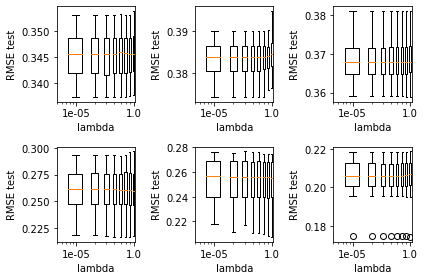

In [50]:
num_col = 3
num_row = int(np.ceil(rmse_te_loaded.shape[0]/num_col))

f, axs = plt.subplots(num_row, num_col)

plt.ticklabel_format(axis='x', style='sci', scilimits=None, useOffset=None, useLocale=None, useMathText=None)
    
for ind_group in range(rmse_te_loaded.shape[0]):
        
    ax = axs[ind_group // num_col][ind_group % num_col]    
    #Plotting only every 7th lambda
    ax.boxplot(rmse_te_loaded[ind_group,:,np.arange(0,rmse_te_loaded.shape[2],7)].T)
    
    ax.set_xscale('log')
    ax.set_xticks([1,8])
    ax.set_xticklabels(['i','j'])
    ax.set_xticklabels(lambdas[[0,49]])

    ax.set_xlabel("lambda")
    ax.set_ylabel("RMSE test")

plt.tight_layout()
plt.savefig("../plots/boxplot_error_groups_penalized_logistic_regression_basic_feature_engineering_tuning_lambda")
plt.show()

This analysis allows us to pick the best lambda parameter for each of the 6 subgroups

In [51]:
ind_lambda_mean = np.argmin(np.mean(rmse_te_loaded,axis=1),axis=1)
lambda_mean = lambdas[ind_lambda_mean]
print(lambda_mean)

[2.02358965e-05 8.68511374e-04 8.68511374e-04 6.25055193e-01
 2.44205309e-01 3.39322177e-04]


In [52]:
ind_lambda_median = np.argmin(np.median(rmse_te_loaded,axis=1),axis=1)
print(ind_lambda_median)

[ 3 37 39 48 13  0]


Finally, with the optimal degree up to which polynomial terms of the explanatory variables should be added and the optimal hyperparameter lambda determined for each subgroup, the task of predicting whether the "decay signatures" in the test dataset are the result of a Higgs boson can be adressed.

## Generate predictions and save ouput in csv format for submission:

In [53]:
DATA_TEST_PATH = "../../data/test.csv"
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [54]:
max_iters = 20
threshold = 10**(-8)
lambda_star_groups = lambda_mean
print("There are the final lambdas used for each group: ", np.around(lambda_star_groups,4))
degrees_star_groups = degrees_median_star
print("There are the final degrees used for each group: ",degrees_star_groups)
gamma = 1

There are the final lambdas used for each group:  [0.000e+00 9.000e-04 9.000e-04 6.251e-01 2.442e-01 3.000e-04]
There are the final degrees used for each group:  [9 3 3 4 4 3]


group (1/6)
underflow encountered in multiply
group=0, degree=9 , lambda= 2.024e-05, Training RMSE=0.343, Training loss=25678.403, Training # Missclassification =11366.000
group (2/6)
underflow encountered in multiply
group=1, degree=3 , lambda= 8.685e-04, Training RMSE=0.384, Training loss=32390.819, Training # Missclassification =14860.000
group (3/6)


../utilities/functions_for_log_regression.py:178: RuntimeWarning: invalid value encountered in double_scalars
  if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < threshold:


underflow encountered in multiply
group=2, degree=3 , lambda= 8.685e-04, Training RMSE=0.368, Training loss=31377.334, Training # Missclassification =14343.000
group (4/6)
underflow encountered in multiply
group=3, degree=4 , lambda= 6.251e-01, Training RMSE=0.245, Training loss=946.483, Training # Missclassification =341.000
group (5/6)
underflow encountered in multiply
group=4, degree=4 , lambda= 2.442e-01, Training RMSE=0.246, Training loss=1617.563, Training # Missclassification =581.000
group (6/6)
reached threshold
group=5, degree=3 , lambda= 3.393e-04, Training RMSE=0.204, Training loss=4120.715, Training # Missclassification =1318.000


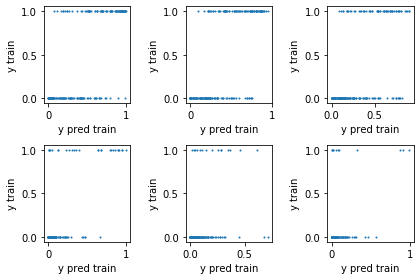

In [55]:
y_pred_test, w_star_groups = generate_predicitons_reg_logistic_regression_feature_engineering_groups(tX_test,tX,y,max_iters,threshold,lambda_star_groups,degrees_star_groups,gamma)

Once y_pred_test is determined, one can attribute -1 or 1 to the predicted values and generate a prediction in the submission format.

One last check that the dimensions of the predictions are correct: (568238,)

In [56]:
y_pred_test.shape

(568238,)

In [57]:
OUTPUT_PATH = '../../data/predicted_final.csv'
y_pred_submission = np.copy(y_pred_test)
y_pred_submission[np.where(y_pred_test <= 0)] = -1
y_pred_submission[np.where(y_pred_test > 0)] = 1
create_csv_submission(ids_test, y_pred_submission, OUTPUT_PATH)